# **Kaggle – DataTops®**

Tu TA ha decidido cambiar de aires y, por eso, ha comprado una tienda de portátiles. Sin embargo, su única especialidad es Data Science, por lo que ha decidido crear un modelo de ML para establecer los mejores precios.

¿Podrías ayudar a tu profe a mejorar ese modelo?

## Aspectos importantes

- Última submission:
	- Mañana: 17 de febrero a las 5pm
	- Tarde: 19 de febrero a las 5pm
- **Enlace de la competición**: https://www.kaggle.com/t/c5cc87b50c4b4770bdc8f5acbe15577d
- **Requisito**: Estar registrado en [Kaggle](https://www.kaggle.com/)

## Métrica

El error cuadrático medio (RMSE, por sus siglas en inglés) es una medida de la desviación estándar de los residuos (errores de predicción). Los residuos representan la diferencia entre los valores observados y los valores predichos por el modelo. El RMSE indica qué tan dispersos están estos errores: cuanto menor es el RMSE, más cercanas están las predicciones a los valores reales. En otras palabras, el RMSE mide qué tan bien se ajusta la línea de regresión a los datos.

$$ RMSE = \sqrt{\frac{1}{n}\Sigma_{i=1}^{n}{\Big(\frac{d_i -f_i}{\sigma_i}\Big)^2}}$$

## Librerías

In [1]:
from PIL import Image

from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import urllib.request

from google.colab import drive


# Mount the Google Drive at /content/drive
drive.mount("/content/drive")

# Verify by listing the files in the drive
# !ls /content/drive/My\ Drive/

## Datos

In [2]:
# Para que funcione necesitas bajarte los archivos de datos de Kaggle
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
path = "./data"
df = pd.read_csv(f"{path}/train.csv", encoding="utf-8")
df.shape

(912, 13)

### Exploración de los datos

In [3]:
def get_quality(dataframe: pd.DataFrame):
	if dataframe is None:
		raise ValueError("Dataframe sin especificar.")

	if not isinstance(dataframe, pd.DataFrame):
		raise ValueError("El dataframe debe ser pd.DataFrame")

	records = dataframe.shape[0]

	unique = dataframe.nunique().rename("Cardinality")
	cardinality = (unique/records).rename("Uniqueness")
	null = (dataframe.isna().sum()).rename("Null")

	data = pd.DataFrame(data=[unique, cardinality, null])
	return data.T

In [4]:
get_quality(df)

Cardinality  Uniqueness  Null
laptop_ID               912.0    1.000000   0.0
Company                  19.0    0.020833   0.0
Product                 480.0    0.526316   0.0
TypeName                  6.0    0.006579   0.0
Inches                   17.0    0.018640   0.0
ScreenResolution         36.0    0.039474   0.0
Cpu                     107.0    0.117325   0.0
Ram                       9.0    0.009868   0.0
Memory                   37.0    0.040570   0.0
Gpu                      93.0    0.101974   0.0
OpSys                     9.0    0.009868   0.0
Weight                  165.0    0.180921   0.0
Price_in_euros          603.0    0.661184   0.0

In [5]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 13 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         912 non-null    int64  
 1   Company           912 non-null    str    
 2   Product           912 non-null    str    
 3   TypeName          912 non-null    str    
 4   Inches            912 non-null    float64
 5   ScreenResolution  912 non-null    str    
 6   Cpu               912 non-null    str    
 7   Ram               912 non-null    str    
 8   Memory            912 non-null    str    
 9   Gpu               912 non-null    str    
 10  OpSys             912 non-null    str    
 11  Weight            912 non-null    str    
 12  Price_in_euros    912 non-null    float64
dtypes: float64(2), int64(1), str(10)
memory usage: 92.8 KB


In [6]:
df.head()

laptop_ID Company        Product   TypeName  Inches   ScreenResolution  \
0        755      HP         250 G6   Notebook    15.6  Full HD 1920x1080   
1        618    Dell  Inspiron 7559     Gaming    15.6  Full HD 1920x1080   
2        909      HP    ProBook 450   Notebook    15.6  Full HD 1920x1080   
3          2   Apple    Macbook Air  Ultrabook    13.3           1440x900   
4        286    Dell  Inspiron 3567   Notebook    15.6  Full HD 1920x1080   

                           Cpu   Ram               Memory  \
0     Intel Core i3 6006U 2GHz   8GB            256GB SSD   
1  Intel Core i7 6700HQ 2.6GHz  16GB              1TB HDD   
2   Intel Core i7 7500U 2.7GHz   8GB              1TB HDD   
3         Intel Core i5 1.8GHz   8GB  128GB Flash Storage   
4   Intel Core i3 6006U 2.0GHz   4GB              1TB HDD   

                              Gpu       OpSys  Weight  Price_in_euros  
0           Intel HD Graphics 520  Windows 10  1.86kg          539.00  
1  Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg          879.01  
2            Nvidia GeForce 930MX  Windows 10  2.04kg          900.00  
3          Intel HD Graphics 6000       macOS  1.34kg          898.94  
4              AMD Radeon R5 M430       Linux  2.25kg          428.00

In [7]:
df.tail()

laptop_ID Company             Product            TypeName  Inches  \
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                      Gpu       OpSys  Weight  \
907             256GB SSD           AMD Radeon 530  Windows 10   2.2kg   
908             256GB SSD    Intel HD Graphics 520  Windows 10  1.48kg   
909               2TB HDD    Intel HD Graphics 620       No OS   2.2kg   
910             500GB HDD            AMD Radeon R2       No OS  1.86kg   
911  256GB SSD +  1TB HDD  Nvidia GeForce GTX 1060  Windows 10  4.42kg   

     Price_in_euros  
907          800.00  
908         1629.00  
909          519.00  
910          258.00  
911         2456.34

In [8]:
df.describe()

laptop_ID      Inches  Price_in_euros
count   912.000000  912.000000      912.000000
mean    650.312500   14.981579     1111.724090
std     382.727748    1.436719      687.959172
min       2.000000   10.100000      174.000000
25%     324.750000   14.000000      589.000000
50%     636.500000   15.600000      978.000000
75%     982.250000   15.600000     1483.942500
max    1320.000000   18.400000     6099.000000

#### Transformaciones

Utilizamos regex para extraer datos de las columnas.

##### `ScreenResolution`

In [9]:
import re


def extract_screen_data(value):
	touchscreen_match = re.search(r"touchscreen", value, re.IGNORECASE)
	panel_match = re.search(r"(ips panel|lcd|oled)", value, re.IGNORECASE)
	type_match = re.search(r"(quad|full|ultra)\s?hd\+?", value, re.IGNORECASE)
	resolution_match = re.search(r"\d{3,4}x\d{3,4}", value, re.IGNORECASE)

	return {
		"has_touchscreen": True if touchscreen_match else False,
		"screen_panel": panel_match.group(0) if panel_match else None,
		"screen_type": type_match.group(0) if type_match else None,
		"screen_resolution": resolution_match.group(0) if resolution_match else None
	}

screen_data = df["ScreenResolution"].apply(extract_screen_data)
df = pd.concat([df, pd.DataFrame(screen_data.tolist())], axis=1)
columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
df.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel screen_type  \
386                     1366x768            False          NaN         NaN   
204            Full HD 1920x1080            False          NaN     Full HD   
713         Touchscreen 1366x768             True          NaN         NaN   
102  IPS Panel Full HD 2560x1440            False    IPS Panel     Full HD   
531                     1366x768            False          NaN         NaN   

    screen_resolution  
386          1366x768  
204         1920x1080  
713          1366x768  
102         2560x1440  
531          1366x768

Verificamos los valores nulos y los tratamos de completar en los casos en que existan en la columna.

In [10]:
df.loc[:, columns].isna().value_counts()

ScreenResolution  has_touchscreen  screen_panel  screen_type  screen_resolution
False             False            True          False        False                405
                                                 True         False                256
                                   False         False        False                224
                                                 True         False                 27
Name: count, dtype: int64

In [11]:
def screen_tier(value):
	width, height = map(int, value.split("x"))
	if width <= 1366:
		return "HD"
	elif width <= 1600:
		return "HD+"
	elif width <= 1920:
		return "Full HD"
	elif width <= 2304:
		return "Full HD+"
	elif width <= 2560:
		return "Quad HD"
	elif width <= 3200:
		return "Quad HD+"
	else:
		return "UHD"

df["screen_type"] = df["screen_resolution"].apply(screen_tier)

Ya que tenemos la resolución de la pantalla y las pulgadas de la diagonal, podemos calcular los **pixel per inch** de la misma.

In [12]:
data = df["screen_resolution"].str.split("x", expand=True).astype(int)
df = pd.concat(
	[
		df,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

df["screen_ppi"] = round(
	((df["screen_width"]**2 + df["screen_height"]**2)**0.5)/df["Inches"],
	2
)

In [13]:
df

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu       OpSys  Weight  \
0               256GB SSD           Intel HD Graphics 520  Windows 10  1.86kg   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  Windows 10  2.59kg   
2                 1TB HDD            Nvidia GeForce 930MX  Windows 10  2.04kg   
3     128GB Flash Storage          Intel HD Graphics 6000       macOS  1.34kg   
4                 1TB HDD              AMD Radeon R5 M430       Linux  2.25kg   
..                    ...                             ...         ...     ...   
907             256GB SSD                  AMD Radeon 530  Windows 10   2.2kg   
908             256GB SSD           Intel HD Graphics 520  Windows 10  1.48kg   
909               2TB HDD           Intel HD Graphics 620       No OS   2.2kg   
910             500GB HDD                   AMD Radeon R2       No OS  1.86kg   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  Windows 10  4.42kg   

     Price_in_euros  has_touchscreen screen_panel screen_type  \
0            539.00            False          NaN     Full HD   
1            879.01            False          NaN     Full HD   
2            900.00            False          NaN     Full HD   
3            898.94            False          NaN         HD+   
4            428.00            False          NaN     Full HD   
..              ...              ...          ...         ...   
907          800.00            False          NaN     Full HD   
908         1629.00             True          NaN     Full HD   
909          519.00            False          NaN     Full HD   
910          258.00            False          NaN          HD   
911         2456.34            False    IPS Panel     Full HD   

    screen_resolution  screen_width  screen_height  screen_ppi  
0           1920x1080          1920           1080      141.21  
1           1920x1080          1920           1080      141.21  
2           1920x1080          1920           1080      141.21  
3            1440x900          1440            900      127.68  
4           1920x1080          1920           1080      141.21  
..                ...           ...            ...         

mask = df.loc[:, "screen_type"].isna()
imputations = df.loc[
	mask,
	["screen_type", "screen_resolution"]
]["screen_resolution"].apply(screen_tier)
data = {"screen_type": imputations}

df.fillna(data, inplace=True).sample(10)

In [14]:
columns = df.iloc[:, -4:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

screen_resolution
1920x1080    577
1366x768     228
3840x2160     26
3200x1800     21
2560x1440     18
1600x900      14
2560x1600      5
2256x1504      5
1440x900       4
2304x1440      4
1920x1200      3
2880x1800      3
2160x1440      2
2400x1600      2
Name: count, dtype: int64
------------------------------
screen_width
1920    580
1366    228
3840     26
2560     23
3200     21
1600     14
2256      5
1440      4
2304      4
2880      3
2160      2
2400      2
Name: count, dtype: int64
------------------------------
screen_height
1080    577
768     228
2160     26
1440     24
1800     24
900      18
1600      7
1504      5
1200      3
Name: count, dtype: int64
------------------------------
screen_ppi
141.21    293
100.45    149
157.35     95
127.34     93
165.63     71
111.94     39
135.09     27
276.05     21
176.23     17
209.80     15
106.11     14
282.42     11
331.26      7
226.98      5
125.37      5
117.83      5
200.84      5
127.68      4
226.42      4
352.47      4
254

In [15]:
df["screen_resolution"] = df["screen_resolution"].astype("category")
df["screen_type"] = df["screen_type"].astype("category")
df["screen_panel"] = df["screen_panel"].astype("category")

In [16]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   laptop_ID          912 non-null    int64   
 1   Company            912 non-null    str     
 2   Product            912 non-null    str     
 3   TypeName           912 non-null    str     
 4   Inches             912 non-null    float64 
 5   ScreenResolution   912 non-null    str     
 6   Cpu                912 non-null    str     
 7   Ram                912 non-null    str     
 8   Memory             912 non-null    str     
 9   Gpu                912 non-null    str     
 10  OpSys              912 non-null    str     
 11  Weight             912 non-null    str     
 12  Price_in_euros     912 non-null    float64 
 13  has_touchscreen    912 non-null    bool    
 14  screen_panel       251 non-null    category
 15  screen_type        912 non-null    category
 16  screen_resolution  

##### `CPU`

In [ ]:
def extract_cpu_data(value):
	if "samsung" in value.strip().lower():
		# BRAND
		pattern = r"samsung"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=Samsung\s)(Cortex)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match else None

		# SERIES
		pattern = r"(?P<serie>[A-Z]\d{1,2}&[A-Z]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		generation = None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "amd" in value.strip().lower():
		# BRAND
		pattern = r"amd"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=amd\s)(([a-z])(?:\d{0,2})(-series)|ryzen|fx|athlon|threadripper|epyc)"
		is_match = re.search(pattern, value, re.IGNORECASE)

		group1, group2, group3 = is_match.groups()
		is_group1 = group2 is None and group3 is None
		family = group1 if is_group1 else group2 + group3

		# SERIES
		pattern = r"(?P<serie>[ae]\d{1,2})"
		is_match = re.search(pattern, value, re.IGNORECASE)
		series = is_match.group("serie") if is_match else None

		# GEN
		pattern = r"(\d{1})\d{3}[a-z]?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None

		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": series,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

	if "intel" in value.strip().lower():
		# BRAND
		pattern = r"intel"
		is_match = re.search(pattern, value, re.IGNORECASE)
		brand = is_match.group(0) if is_match else None

		# FAMILY
		pattern = r"(?<=intel)\s(?P<family>xeon|atom|core|pentium|celeron)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		family = is_match.group(0) if is_match.group("family") else None

		# SERIES
		pattern = r"((?:pentium\s|celeron\s)(dual|single|quad))|((?:atom|xeon|core m?|atom)\s?([xeim]\d*))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			serie = is_match.group(4) if is_match.group(4) is not None else is_match.group(2) + " Core"
		else:
			serie = None

		# GEN
		pattern = r"(\d{1})+\d{3,4}[a-z]*"
		is_match = re.search(pattern, value, re.IGNORECASE)
		generation = is_match.group(1) if is_match else None

		# CLOCK
		pattern = r"(\d[\d\.]*)(?:[a-z]+)$"
		is_match = re.search(pattern, value, re.IGNORECASE)
		clock = is_match.group(1) if is_match else None


		return {
			"cpu_brand": brand,
			"cpu_family": family,
			"cpu_series": serie,
			"cpu_gen": generation,
			"cpu_clock": clock
		}

cpu_data = pd.DataFrame(df.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
df = pd.concat([df, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_gen",
	"cpu_clock",
]
df.sample(5).loc[:, columns]

In [18]:
df.loc[:, columns].isna().sum()

Cpu            0
cpu_brand      0
cpu_family     0
cpu_series     8
cpu_gen       35
cpu_clock      0
dtype: int64

In [19]:
mask = df[["Cpu", "cpu_series", "cpu_gen"]].isna().any(axis=1)
df.loc[mask, ["Cpu", "cpu_series", "cpu_gen"]]

Cpu cpu_series cpu_gen
3           Intel Core i5 1.8GHz         i5     NaN
10          Intel Core i5 2.9GHz         i5     NaN
48           AMD Ryzen 1700 3GHz        NaN       1
59          Intel Core i5 1.3GHz         i5     NaN
76          Intel Core i5 3.1GHz         i5     NaN
89             AMD FX 9830P 3GHz        NaN       9
99     Intel Core i7 7Y75 1.3GHz         i7     NaN
155     AMD E-Series 7110 1.8GHz        NaN       7
169  Intel Core M m3-7Y30 2.2GHz         m3     NaN
184     Intel Core M 6Y54 1.1GHz          M     NaN
197  Intel Core M M7-6Y75 1.2GHz         M7     NaN
199     Intel Core M 6Y75 1.2GHz          M     NaN
224  Intel Core M M3-6Y30 0.9GHz         M3     NaN
227         Intel Core i5 2.0GHz         i5     NaN
230     Intel Core M 6Y30 0.9GHz          M     NaN
241  Intel Core M m7-6Y75 1.2GHz         m7     NaN
281         Intel Core i5 1.6GHz         i5     NaN
284    Intel Core i7 7Y75 1.3GHz         i7     NaN
319    Intel Core i5 7Y54 1.2GHz         i5     NaN
324         Intel Core i5 3.1GHz         i5     NaN
330     AMD E-Series 6110 1.5GHz        NaN       6
334       Intel Core M m3 1.2GHz         m3     NaN
343          Intel Core M 1.1GHz          M     NaN
356    AMD E-Series 9000e 1.5GHz        NaN       9
393     Intel Core M 6Y75 1.2GHz          M     NaN
456     Intel Core M 6Y75 1.2GHz          M     NaN
473         Intel Core i7 2.2GHz         i7     NaN
478    Intel Core i5 7Y57 1.2GHz         i5     NaN
526         Intel Core i5 1.6GHz         i5     NaN
549         Intel Core i5 1.8GHz         i5     NaN
576         Intel Core i7 2.7GHz         i7     NaN
646    Intel Core i7 7Y75 1.3GHz         i7     NaN
665     Intel Core M 6Y75 1.2GHz          M     NaN
707          Intel Core M 1.2GHz          M     NaN
711         Intel Core i5 1.6GHz         i5     NaN
713     Intel Core M 7Y30 1.0GHz          M     NaN
721          AMD Ryzen 1700 3GHz        NaN       1
752         Intel Core i7 2.8GHz         i7     NaN
754        AMD Ryzen 1600 3.2GHz        NaN       1
775         Intel Core i5 2.3GHz         i5     NaN
783     Intel Core M 6Y30 0.9GHz          M     NaN
839     Intel Atom Z8350 1.92GHz        NaN       8
862    Intel Core i7 7Y75 1.3GHz         i7     NaN

Rellenamos con una etiqueta `unknown` para de la columna generada `cpu_series`, la otra variable la eliminaremos luego de nuestro dataset.

In [20]:
df.fillna({"cpu_series": "unknown"}, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... screen_type  \
0               256GB SSD           Intel HD Graphics 520  ...     Full HD   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...     Full HD   
2                 1TB HDD            Nvidia GeForce 930MX  ...     Full HD   
3     128GB Flash Storage          Intel HD Graphics 6000  ...         HD+   
4                 1TB HDD              AMD Radeon R5 M430  ...     Full HD   
..                    ...                             ...  ...         ...   
907             256GB SSD                  AMD Radeon 530  ...     Full HD   
908             256GB SSD           Intel HD Graphics 520  ...     Full HD   
909               2TB HDD           Intel HD Graphics 620  ...     Full HD   
910             500GB HDD                   AMD Radeon R2  ...          HD   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...     Full HD   

    screen_resolution  screen_width  screen_height screen_ppi cpu_brand  \
0           1920x1080          1920           1080     141.21     Intel   
1           1920x1080          1920           1080     141.21     Intel   
2           1920x1080          1920           1080     141.21     Intel   
3            1440x900          1440            900     127.68     Intel   
4           1920x1080          1920           1080     141.21     Intel   
..                ...           ...            ...        ...       ...   
907         1920x1080          1920           1080     141.21     Intel   
908         1920x1080          1920           1080     165.63     Intel   
909         1920x1080          1920           1080     141.21     Intel   
910          1366x768          1366            768     100.45       AMD   
911         1920x1080          1920           1080     127.34     Intel   

    cpu_family  cpu_series  cpu_gen  cpu_clock  
0         Core          i3        6          2  
1         Core          i7        6        2.6  
2         Core          i7        7        2.7  
3         Core          i5      NaN        1.8  
4         Core          i3        6        2.0  
..         ...         ...      ...        ...  
907       Core        

In [21]:
df["cpu_brand"] = df["cpu_brand"].astype("category")
df["cpu_clock"] = df["cpu_clock"].astype(float)
df["cpu_family"] = df["cpu_family"].astype("category")
df["cpu_series"] = df["cpu_series"].astype("category")
df["cpu_gen"] = df["cpu_gen"].astype(float)

In [22]:
columns = df.iloc[:, -5:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

cpu_brand
Intel    870
AMD       42
Name: count, dtype: int64
------------------------------
cpu_family
Core        764
Celeron      70
A-Series     31
Pentium      24
Atom         10
E-Series      7
Ryzen         3
Xeon          2
FX            1
Name: count, dtype: int64
------------------------------
cpu_series
i7           374
i5           282
i3            93
Dual Core     68
Quad Core     26
A9            11
M             10
A6             9
unknown        8
x5             8
A12            5
A10            4
E2             4
A8             2
E3             2
m3             2
M3             1
M7             1
X5             1
m7             1
Name: count, dtype: int64
------------------------------
cpu_gen
7.0    416
6.0    218
8.0    111
3.0     81
9.0     33
4.0     13
1.0      5
Name: count, dtype: int64
------------------------------
cpu_clock
2.50    199
2.80    120
2.70    117
1.60    107
2.00     60
2.30     58
1.80     51
2.60     47
1.10     37
2.40     33
2.90     15
3.0

In [23]:
df.iloc[:, -5:].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   cpu_brand   912 non-null    category
 1   cpu_family  912 non-null    category
 2   cpu_series  912 non-null    category
 3   cpu_gen     877 non-null    float64 
 4   cpu_clock   912 non-null    float64 
dtypes: category(3), float64(2)
memory usage: 17.6 KB


##### `RAM`

In [24]:
def extract_ram_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)"

	is_match = re.search(pattern, value, re.IGNORECASE)
	if is_match:
		data[f"ram_size"] = is_match.group("size")
		data[f"ram_capacity"] = is_match.group("capacity")

	return pd.Series(data)


ram_data = df.loc[:, "Ram"].apply(extract_ram_data)
df = pd.concat([df, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
df.sample(5).loc[:, columns]

Ram ram_size ram_capacity
81   16GB       16           GB
536  16GB       16           GB
124   4GB        4           GB
729   4GB        4           GB
758  16GB       16           GB

In [25]:
df["ram_size"] = df["ram_size"].astype(int)
df["ram_capacity"] = df["ram_capacity"].astype("category")

In [26]:
columns = df.iloc[:, -2:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

ram_size
8     434
4     267
16    136
6      24
2      20
12     19
32     10
64      1
24      1
Name: count, dtype: int64
------------------------------
ram_capacity
GB    912
Name: count, dtype: int64
------------------------------


##### `HDD`

In [27]:
def extract_memory_data(value):
	data = {}
	pattern = r"(?P<size>[\.\d]*?\d{1,4})(?P<capacity>gb|tb)\s(?P<type>hybrid|ssd|hdd|flash\sstorage)"

	memories = value.split("+")
	for index, memory in enumerate(memories, 1):
		is_match = re.search(pattern, memory, re.IGNORECASE)
		if is_match:
			data[f"hdd_size_{index}"] = is_match.group("size")
			data[f"hdd_capacity_{index}"] = is_match.group("capacity")
			data[f"hdd_type_{index}"] = is_match.group("type")

	columns = [
		"hdd_size_1",
		"hdd_capacity_1",
		"hdd_type_1",
		"hdd_size_2",
		"hdd_capacity_2",
		"hdd_type_2"
	]
	return pd.Series(data)

memory_data = df.loc[:, "Memory"].apply(extract_memory_data)
df = pd.concat([df, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
df.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1     hdd_type_1 hdd_size_2  \
590               8GB SSD          8             GB            SSD        NaN   
678  256GB SSD +  2TB HDD        256             GB            SSD          2   
58              500GB HDD        500             GB            HDD        NaN   
675             256GB SSD        256             GB            SSD        NaN   
327    64GB Flash Storage         64             GB  Flash Storage        NaN   

    hdd_capacity_2 hdd_type_2  
590            NaN        NaN  
678             TB        HDD  
58             NaN        NaN  
675            NaN        NaN  
327            NaN        NaN

In [28]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Memory          912 non-null    str  
 1   hdd_size_1      912 non-null    str  
 2   hdd_capacity_1  912 non-null    str  
 3   hdd_type_1      912 non-null    str  
 4   hdd_size_2      144 non-null    str  
 5   hdd_capacity_2  144 non-null    str  
 6   hdd_type_2      144 non-null    str  
dtypes: str(7)
memory usage: 50.0 KB


In [29]:
mask = df[columns].isna().any(axis=1)
df.loc[mask, columns]

Memory hdd_size_1 hdd_capacity_1     hdd_type_1 hdd_size_2  \
0              256GB SSD        256             GB            SSD        NaN   
1                1TB HDD          1             TB            HDD        NaN   
2                1TB HDD          1             TB            HDD        NaN   
3    128GB Flash Storage        128             GB  Flash Storage        NaN   
4                1TB HDD          1             TB            HDD        NaN   
..                   ...        ...            ...            ...        ...   
906            256GB SSD        256             GB            SSD        NaN   
907            256GB SSD        256             GB            SSD        NaN   
908            256GB SSD        256             GB            SSD        NaN   
909              2TB HDD          2             TB            HDD        NaN   
910            500GB HDD        500             GB            HDD        NaN   

    hdd_capacity_2 hdd_type_2  
0              NaN        NaN  
1              NaN        NaN  
2              NaN        NaN  
3              NaN        NaN  
4              NaN        NaN  
..             ...        ...  
906            NaN        NaN  
907            NaN        NaN  
908            NaN        NaN  
909            NaN        NaN  
910            NaN        NaN  

[768 rows x 7 columns]

In [30]:
df["hdd_size_1"] = df["hdd_size_1"].str.replace("1.0", "1")
df["hdd_size_1"] = df["hdd_size_1"].astype(int)

df["hdd_size_2"] = df["hdd_size_2"].astype(float)

df["hdd_capacity_1"] = df["hdd_capacity_1"].astype("category")
df["hdd_type_1"] = df["hdd_type_1"].astype("category")
df["hdd_capacity_2"] = df["hdd_capacity_2"].astype("category")
#df["hdd_type_2"] = df["hdd_type_2"].astype("category")

In [ ]:
columns = df.iloc[:, -6:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

hdd_size_1
256    349
1      173
128    127
512     96
500     92
32      39
64      13
16       9
2        8
180      3
240      1
508      1
8        1
Name: count, dtype: int64
------------------------------
hdd_capacity_1
GB    731
TB    181
Name: count, dtype: int64
------------------------------
hdd_type_1
SSD              587
HDD              256
Flash Storage     63
Hybrid             6
Name: count, dtype: int64
------------------------------
hdd_size_2
1.0      131
2.0        9
256.0      2
512.0      1
500.0      1
Name: count, dtype: int64
------------------------------
hdd_capacity_2
TB    140
GB      4
Name: count, dtype: int64
------------------------------
hdd_type_2
HDD    141
SSD      3
Name: count, dtype: int64
------------------------------


In [32]:
df.loc[:, columns].info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   hdd_size_1      912 non-null    int64   
 1   hdd_capacity_1  912 non-null    category
 2   hdd_type_1      912 non-null    category
 3   hdd_size_2      144 non-null    float64 
 4   hdd_capacity_2  144 non-null    category
 5   hdd_type_2      144 non-null    str     
dtypes: category(3), float64(1), int64(1), str(1)
memory usage: 24.2 KB


##### `GPU`

In [33]:
def extract_gpu_data(value):
	data = {}
	if "intel" in value.lower():
		pattern = r"(?P<brand>intel) (?P<family>(hd|iris(\splus|\spro)?|uhd)(?:\sgraphics)?)(?:\s)?(?P<model>\d+[a-z]?)?"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip() if is_match.group("model") else None

	if "amd" in value.lower():
		pattern = r"(?P<brand>amd) (?P<family>(radeon\s?(rx|r\d|pro)?|firepro|r[\d\w])\s?(graphics)?)(?P<model>[a-z]?\d{0,4}[a-z]?)"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	if "nvidia" in value.lower():
		pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
		is_match = re.search(pattern, value, re.IGNORECASE)
		if is_match:
			data["gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
			data["gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
			data["gpu_model"] = is_match.group("model").strip()

	return pd.Series(data, name="gpu")


columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = df["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
df = pd.concat([df, data], axis=1)

columns.insert(0, "Gpu")
df.sample(5).loc[:, columns]

Gpu gpu_brand   gpu_family gpu_model
576     AMD Radeon Pro 455       AMD   Radeon Pro       455
73      AMD Radeon R7 M445       AMD    Radeon R7      M445
748  Intel HD Graphics 520     Intel  HD Graphics       520
651         AMD Radeon 530       AMD       Radeon       530
431  Intel HD Graphics 520     Intel  HD Graphics       520

In [34]:
mask = df[columns].isna().any(axis=1)
df.loc[mask, columns]

Gpu gpu_brand         gpu_family gpu_model
23           Intel HD Graphics     Intel        HD Graphics       NaN
58           Intel HD Graphics     Intel        HD Graphics       NaN
62           Intel HD Graphics     Intel        HD Graphics       NaN
85           Intel HD Graphics     Intel        HD Graphics       NaN
104          Intel HD Graphics     Intel        HD Graphics       NaN
110          Intel HD Graphics     Intel        HD Graphics       NaN
178         Intel Graphics 620       NaN                NaN       NaN
183          Intel HD Graphics     Intel        HD Graphics       NaN
202          Intel HD Graphics     Intel        HD Graphics       NaN
236          Intel HD Graphics     Intel        HD Graphics       NaN
305          Intel HD Graphics     Intel        HD Graphics       NaN
331          Intel HD Graphics     Intel        HD Graphics       NaN
357          Intel HD Graphics     Intel        HD Graphics       NaN
361          Intel HD Graphics     Intel        HD Graphics       NaN
387          Intel HD Graphics     Intel        HD Graphics       NaN
473    Intel Iris Pro Graphics     Intel  Iris Pro Graphics       NaN
479          Intel HD Graphics     Intel        HD Graphics       NaN
516          Intel HD Graphics     Intel        HD Graphics       NaN
522          Intel HD Graphics     Intel        HD Graphics       NaN
559          Intel HD Graphics     Intel        HD Graphics       NaN
587  Nvidia GeForce GTX1050 Ti       NaN                NaN       NaN
596          Intel HD Graphics     Intel        HD Graphics       NaN
601          Intel HD Graphics     Intel        HD Graphics       NaN
603          Intel HD Graphics     Intel        HD Graphics       NaN
609          Intel HD Graphics     Intel        HD Graphics       NaN
632          Intel HD Graphics     Intel        HD Graphics       NaN
864          Intel HD Graphics     Intel        HD Graphics       NaN
880          Intel HD Graphics     Intel        HD Graphics       NaN

Las **regex** no lograron capturar los datos correctamente en la Nvidia por como se encuentra escrita. Editando el nombre se resuelve facilmente. Respecto a las otras, lo rellenamos con la moda, pero en el caso de `gpu_model`, con una etiqueta de `unknown`.

In [35]:
df.loc[587, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, df.loc[587, "Gpu"], re.IGNORECASE)
if is_match:
	df.loc[587, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	df.loc[587, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	df.loc[587, "gpu_model"] = is_match.group("model").strip()

df["gpu_family"] = df["gpu_family"].str.replace("Graphics", "")

In [36]:
df.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

                    ScreenResolution                           Cpu   Ram  \
0                  Full HD 1920x1080      Intel Core i3 6006U 2GHz   8GB   
1                  Full HD 1920x1080   Intel Core i7 6700HQ 2.6GHz  16GB   
2                  Full HD 1920x1080    Intel Core i7 7500U 2.7GHz   8GB   
3                           1440x900          Intel Core i5 1.8GHz   8GB   
4                  Full HD 1920x1080    Intel Core i3 6006U 2.0GHz   4GB   
..                               ...                           ...   ...   
907                Full HD 1920x1080    Intel Core i5 8250U 1.6GHz   8GB   
908  Full HD / Touchscreen 1920x1080    Intel Core i5 6300U 2.4GHz   8GB   
909                Full HD 1920x1080    Intel Core i5 7200U 2.5GHz   8GB   
910                         1366x768  AMD E-Series E2-9000e 1.5GHz   4GB   
911      IPS Panel Full HD 1920x1080   Intel Core i7 7700HQ 2.8GHz  16GB   

                   Memory                             Gpu  ... ram_capacity  \
0               256GB SSD           Intel HD Graphics 520  ...           GB   
1                 1TB HDD  Nvidia GeForce GTX 960<U+039C>  ...           GB   
2                 1TB HDD            Nvidia GeForce 930MX  ...           GB   
3     128GB Flash Storage          Intel HD Graphics 6000  ...           GB   
4                 1TB HDD              AMD Radeon R5 M430  ...           GB   
..                    ...                             ...  ...          ...   
907             256GB SSD                  AMD Radeon 530  ...           GB   
908             256GB SSD           Intel HD Graphics 520  ...           GB   
909               2TB HDD           Intel HD Graphics 620  ...           GB   
910             500GB HDD                   AMD Radeon R2  ...           GB   
911  256GB SSD +  1TB HDD         Nvidia GeForce GTX 1060  ...           GB   

    hdd_size_1  hdd_capacity_1     hdd_type_1 hdd_size_2 hdd_capacity_2  \
0          256              GB            SSD        NaN            NaN   
1            1              TB            HDD        NaN            NaN   
2            1              TB            HDD        NaN            NaN   
3          128              GB  Flash Storage        NaN            NaN   
4            1              TB            HDD        NaN            NaN   
..         ...             ...            ...        ...            ...   
907        256              GB            SSD        NaN            NaN   
908        256              GB            SSD        NaN            NaN   
909          2              TB            HDD        NaN            NaN   
910        500              GB            HDD        NaN            NaN   
911        256              GB            SSD        1.0             TB   

    hdd_type_2  gpu_brand   gpu_family  gpu_model  
0          NaN      Intel          HD         520  
1          NaN     Nvidia  GeForce GTX        960  
2          NaN     Nvidia      GeForce      930MX  
3          NaN      Intel          HD        6000  
4          NaN        AMD    Radeon R5       M430  
..         ...        ...          ...   

In [37]:
df["gpu_brand"] = df["gpu_brand"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")
df["gpu_model"] = df["gpu_model"].astype("category")

In [ ]:
columns = df.iloc[:, -3:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

gpu_brand
Intel     509
Nvidia    284
AMD       119
Name: count, dtype: int64
------------------------------
gpu_family
HD             445
GeForce GTX    170
GeForce         90
UHD             52
Radeon R5       39
Radeon          34
Quadro          19
Radeon R7       14
Radeon RX       10
Iris Plus        8
Radeon R4        7
Radeon R2        7
FirePro          4
GeForce GT       4
Iris             3
Radeon Pro       2
Iris Pro         1
GTX              1
R1               1
R4               1
Name: count, dtype: int64
------------------------------
gpu_model
620       238
520       137
1050       48
940MX      38
1060       31
         ... 
M365X       1
M500M       1
M620M       1
W5130M      1
W6150M      1
Name: count, Length: 70, dtype: int64
------------------------------


#### Limpieza

In [39]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
df.drop(columns=to_delete, inplace=True)

In [ ]:
df["Company"] = df["Company"].astype("category")
df["TypeName"] = df["TypeName"].astype("category")
# df["OpSys"] = df["OpSys"].astype("category")
df["Inches"] = df["Inches"].astype(float)
df["Weight"] = df["Weight"].apply(lambda x: x.replace("kg", ""))
df["Weight"] = df["Weight"].astype(float)

In [41]:
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 912 entries, 0 to 911
Data columns (total 31 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   laptop_ID          912 non-null    int64   
 1   Company            912 non-null    category
 2   Product            912 non-null    str     
 3   TypeName           912 non-null    category
 4   Inches             912 non-null    float64 
 5   OpSys              912 non-null    str     
 6   Weight             912 non-null    float64 
 7   Price_in_euros     912 non-null    float64 
 8   has_touchscreen    912 non-null    bool    
 9   screen_panel       251 non-null    category
 10  screen_type        912 non-null    category
 11  screen_resolution  912 non-null    category
 12  screen_width       912 non-null    int64   
 13  screen_height      912 non-null    int64   
 14  screen_ppi         912 non-null    float64 
 15  cpu_brand          912 non-null    category
 16  cpu_family         

#### Análisis Univariante

Antes de hacer un split entre los datos, análizamos brevemente las caracteristicas que hemos recopilado para darnos idea de realizar alguna transformación adicional a los datos que pueda ser relevante.

In [42]:
from matplotlib import ticker



def plot_category(serie: pd.Series):
	fig, axs = plt.subplots(nrows=1,
							ncols=2,
							figsize=(10, 4),
							layout="constrained")
	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}

	fig.suptitle(f"{serie.name}".upper(),
				 color="#C5BFFD",
				 fontproperties=font_config,
				 y=1.10)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[0].set_title("Cantidad absoluta",
					color="#C5BFFD",
					fontdict=font_config)


	data = serie.value_counts()
	axs[0].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#60A5FA",
			   zorder=2)

	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[0].tick_params(axis="y", width=0)
	axs[0].set_xticks(ticks=data.index)
	#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

	axs[0].set_ylabel("Cantidad",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[0].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)
	axs[0].spines[["left", "top", "right"]].set_visible(False)
	axs[0].spines["bottom"].set_linewidth(1)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "heavy"
	}
	axs[1].set_title("Cantidad relativa",
					 color="#C5BFFD",
					 fontdict=font_config)


	data = serie.value_counts(normalize=True)
	axs[1].bar(x=data.index,
			   height=data.values,
			   data=data,
			   color="#FFBD54",
			   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "large",
		"weight": "bold"
	}
	axs[1].set_xticks(ticks=data.index)
	#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

	axs[1].set_ylabel("Cant. según total",
					  color="#F2F2F2",
					  labelpad=10,
					  fontdict=font_config)
	axs[1].tick_params(axis="y", width=0)
	axs[1].yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

	axs[1].grid(axis="y",
				alpha=1,
				color="#404040",
				linestyle="dashed",
				linewidth=1)

	axs[1].spines[["left", "top", "right"]].set_visible(False)
	axs[1].spines["bottom"].set_linewidth(1)

	fig.get_layout_engine().set(wspace=0.15)
	plt.show()

##### **`Company`**

In [43]:
companies = len(df["Company"].unique())
print(f"Contamos con { companies } fabricantes de notebooks")

Contamos con 19 fabricantes de notebooks


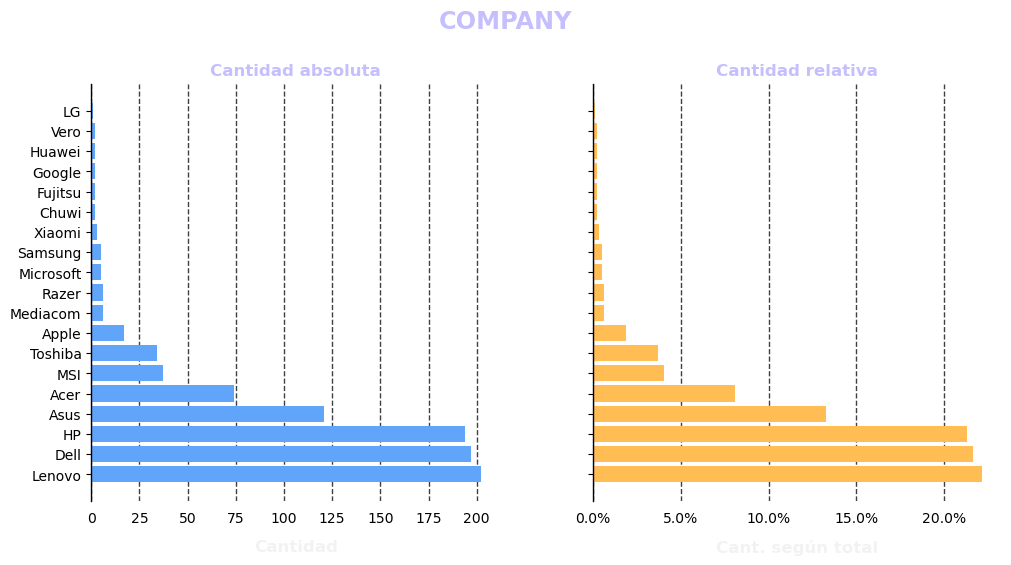

In [44]:
serie = df["Company"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`TypeName`**

In [45]:
notebook_types = df["TypeName"].unique()
print(f"Contamos con {len(notebook_types)} tipos de notebooks")

Contamos con 6 tipos de notebooks


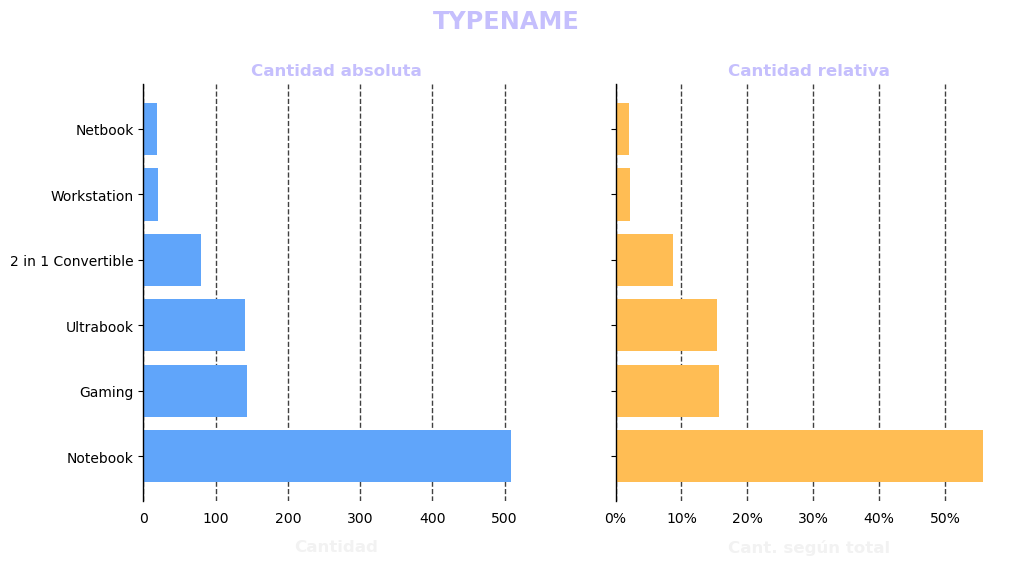

In [46]:
serie = df["TypeName"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`Inches`**

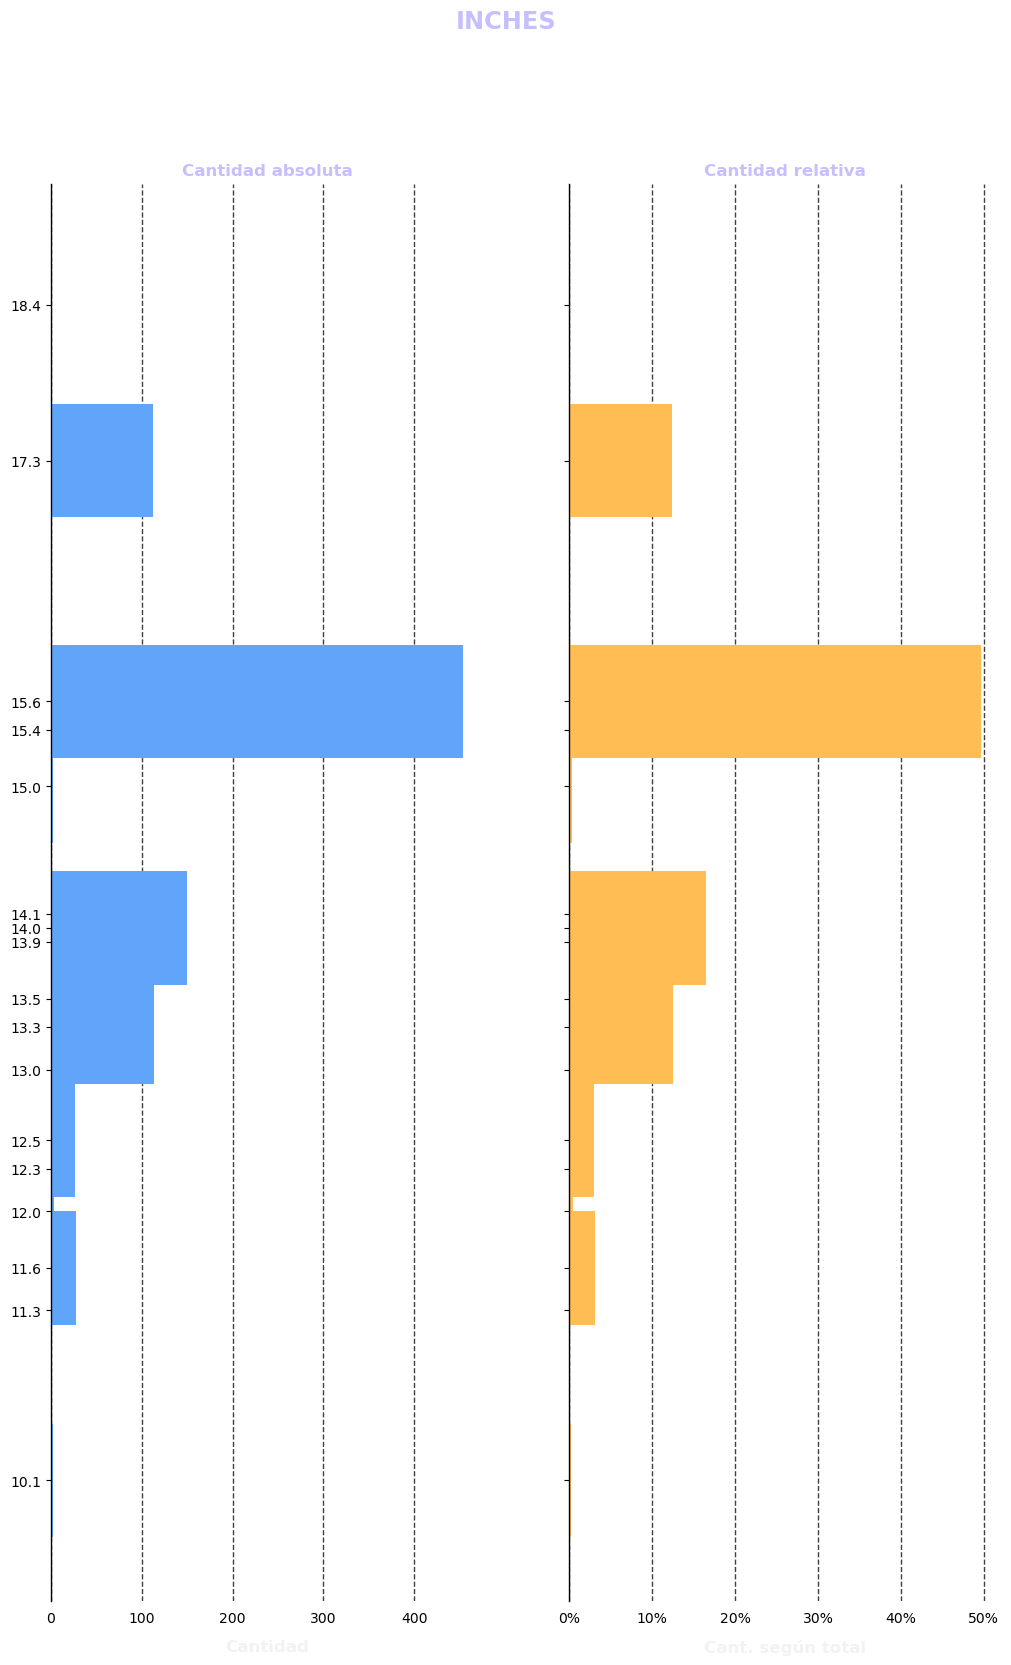

In [47]:
serie = df["Inches"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 15),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
#axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`OpSys`**

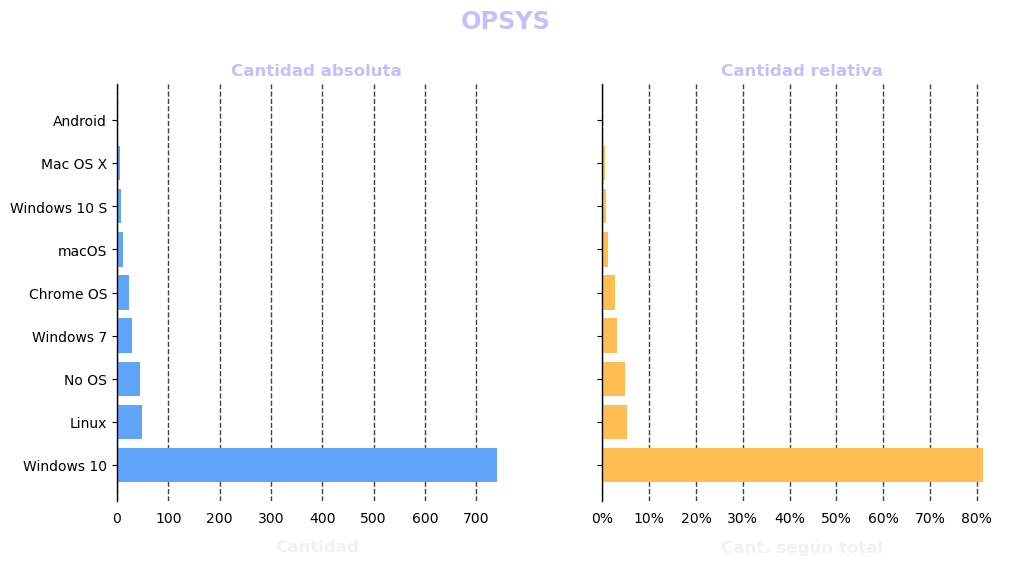

In [48]:
serie = df["OpSys"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

Tenemos distintas versiones de sistemas operativos. Tal vez, sería mejor agruparlos por proveedor y no por versión del mismo.

##### **`Weight`**

In [49]:
def filter_outliers(serie: pd.Series,
					whisker: float | None=1.75,
					below_zero=False):
	q25 = serie.quantile(.25)
	q75 = serie.quantile(.75)
	iqr = q75 - q25

	minimum = q25 - whisker * iqr
	maximum = q75 + whisker * iqr

	if minimum < 0:
		minimum = minimum if below_zero else 0

	below_minimum = serie > minimum
	above_maximum = serie < maximum
	mask = below_minimum & above_maximum

	filtered = serie[mask]
	return filtered

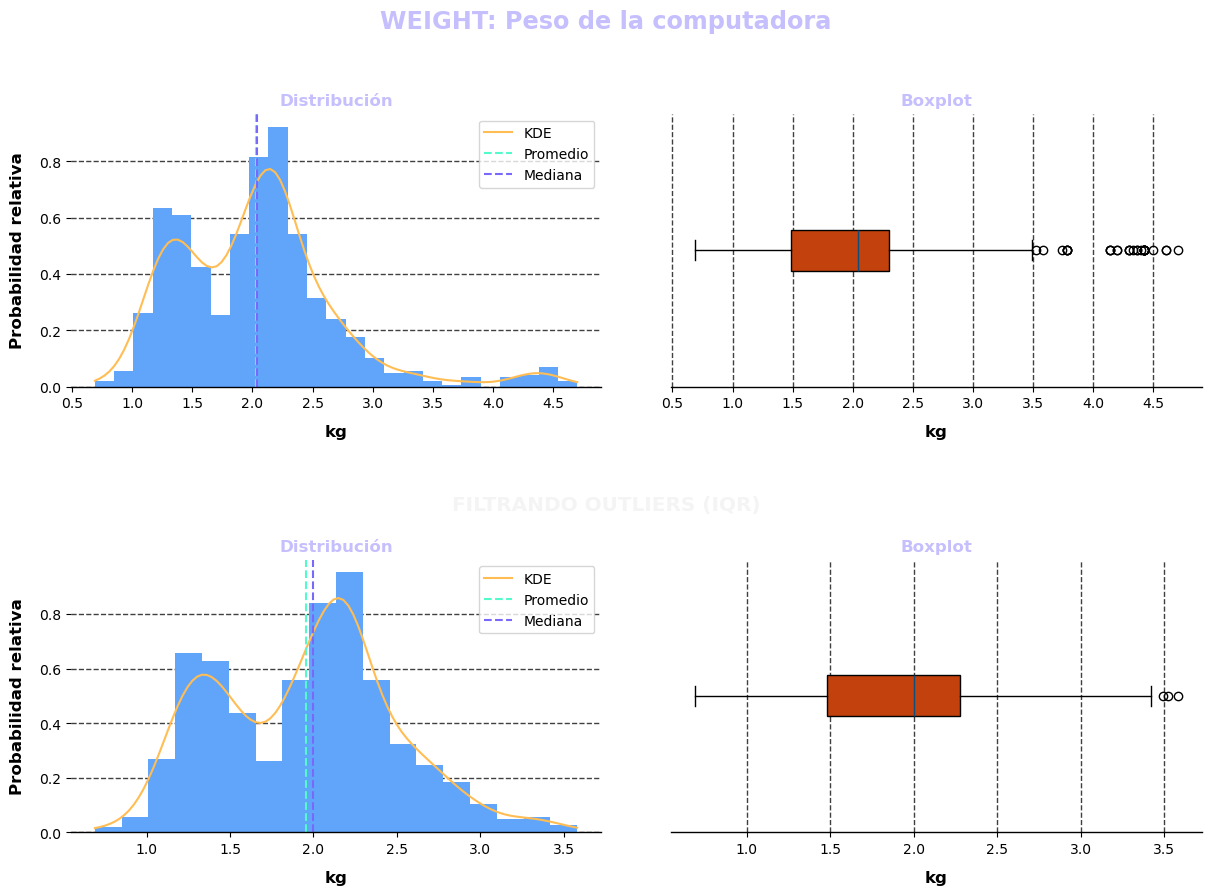

In [50]:
serie = df["Weight"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Peso de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`Price`**

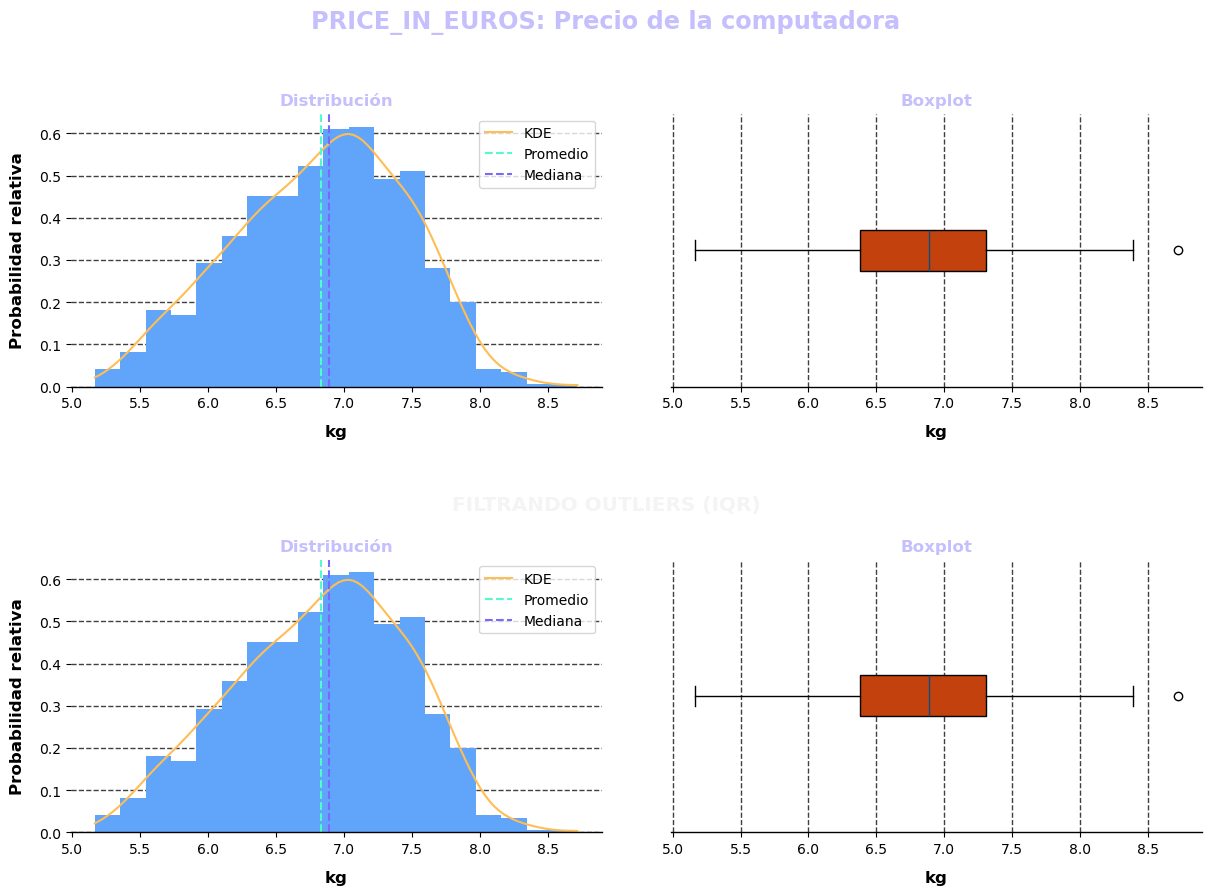

In [51]:
serie = np.log1p(df["Price_in_euros"])

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Precio de la computadora",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("kg", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

La distribución tiene una larga cola hacía la derecha

##### **`Screen`**

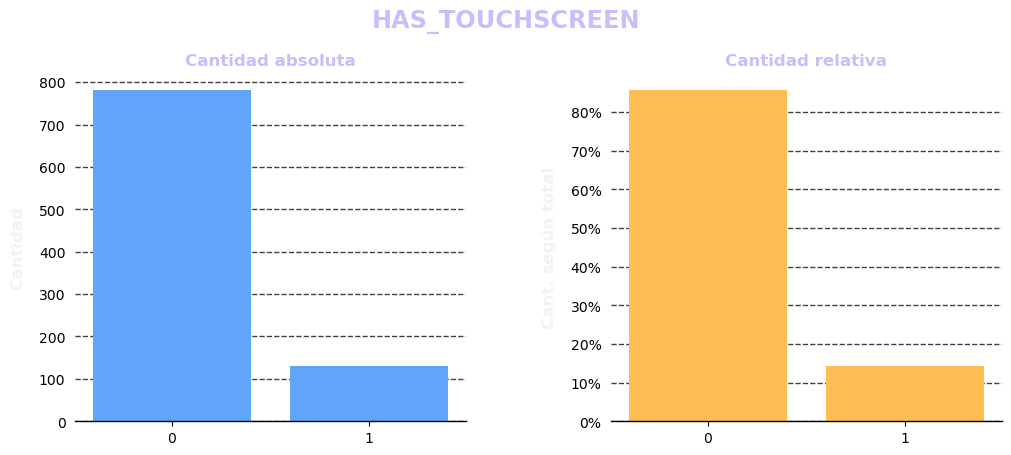

In [52]:
plot_category(df["has_touchscreen"])

In [53]:
screen_types = df["screen_type"].unique()
print(f"Contamos con {len(screen_types)} TIERs según la resolución de pantallas")

Contamos con 7 TIERs según la resolución de pantallas


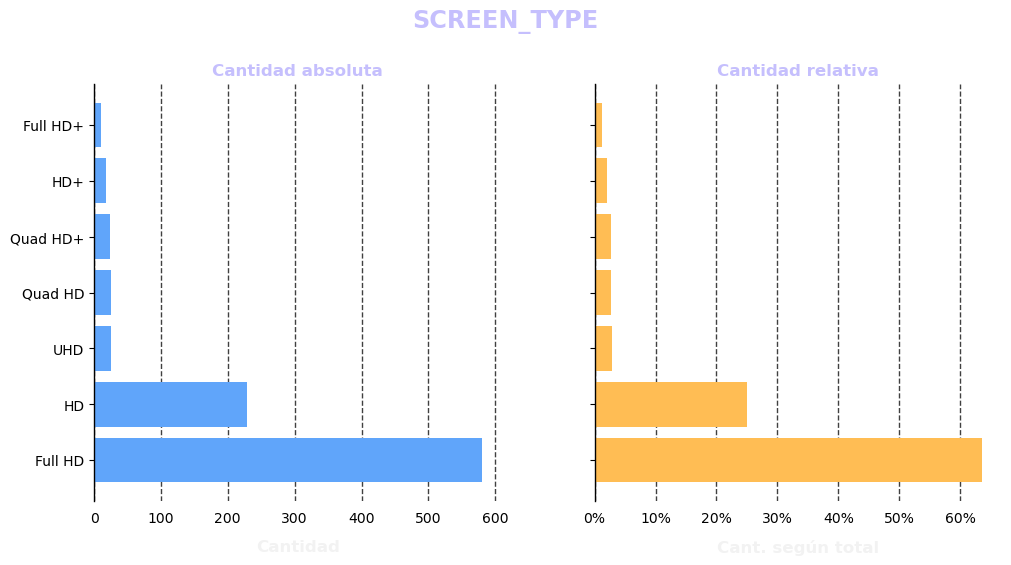

In [54]:
serie = df["screen_type"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

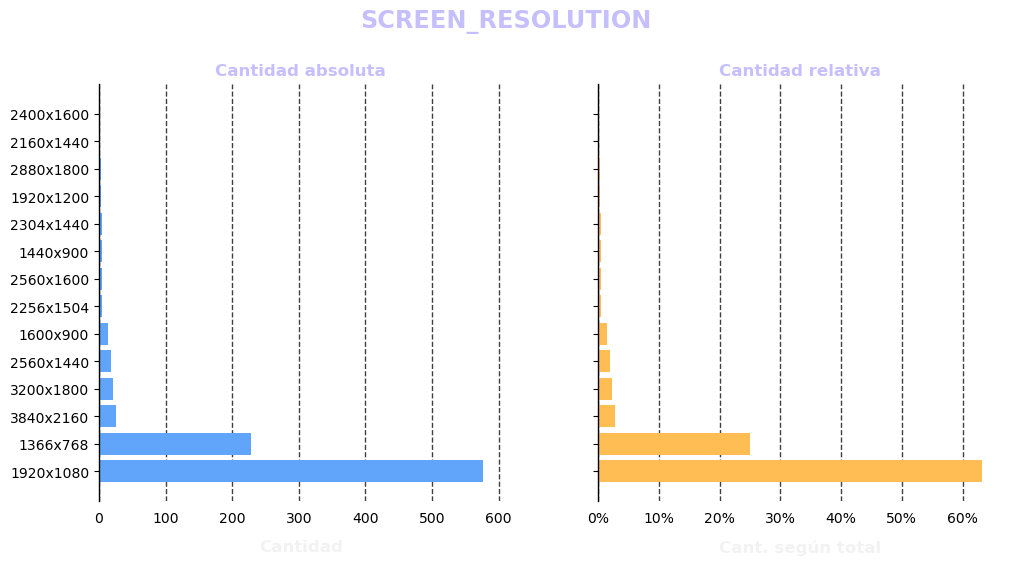

In [55]:
serie = df["screen_resolution"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`CPU`**

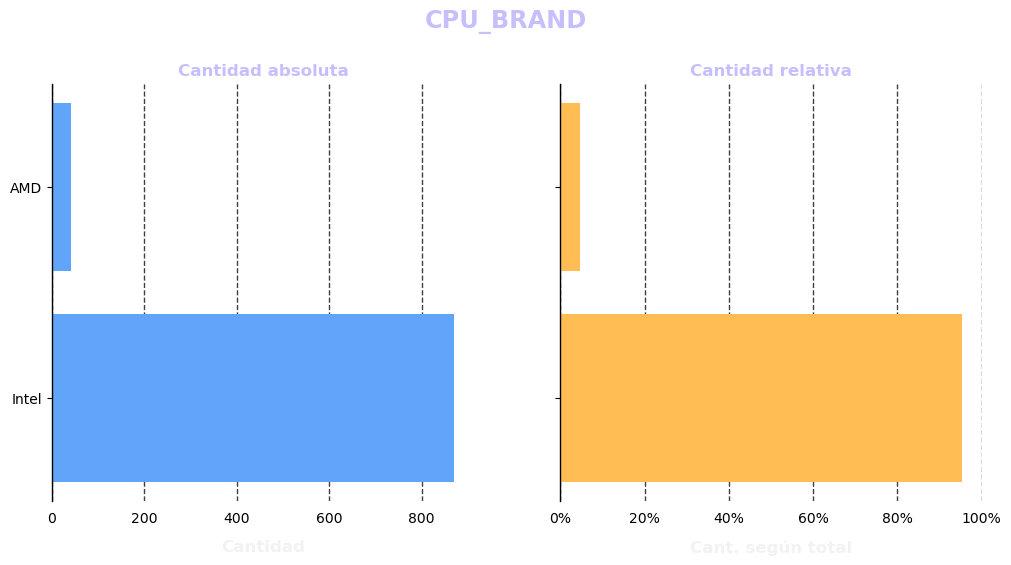

In [56]:
serie = df["cpu_brand"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

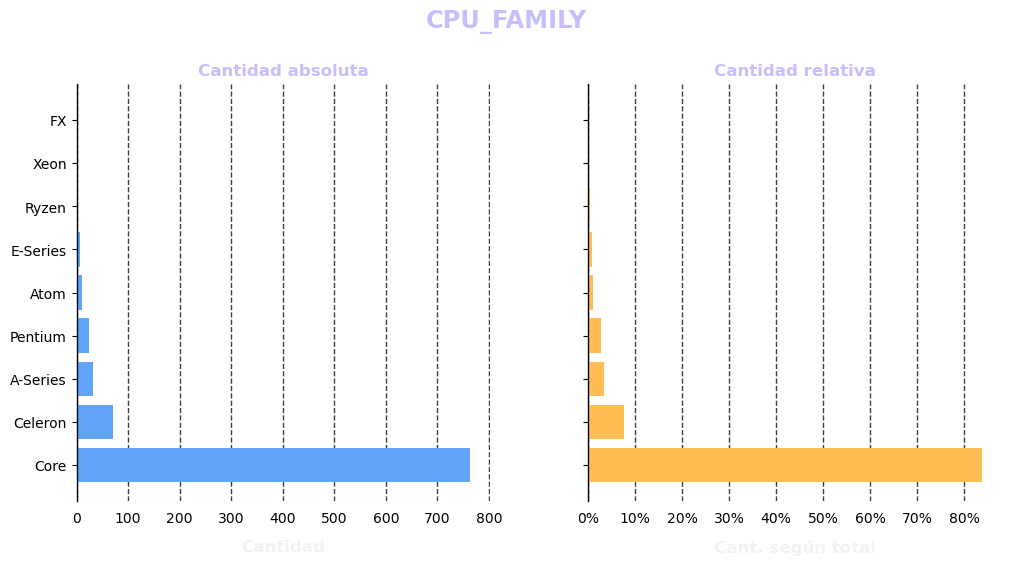

In [57]:
serie = df["cpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

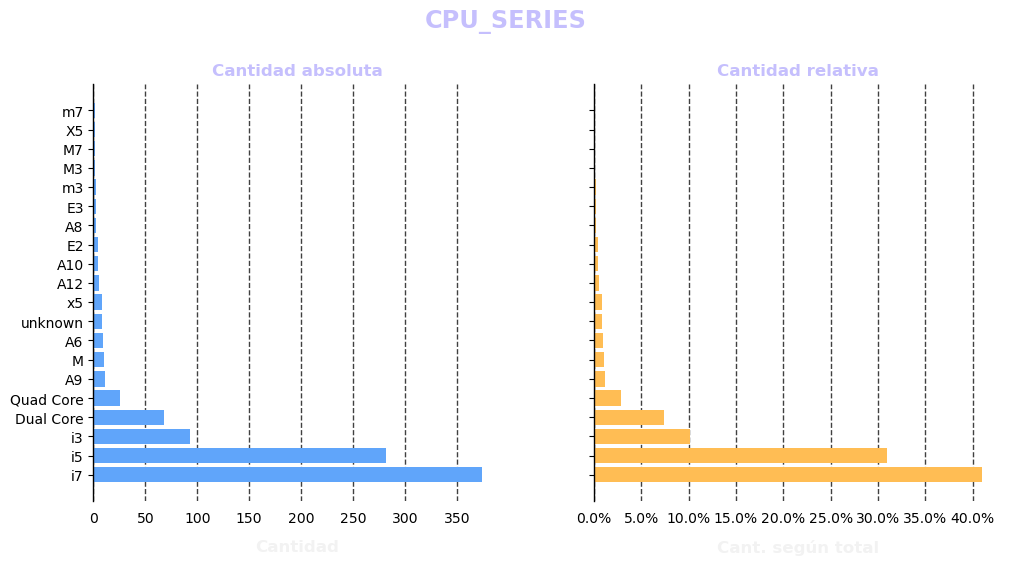

In [58]:
serie = df["cpu_series"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

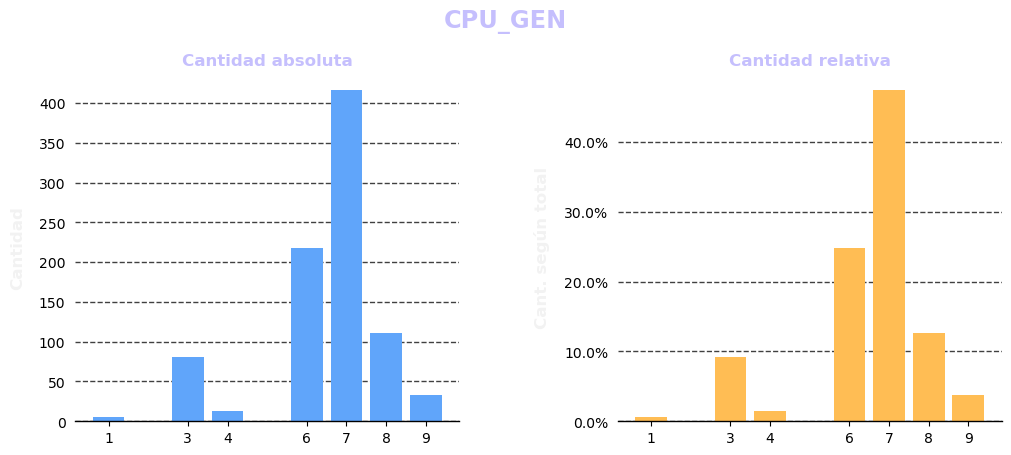

In [59]:
plot_category(df["cpu_gen"])

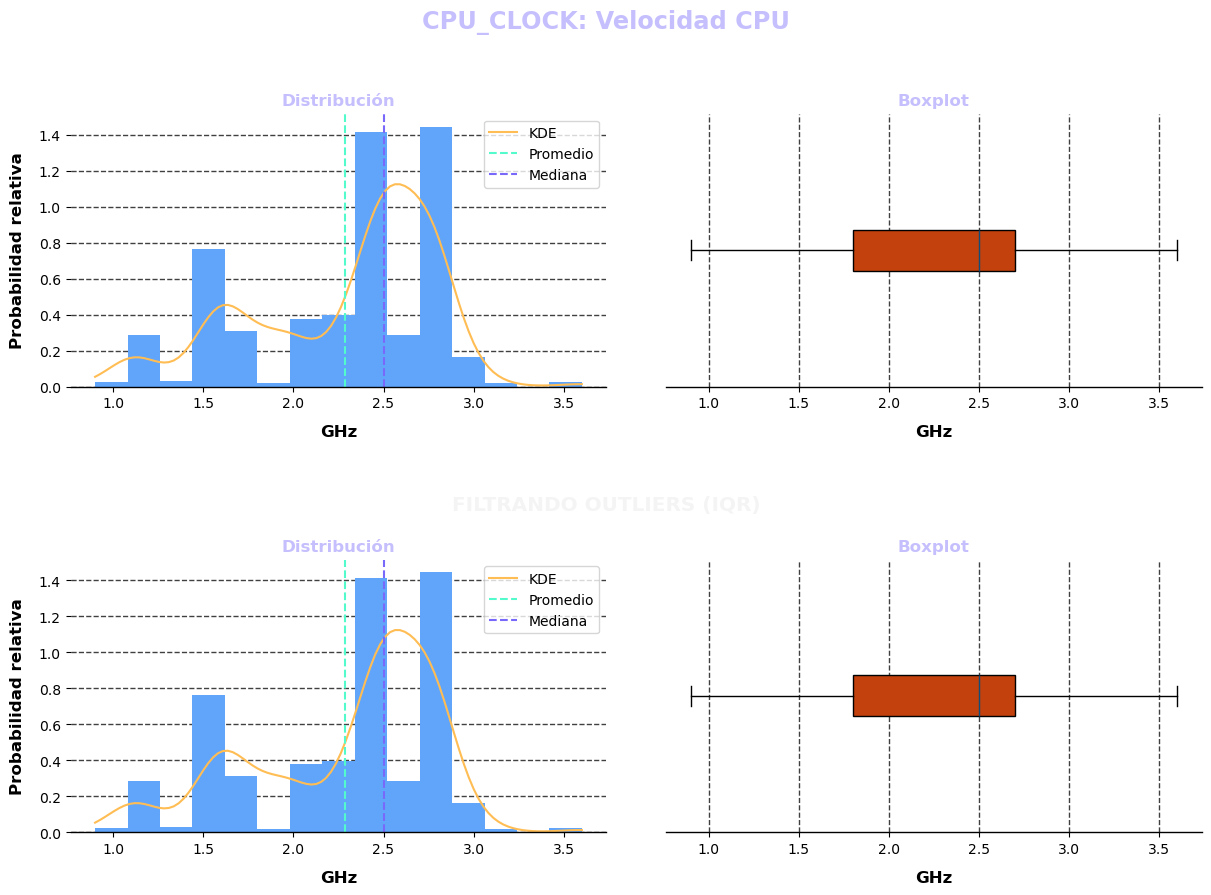

In [60]:
serie = df["cpu_clock"]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}
fig.suptitle(f"{serie.name.upper()}: Velocidad CPU",
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(serie, bins="fd")
axs[0][0].hist(x=serie, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(serie.min(), serie.max(), 100)
kde = stats.gaussian_kde(serie)
axs[0][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[0][0].axvline(serie.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[0][0].axvline(serie.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[0][0].spines[["left", "top", "right"]].set_visible(False)
axs[0][0].spines["bottom"].set_linewidth(1)
axs[0][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)
axs[0][1].boxplot(x=serie,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0][1].set_yticks([])
axs[0][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("")
axs[0][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[0][1].spines[["left", "top", "right"]].set_visible(False)
axs[0][1].spines["bottom"].set_linewidth(1)





font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.text(0.5, 0.48,
		 "FILTRANDO OUTLIERS (IQR)",
		 color="#F4F4F4",
		 va="center",
		 ha="center",
		 fontdict=font_config)

data = filter_outliers(serie, below_zero=False)
font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Distribución", color="#C5BFFD", fontdict=font_config)

bins = np.histogram_bin_edges(data, bins="fd")
axs[1][0].hist(x=data, bins=bins, density=True, color="#60A5FA", zorder=2)

x = np.linspace(data.min(), data.max(), 100)
kde = stats.gaussian_kde(data)
axs[1][0].plot(x, kde(x), color="#FFBD54", label="KDE")

axs[1][0].axvline(data.mean(),
				  linestyle="dashed",
				  color="#52FACC",
				  label="Promedio")
axs[1][0].axvline(data.median(),
				  linestyle="dashed",
				  color="#7969FB",
				  label="Mediana")

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][0].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("Probabilidad relativa", labelpad=10, fontdict=font_config)
axs[1][0].grid(axis="y",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)
axs[1][0].spines[["left", "top", "right"]].set_visible(False)
axs[1][0].spines["bottom"].set_linewidth(1)
axs[1][0].legend()



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Boxplot", color="#C5BFFD", fontdict=font_config)

axs[1][1].boxplot(x=data,
				  boxprops={ "facecolor" : "#C2410C" },
				  medianprops={ "color" : "#0F4D7D" },
				  orientation="horizontal",
				  patch_artist=True)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1][1].set_yticks([])
axs[1][1].set_xlabel("GHz", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("")
axs[1][1].grid(axis="x",
			   alpha=1,
			   color="#404040",
			   linestyle="dashed",
			   linewidth=1)

axs[1][1].spines[["left", "top", "right"]].set_visible(False)
axs[1][1].spines["bottom"].set_linewidth(1)


fig.get_layout_engine().set(hspace=0.25, wspace=0.1)
plt.show()

##### **`RAM`**

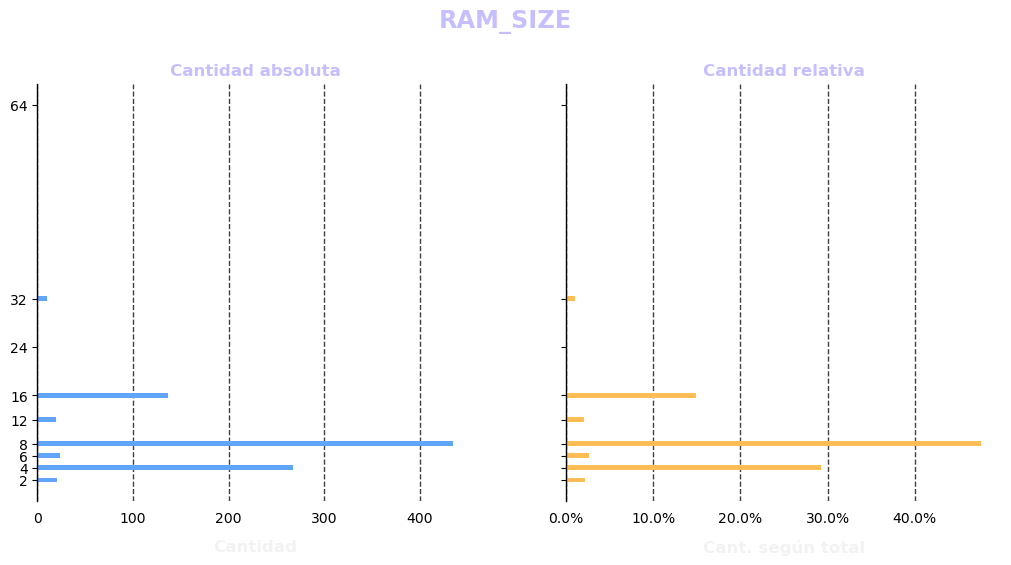

In [61]:
#plot_category(df["ram_size"])
serie = df["ram_size"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

##### **`HDD`**

Una transformación que debemos hacer con la información de `hard drive disc` es homogeneizar las unidades de medida de los datos.

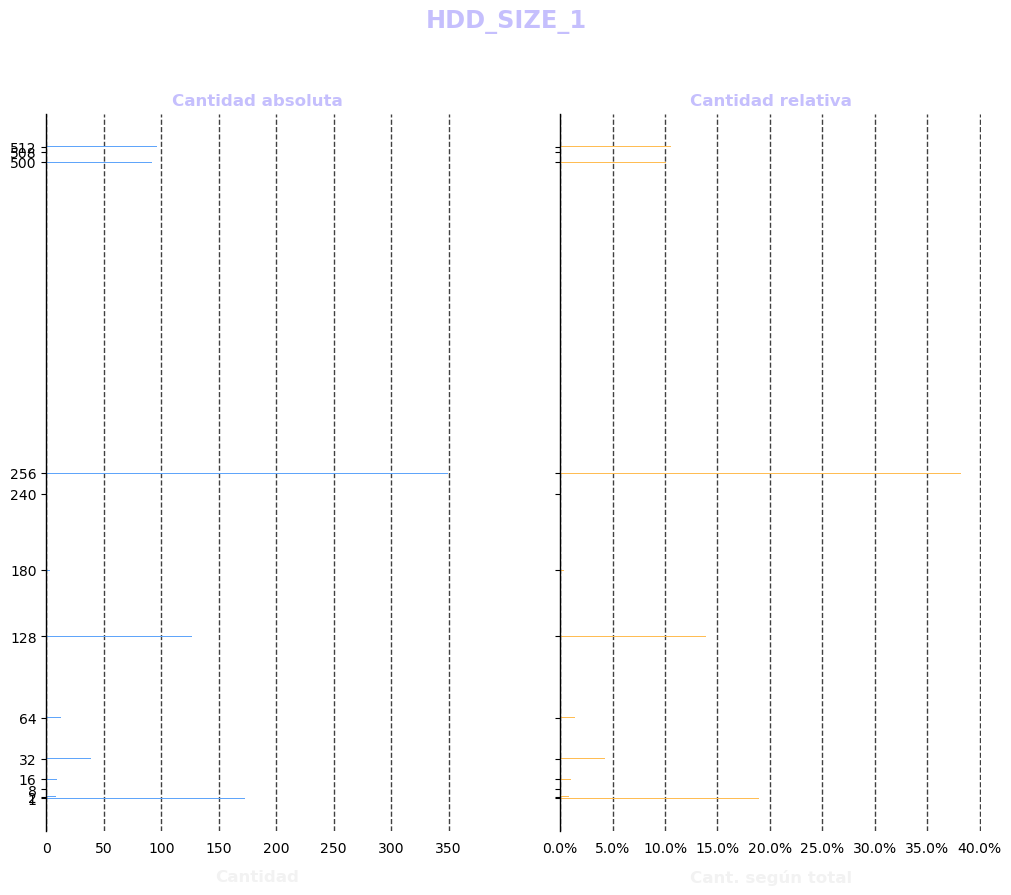

In [62]:
#plot_category(df["hdd_size_1"])
serie = df["hdd_size_1"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

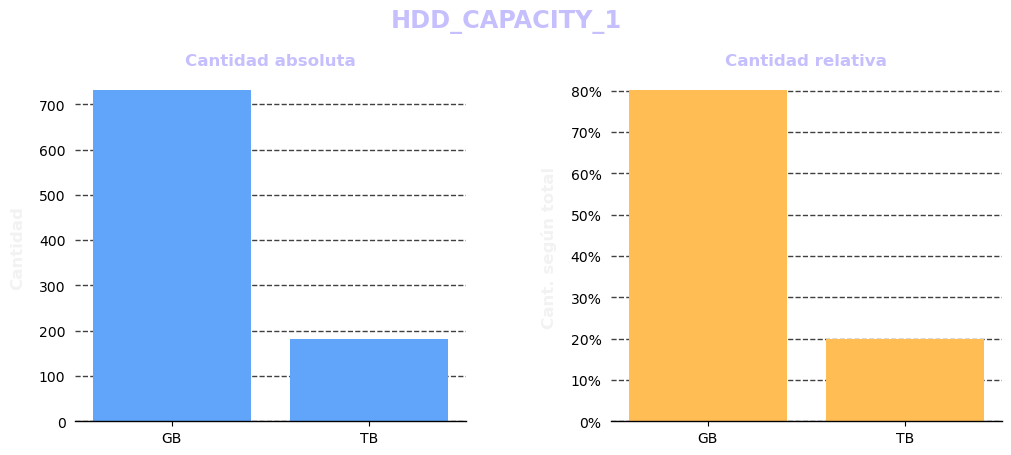

In [63]:
plot_category(df["hdd_capacity_1"])

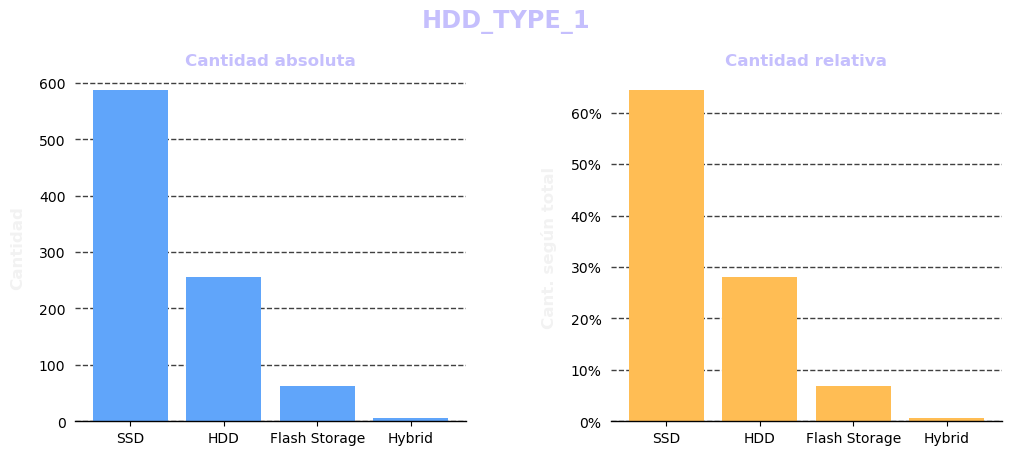

In [64]:
plot_category(df["hdd_type_1"])

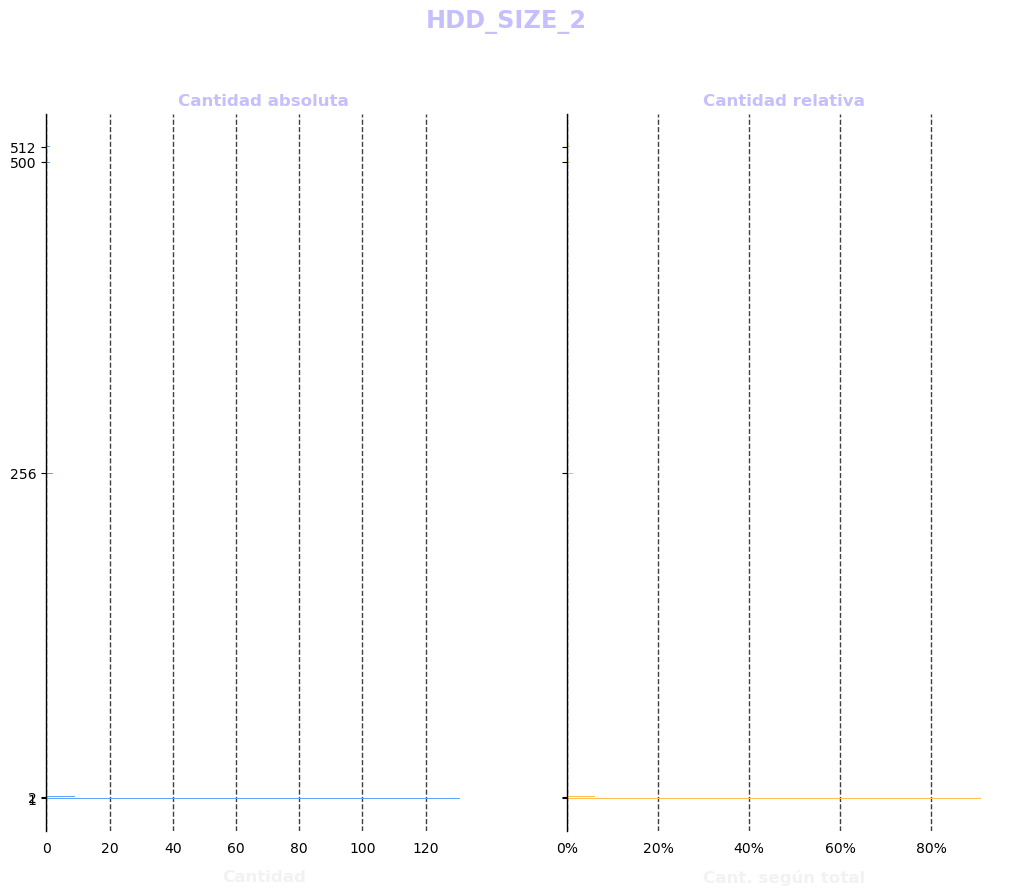

In [65]:
#plot_category(df["hdd_size_2"])
serie = df["hdd_size_2"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 8),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

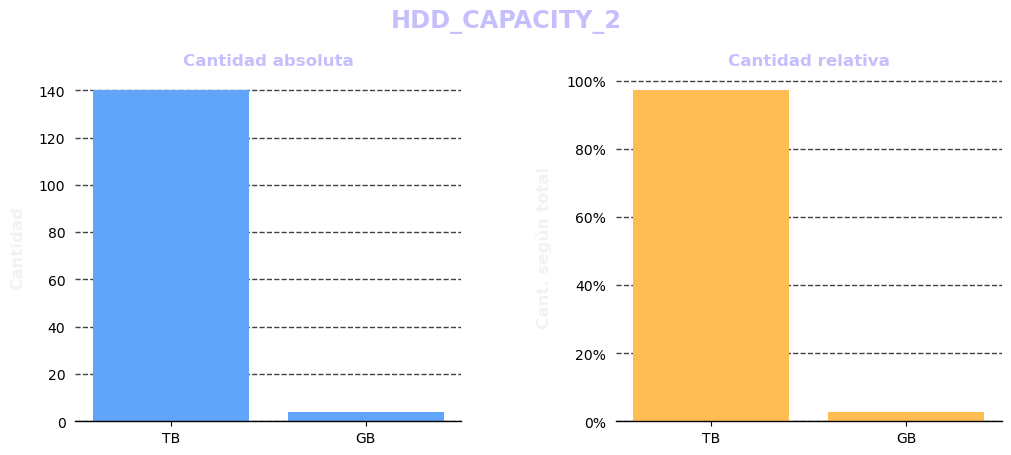

In [66]:
plot_category(df["hdd_capacity_2"])

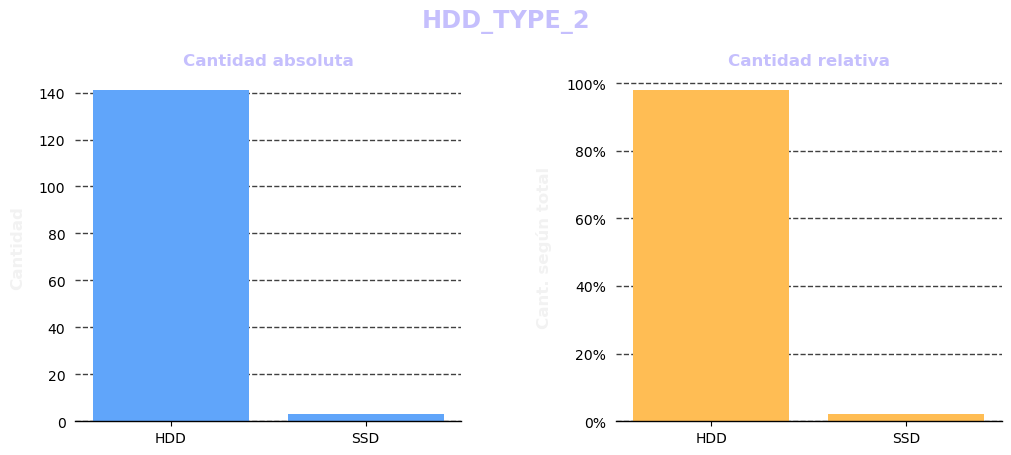

In [67]:
plot_category(df["hdd_type_2"])

##### **`GPU`**

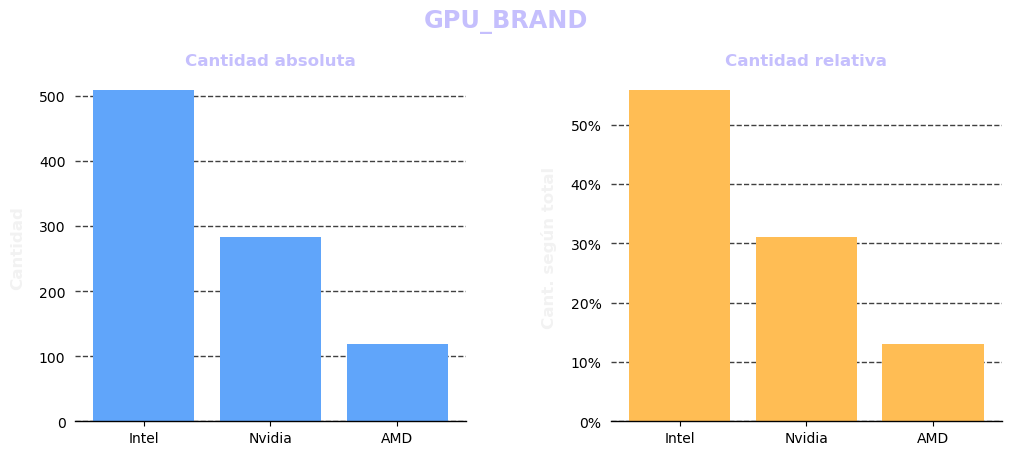

In [68]:
plot_category(df["gpu_brand"])

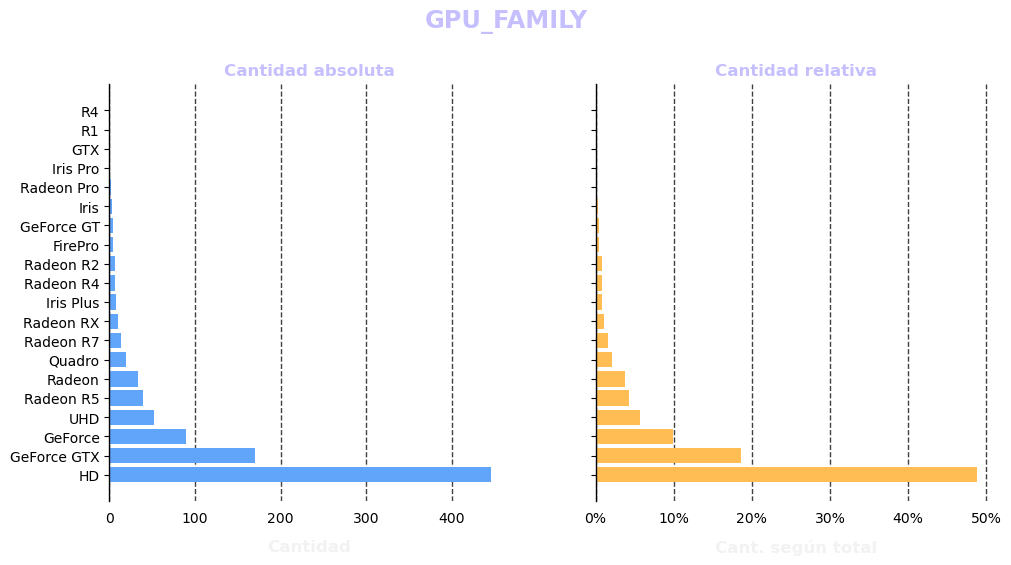

In [69]:
serie = df["gpu_family"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(10, 5),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

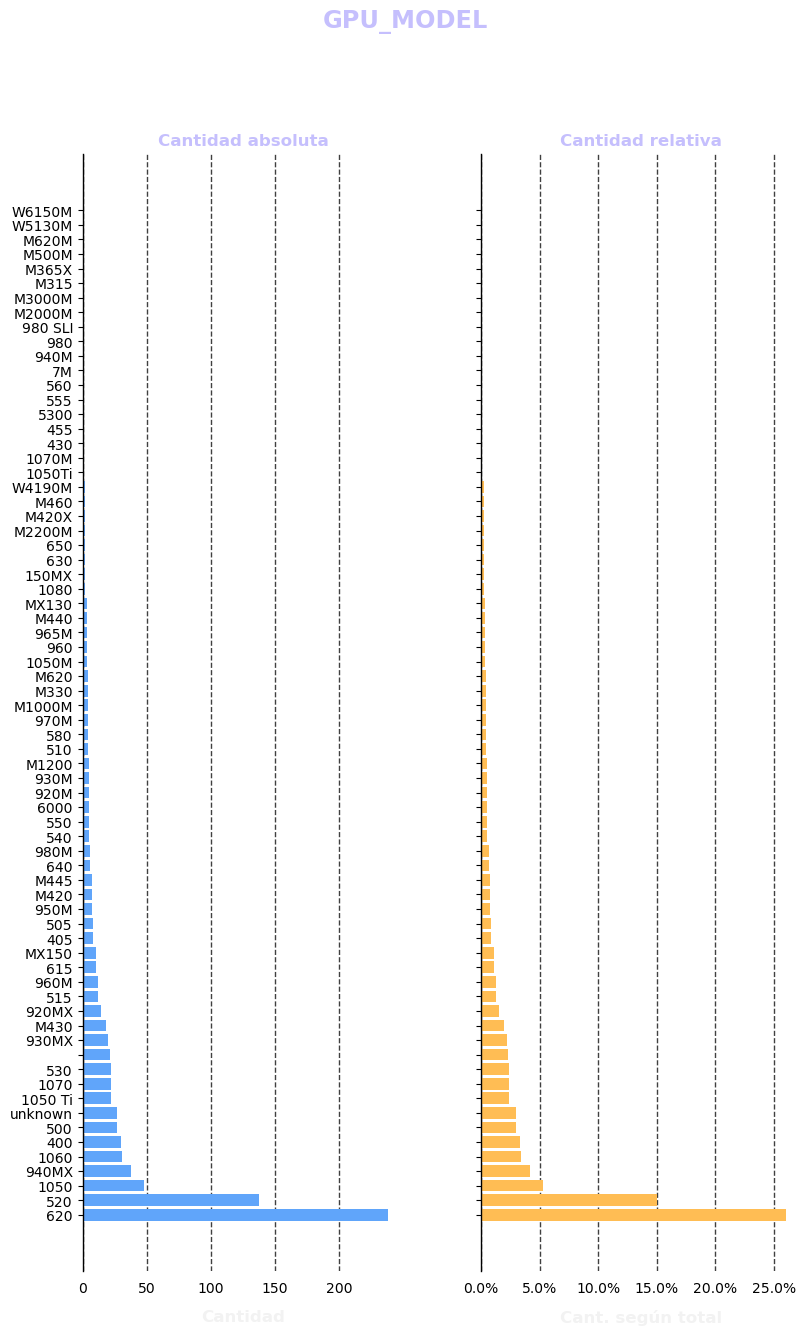

In [70]:
serie = df["gpu_model"]

fig, axs = plt.subplots(nrows=1,
						ncols=2,
						figsize=(8, 12),
						layout="constrained",
						sharey=True)
font_config = {
	"family": "sans-serif",
	"size": "xx-large",
	"weight": "black"
}

fig.suptitle(f"{serie.name}".upper(),
			 color="#C5BFFD",
			 fontproperties=font_config,
			 y=1.10)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Cantidad absoluta", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts()
axs[0].barh(y=data.index,
			width=data.values,
			data=data,
			color="#60A5FA",
			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[0].tick_params(axis="x", width=0)
axs[0].set_yticks(ticks=data.index)
#axs[0].set_xlabel(f"{serie.name}", labelpad=10, fontdict=font_config)

axs[0].set_xlabel("Cantidad",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[0].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)
axs[0].spines[["bottom", "top", "right"]].set_visible(False)
axs[0].spines["left"].set_linewidth(1)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Cantidad relativa", color="#C5BFFD", fontdict=font_config)

data = serie.value_counts(normalize=True)
axs[1].barh(y=data.index,
			width=data.values,
			data=data,
			color="#FFBD54",

			zorder=2)

font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "bold"
}
axs[1].set_yticks(ticks=data.index)
#axs[1].set_xlabel("survived", labelpad=10, fontdict=font_config)

axs[1].set_xlabel("Cant. según total",
				  color="#F2F2F2",
				  labelpad=10,
				  fontdict=font_config)
axs[1].tick_params(axis="x", width=0)
axs[1].xaxis.set_major_formatter(ticker.PercentFormatter(xmax=1))

axs[1].grid(axis="x",
			alpha=1,
			color="#404040",
			linestyle="dashed",
			linewidth=1)

axs[1].spines[["bottom", "top", "right"]].set_visible(False)
axs[1].spines["left"].set_linewidth(1)

fig.get_layout_engine().set(wspace=0.15)
plt.show()

#### Final tweaks

Normalizamos los nombres de los sistemas operativos.

In [71]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

df.replace(maps, inplace=True)

laptop_ID Company             Product            TypeName  Inches  \
0          755      HP              250 G6            Notebook    15.6   
1          618    Dell       Inspiron 7559              Gaming    15.6   
2          909      HP         ProBook 450            Notebook    15.6   
3            2   Apple         Macbook Air           Ultrabook    13.3   
4          286    Dell       Inspiron 3567            Notebook    15.6   
..         ...     ...                 ...                 ...     ...   
907         28    Dell       Inspiron 5570            Notebook    15.6   
908       1160      HP         Spectre Pro  2 in 1 Convertible    13.3   
909         78  Lenovo  IdeaPad 320-15IKBN            Notebook    15.6   
910         23      HP              255 G6            Notebook    15.6   
911        229    Dell        Alienware 17              Gaming    17.3   

       OpSys  Weight  Price_in_euros  has_touchscreen screen_panel  ...  \
0    Windows    1.86          539.00            False          NaN  ...   
1    Windows    2.59          879.01            False          NaN  ...   
2    Windows    2.04          900.00            False          NaN  ...   
3      macOS    1.34          898.94            False          NaN  ...   
4      Linux    2.25          428.00            False          NaN  ...   
..       ...     ...             ...              ...          ...  ...   
907  Windows    2.20          800.00            False          NaN  ...   
908  Windows    1.48         1629.00             True          NaN  ...   
909    No OS    2.20          519.00            False          NaN  ...   
910    No OS    1.86          258.00            False          NaN  ...   
911  Windows    4.42         2456.34            False    IPS Panel  ...   

    ram_capacity hdd_size_1  hdd_capacity_1     hdd_type_1  hdd_size_2  \
0             GB        256              GB            SSD         NaN   
1             GB          1              TB            HDD         NaN   
2             GB          1              TB            HDD         NaN   
3             GB        128              GB  Flash Storage         NaN   
4             GB          1              TB            HDD         NaN   
..           ...        ...             ...            ...         ...   
907           GB        256              GB            SSD         NaN   
908           GB        256              GB            SSD         NaN   
909           GB          2              TB            HDD         NaN   
910           GB        500              GB            HDD         NaN   
911           GB        256              GB            SSD         1.0   

    hdd_capacity_2 hdd_type_2 gpu_brand   gpu_family  gpu_model  
0              NaN        NaN     Intel           HD        520  
1              NaN        NaN    Nvidia  GeForce GTX        960  
2              NaN        NaN    Nvidia      GeForce      930MX  
3              NaN        NaN     Intel           HD       6000  
4              NaN        NaN       AMD    Radeon R5       M430  
..             ...        ...       ...          ...        ...  
907            NaN        NaN       AMD       Radeon        530  
908            NaN        NaN     Intel           HD        520  
909            NaN        NaN     Intel           HD        620  
910            NaN        NaN       AMD    Radeon R2             
911             TB        HDD    Nvidia  GeForce GTX       1060  

[912 rows x 31 columns]

Normalizamos las unidades de medida en los `hard-drive disc`.

In [72]:
factor = {"GB": 1, "TB": 1024}
df["hdd_size_1"] = df["hdd_size_1"] * df["hdd_capacity_1"].map(factor).astype(int)

In [ ]:
df["hdd_size_2"] = df["hdd_size_2"].astype(float)

conditions = [
	df["hdd_capacity_2"].str.lower() == "gb",
	df["hdd_capacity_2"].str.lower() == "tb",
	df["hdd_capacity_2"].isna()
]

choices = [
	df["hdd_size_2"] * 1,
	df["hdd_size_2"] * 1024,
	np.nan
]

df["hdd_size_2"] = np.select(conditions,
							 choices,
							 default=df["hdd_size_2"])

In [74]:
df["hdd_capacity_1"] = df["hdd_capacity_1"].str.replace("TB", "GB")
df["hdd_capacity_2"] = df["hdd_capacity_2"].str.replace("TB", "GB")

Completamos con cero aquellos registros dónde no tenemos un segundo disco duro.

In [ ]:
df.fillna({"hdd_size_2": 0, "hdd_type_2": "unknown"},
		  inplace=True)
df["hdd_type_2"] = df["hdd_type_2"].astype("category")
df["hdd_size_2"] = df["hdd_size_2"].astype(int)

In [76]:
df.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)

In [77]:
df.head().iloc[:, 10:]

screen_type screen_resolution  screen_width  screen_height  screen_ppi  \
0     Full HD         1920x1080          1920           1080      141.21   
1     Full HD         1920x1080          1920           1080      141.21   
2     Full HD         1920x1080          1920           1080      141.21   
3         HD+          1440x900          1440            900      127.68   
4     Full HD         1920x1080          1920           1080      141.21   

  cpu_brand cpu_family cpu_series  cpu_gen  cpu_clock  ram_size  hdd_size_1  \
0     Intel       Core         i3      6.0        2.0         8         256   
1     Intel       Core         i7      6.0        2.6        16        1024   
2     Intel       Core         i7      7.0        2.7         8        1024   
3     Intel       Core         i5      NaN        1.8         8         128   
4     Intel       Core         i3      6.0        2.0         4        1024   

      hdd_type_1  hdd_size_2 hdd_type_2 gpu_brand   gpu_family gpu_model  
0            SSD           0    unknown     Intel           HD       520  
1            HDD           0    unknown    Nvidia  GeForce GTX       960  
2            HDD           0    unknown    Nvidia      GeForce     930MX  
3  Flash Storage           0    unknown     Intel           HD      6000  
4            HDD           0    unknown       AMD    Radeon R5      M430

#### Guardado de datos

Creamos una nueva columna de targetas gráficas integradas y las que no. Normalmente, todas las gráficas de Intel son integradas.

In [78]:
df["gpu_integrated"] = df["gpu_brand"].str.contains("intel", case=False)
df["has_hdd2"] = df["hdd_size_2"] != 0

In [ ]:
df["OpSys"] = df["OpSys"].astype("category")
df["gpu_family"] = df["gpu_family"].astype("category")

In [80]:
df.set_index("laptop_ID", inplace=True)
df.to_csv(path_or_buf=f"{path}/checkpoint.csv", index=True)

### Definir X e y

In [185]:
path = "./data"
#path = "/content/drive/MyDrive/Colab Notebooks/The Bridge/data"
df = pd.read_csv(filepath_or_buffer=f"{path}/checkpoint.csv",
				 index_col="laptop_ID")

In [187]:
df.info()

<class 'pandas.DataFrame'>
Index: 912 entries, 755 to 229
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Company            912 non-null    str    
 1   Product            912 non-null    str    
 2   TypeName           912 non-null    str    
 3   Inches             912 non-null    float64
 4   OpSys              912 non-null    str    
 5   Weight             912 non-null    float64
 6   Price_in_euros     912 non-null    float64
 7   has_touchscreen    912 non-null    bool   
 8   screen_panel       251 non-null    str    
 9   screen_type        912 non-null    str    
 10  screen_resolution  912 non-null    str    
 11  screen_width       912 non-null    int64  
 12  screen_height      912 non-null    int64  
 13  screen_ppi         912 non-null    float64
 14  cpu_brand          912 non-null    str    
 15  cpu_family         912 non-null    str    
 16  cpu_series         912 non-null    str  

X = df.drop(["Price_in_euros"], axis=1)
y = df["Price_in_euros"].copy()

X.shape

y.shape

### Dividir X_train, X_test, y_train, y_test

In [188]:
df.rename(str.lower, axis="columns", inplace=True)
df.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [189]:
target = "price"
df_train, df_test = train_test_split(df, test_size=.2, random_state=42)
df_train

company                         product     typename  inches  \
laptop_ID                                                                
1118           HP                        ZBook 17  Workstation    17.3   
153          Dell                   Inspiron 5577       Gaming    15.6   
275         Apple                     MacBook Pro    Ultrabook    13.3   
1100           HP                   EliteBook 840     Notebook    14.0   
131          Dell                   Inspiron 5770     Notebook    17.3   
...           ...                             ...          ...     ...   
578            HP  14-am079na (N3710/8GB/2TB/W10)     Notebook    14.0   
996        Lenovo               IdeaPad 320-15ABR     Notebook    15.6   
770          Dell                   Latitude 7280    Ultrabook    12.5   
407        Lenovo               IdeaPad 320-15IAP     Notebook    15.6   
418        Lenovo                  Thinkpad T470p    Ultrabook    14.0   

                os  weight    price  has_touchscreen screen_panel screen_type  \
laptop_ID                                                                       
1118       Windows    3.00  2899.00            False    IPS Panel     Full HD   
153        Windows    2.56  1249.26            False          NaN     Full HD   
275          macOS    1.37  1958.90            False    IPS Panel     Quad HD   
1100       Windows    1.54  1030.99            False          NaN     Full HD   
131        Windows    2.80  1396.00            False          NaN     Full HD   
...            ...     ...      ...              ...          ...         ...   
578        Windows    1.94   389.00            False          NaN          HD   
996        Windows    2.20   549.00            False          NaN     Full HD   
770        Windows    1.18  1859.00            False          NaN     Full HD   
407        Windows    2.20   306.00            False          NaN          HD   
418        Windows    1.70  1943.00            False    IPS Panel     Quad HD   

           ... ram_size  hdd_size_1  hdd_type_1  hdd_size_2 hdd_type_2  \
laptop_ID  ...                                                           
1118       ...        8        1024         HDD           0    unknown   
153        ...       16         512         SSD           0    unknown   
275        ...        8         512         SSD           0    unknown   
1100       ...        4         500         HDD           0    unknown   
131        ...       16         256         SSD        2048        HDD   
...        ...      ...         ...         ...         ...        ...   
578        ...        8        2048         HDD           0    unknown   
996        ...        6         256         SSD           0    unknown   
770        ...       16         256         SSD           0    unknown   
407        ...        4        1024         HDD           0    unknown   
418        ...        8         512         SSD           0    unknown   

          gpu_brand   gpu_family  gpu_model  gpu_integrated  has_hdd2  
laptop_ID                                                              
1118            AMD      FirePro     W6150M           False     False  
153          Nvidia  GeForce GTX       1050           False     False  
275           Intel         Iris        550            True     False  
1100          Intel           HD        520            True     False  
131             AMD       Radeon        530           False      True  
...             ...          ...        ...             ...       ...  
578           Intel           HD        405            True     False  
996             AMD       Radeon        530           False     False  
770           Intel           HD        620            True     False  
407           Intel           HD        500            True     False  
418          Nvidia   GeForce GT      940MX           False     False  

[729 rows x 29 columns]

In [190]:
df_train["log_price"] = np.log1p(df_train["price"])

X_train, X_test, y_train, y_test = train_test_split(
	X,
	y,
	test_size=.2,
	random_state=42
)

X_train

### Análisis Multivariante
#### Distribución de `Price` según `Company`

In [88]:
sns.color_palette("Set3")
sns.set_style("whitegrid")

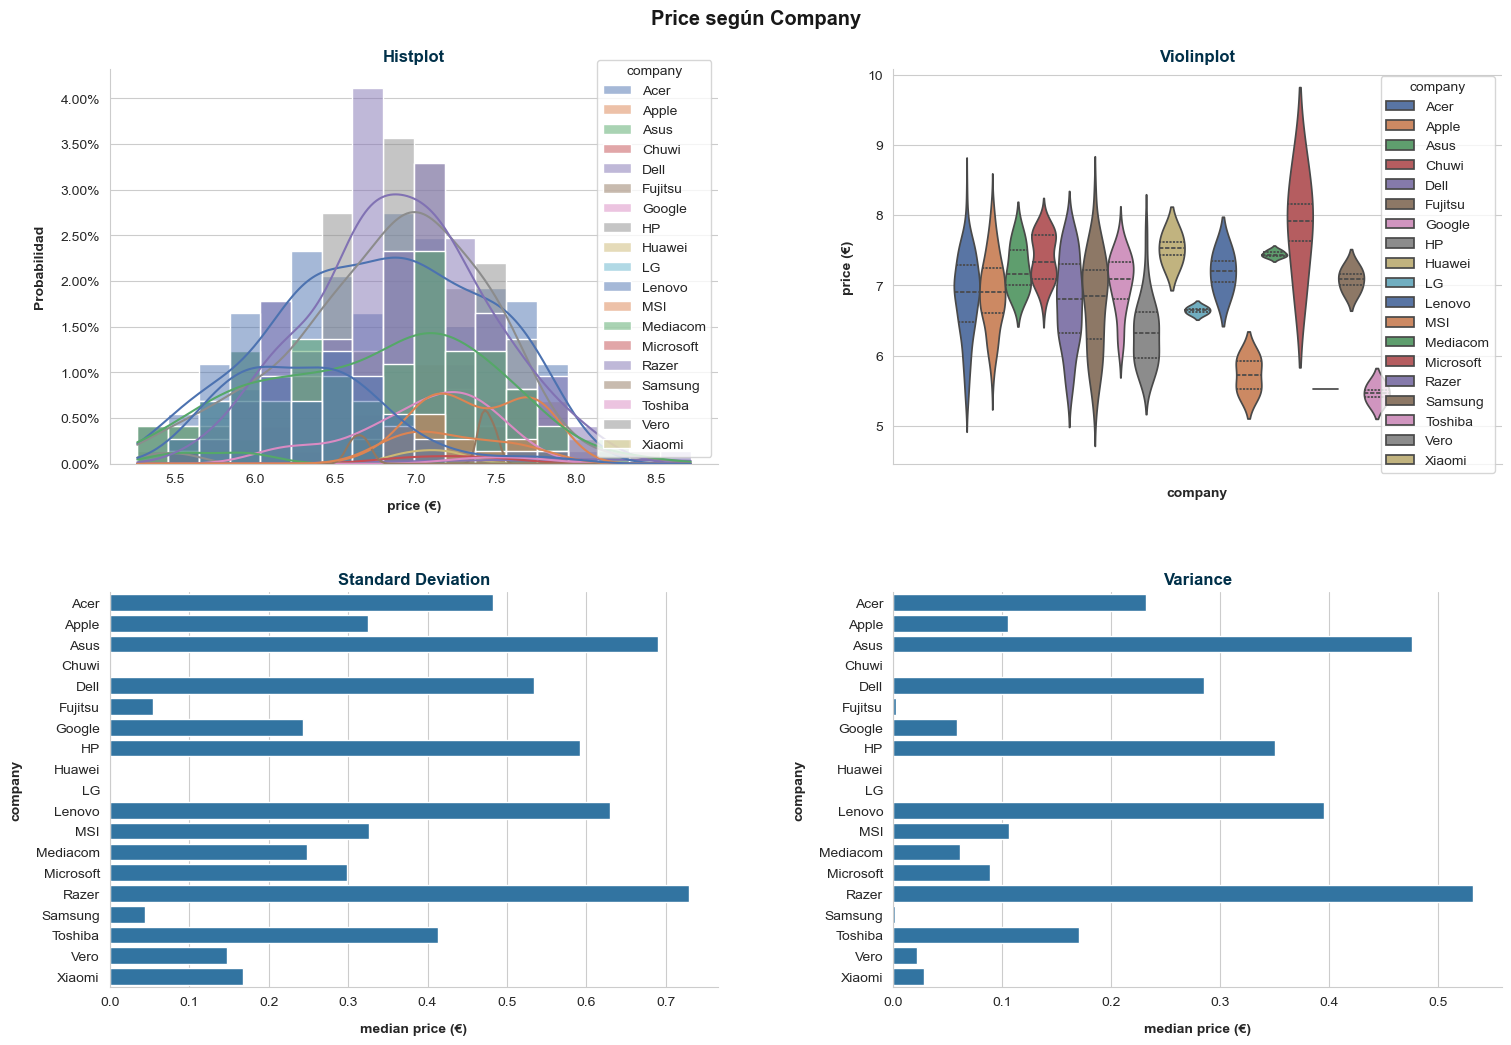

In [89]:
fig, axs = plt.subplots(nrows=2,
						ncols=2,
						figsize=(15, 10),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Company",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="company",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0][0])
sns.despine(ax=axs[0][0])
axs[0][0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0][0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0][0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0][1].set_title("Violinplot", color="#003049", fontdict=font_config)
sns.violinplot(data=df_train,
			   y="log_price",
			   inner="quart",
			   hue="company",
			   palette="deep",
			   ax=axs[0][1])
sns.despine(ax=axs[0][1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0][1].set_xlabel("company", labelpad=10, fontdict=font_config)
axs[0][1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][0].set_title("Standard Deviation",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std"]
).sort_values(by="median")
sns.barplot(data=data,
			x="std",
			y=data.index,
			ax=axs[1][0])
sns.despine(ax=axs[1][0])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][0].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][0].set_ylabel("company", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1][1].set_title("Variance",
					color="#003049",
					fontdict=font_config)
data = df_train.groupby(by="company")["log_price"].agg(
	["count", "mean", "median", "std", "var"]
).sort_values(by="median")
sns.barplot(data=data,
			x="var",
			y=data.index,
			ax=axs[1][1])
sns.despine(ax=axs[1][1])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1][1].set_xlabel("median price (€)", labelpad=10, fontdict=font_config)
axs[1][1].set_ylabel("company", labelpad=10, fontdict=font_config)
fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `company`

In [87]:
df_train.groupby(by="company")["price"].agg(
	["count", "mean", "median", "min", "max", "std", "var"]
).sort_values(by="median")

count         mean    median      min      max          std  \
company                                                                  
Vero           2   235.400000   235.400   210.80   260.00    34.789654   
Chuwi          1   248.900000   248.900   248.90   248.90          NaN   
Mediacom       4   313.000000   312.000   239.00   389.00    76.924205   
Acer          55   634.229091   559.000   269.00  2599.00   404.367320   
Fujitsu        2   769.000000   769.000   739.00   799.00    42.426407   
Lenovo       162  1056.385309   899.000   229.00  2663.00   631.018068   
Asus         101  1063.480693   945.000   191.90  3975.00   718.489103   
Dell         158  1140.946835   992.000   274.90  3659.40   635.673232   
HP           155  1097.500323  1000.000   209.00  4389.00   623.559206   
Toshiba       31  1231.516129  1195.000   447.00  2226.00   445.147981   
Xiaomi         3  1199.616667  1199.000   999.90  1399.95   200.025713   
Apple         13  1455.894615  1279.000   898.94  2439.97   493.007571   
Microsoft      3  1376.000000  1340.000   989.00  1799.00   406.198227   
MSI           30  1699.350333  1528.415   839.00  2729.00   542.454325   
Samsung        3  1715.666667  1699.000  1649.00  1799.00    76.376262   
Google         2  1879.000000  1879.000  1559.00  2199.00   452.548340   
Razer          4  3156.500000  2749.000  1029.00  6099.00  2126.160467   

                    var  
company                  
Vero       1.210320e+03  
Chuwi               NaN  
Mediacom   5.917333e+03  
Acer       1.635129e+05  
Fujitsu    1.800000e+03  
Lenovo     3.981838e+05  
Asus       5.162266e+05  
Dell       4.040805e+05  
HP         3.888261e+05  
Toshiba    1.981567e+05  
Xiaomi     4.001029e+04  
Apple      2.430565e+05  
Microsoft  1.649970e+05  
MSI        2.942567e+05  
Samsung    5.833333e+03  
Google     2.048000e+05  
Razer      4.520558e+06

La notebook más cara sale €6.099 y corresponde a la marca `Razer`. La más económica corresponde a la marca `Asus` y cuesta €191.90.

La mediana de `price` del fabricante `Razer` es la más alta entre los 19 fabricantes de pc que tenemos. De todas maneras, también hay que destacar que solo contamos con 4 registros de dicha marca.

#### Distribución de `Price` según `TypeName`

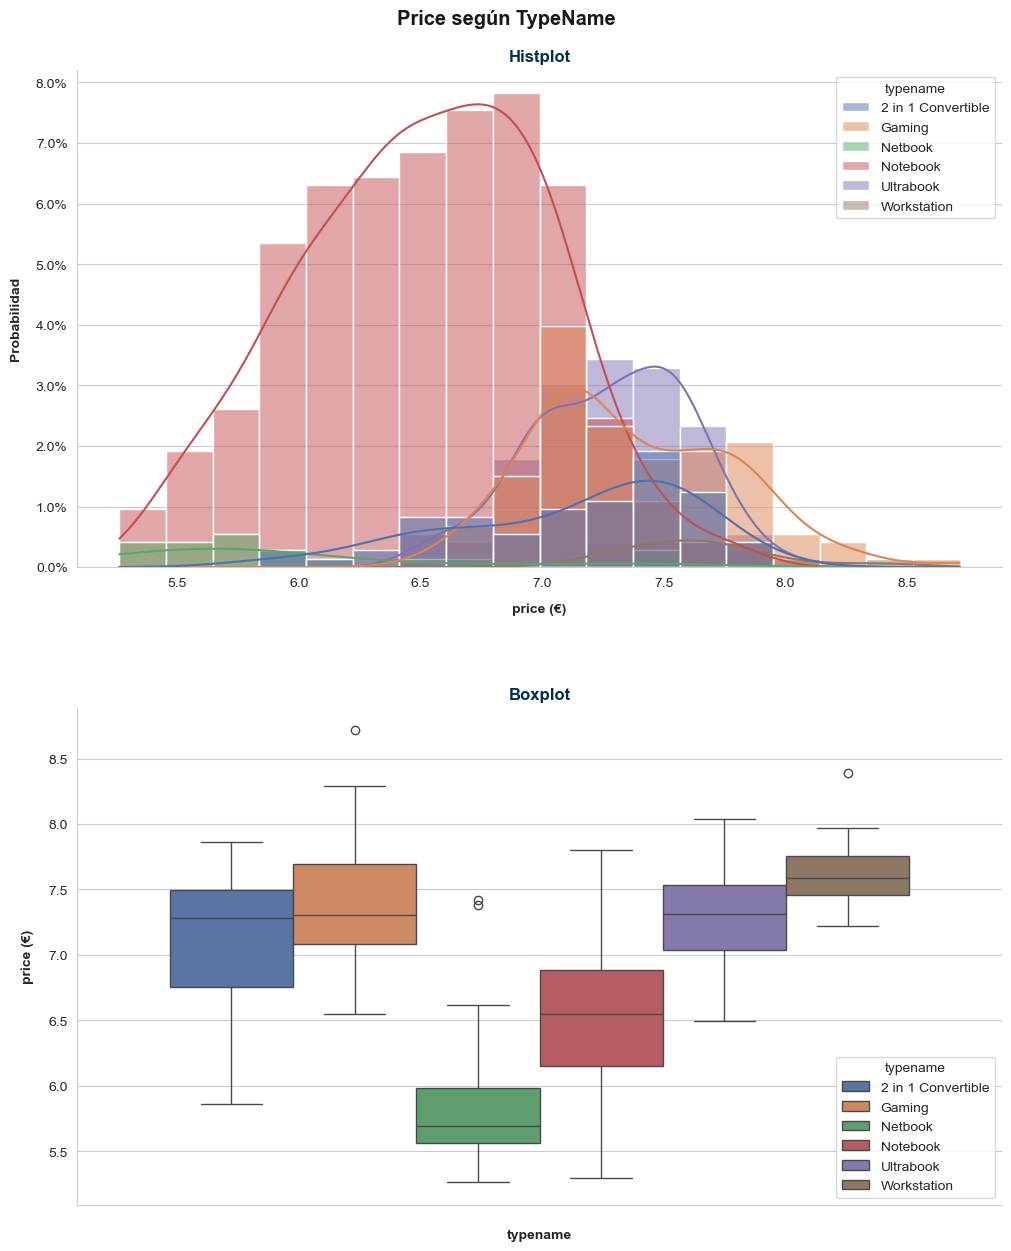

In [90]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según TypeName",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="typename",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="typename",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Estadísticos varios por `typename`.

In [91]:
df_train.groupby(by=["typename"])["price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

count         mean     min     max   median         std  \
typename                                                                      
Netbook                16   487.237500   191.9  1669.0   296.00  466.296466   
Notebook              412   763.803932   199.0  2449.0   698.50  388.203195   
2 in 1 Convertible     62  1379.410968   349.0  2590.0  1449.00  573.410452   
Gaming                113  1731.491593   699.0  6099.0  1486.77  808.943919   
Ultrabook             113  1526.832743   659.0  3100.0  1495.00  473.828464   
Workstation            13  2189.635385  1369.0  4389.0  1975.00  781.652784   

                              var  
typename                           
Netbook             217432.394500  
Notebook            150701.720245  
2 in 1 Convertible  328799.545953  
Gaming              654390.263583  
Ultrabook           224513.412829  
Workstation         610981.075394

Siguiendo lo mencionado anteriormente, la computadora más cara corresponde al segmento `Gaming` y la más económica al segmento `Netbook`.

La mediana es consitente entre `ultrabook`, `gaming` y las `2 in 1 convertible`. A su vez, podemos ver que la desviación estandar al igual que la varianza en las notebooks de `Workstation` y `Gaming` es muy alta.

#### Distribución de `Price` según `Inches`

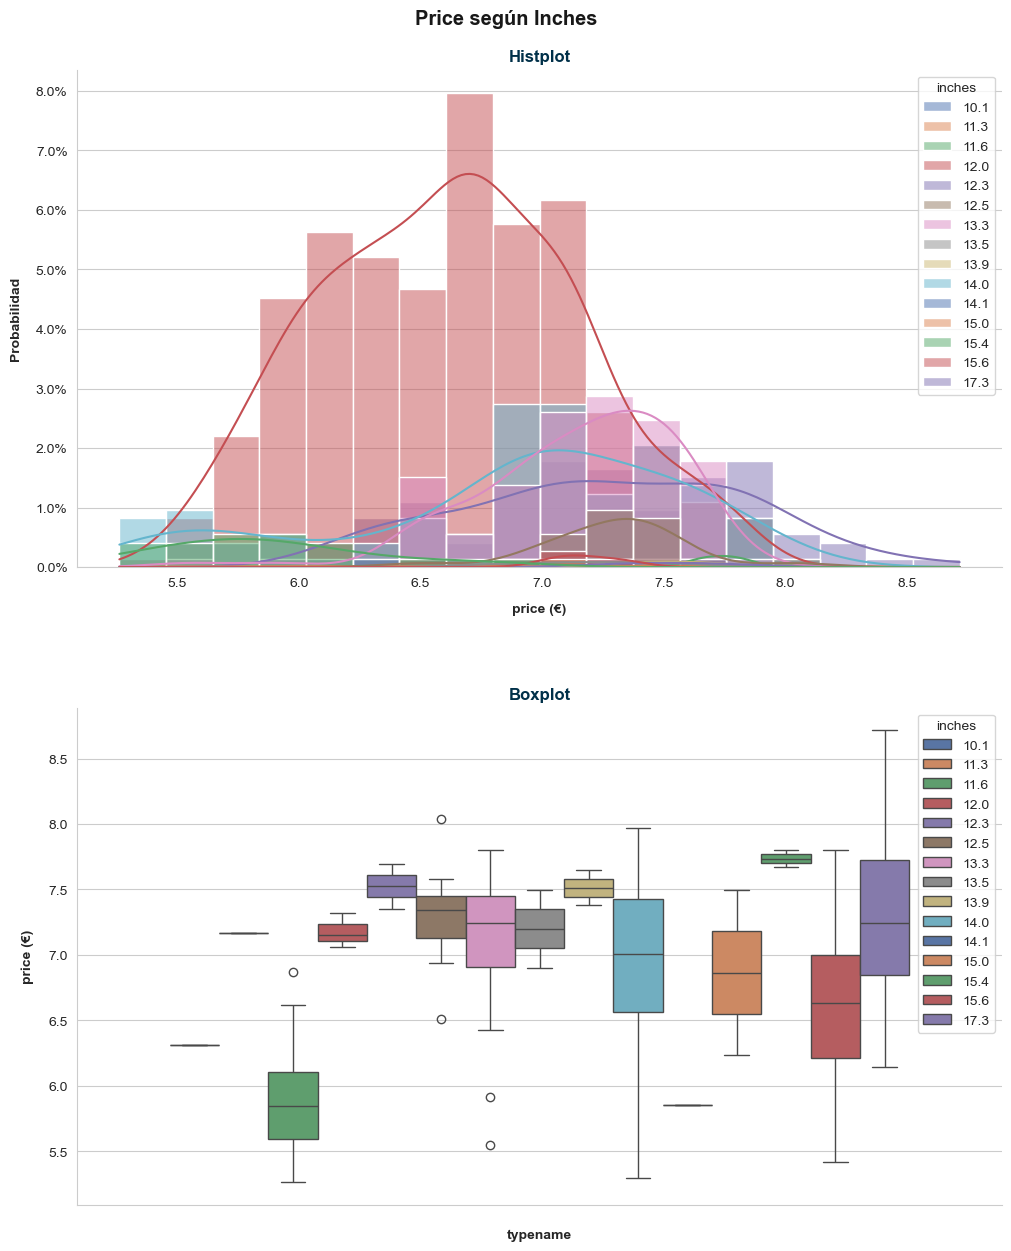

In [92]:
fig, axs = plt.subplots(nrows=2, ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Inches",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="inches",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].grid(axis="x", visible=False)
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="inches",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Al parecer, la distribución del precio de las laptops con pantallas de 17.3" tiene una cola hacía la derecha, dejando entrever que pueden alcanzar precios elevados.

In [93]:
df_train.groupby("inches")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
])

count         mean      min      max   median         std  \
inches                                                              
10.1        1   549.000000   549.00   549.00   549.00         NaN   
11.3        1  1299.000000  1299.00  1299.00  1299.00         NaN   
11.6       20   389.490000   191.90   959.00   344.50  193.101939   
12.0        3  1317.333333  1163.00  1510.00  1279.00  176.647483   
12.3        2  1879.000000  1559.00  2199.00  1879.00  452.548340   
12.5       21  1531.537143   669.00  3100.00  1539.00  472.931775   
13.3       99  1362.704040   255.00  2449.00  1399.00  464.014558   
13.5        3  1376.000000   989.00  1799.00  1340.00  406.198227   
13.9        2  1849.000000  1599.00  2099.00  1849.00  353.553391   
14.0      115  1193.592000   199.00  2899.00  1099.00  664.313713   
14.1        1   348.000000   348.00   348.00   348.00         NaN   
15.0        2  1154.000000   509.00  1799.00  1154.00  912.167748   
15.4        2  2289.970000  2139.97  2439.97  2289.97  212.132034   
15.6      362   855.116077   224.00  2449.00   757.00  467.690547   
17.3       95  1667.027263   466.00  6099.00  1396.00  988.331293   

                  var  
inches                 
10.1              NaN  
11.3              NaN  
11.6     37288.358842  
12.0     31204.333333  
12.3    204800.000000  
12.5    223664.463571  
13.3    215309.509996  
13.5    164997.000000  
13.9    125000.000000  
14.0    441312.709618  
14.1              NaN  
15.0    832050.000000  
15.4     45000.000000  
15.6    218734.448207  
17.3    976798.744256

#### Distribución de `Price` según `OS`

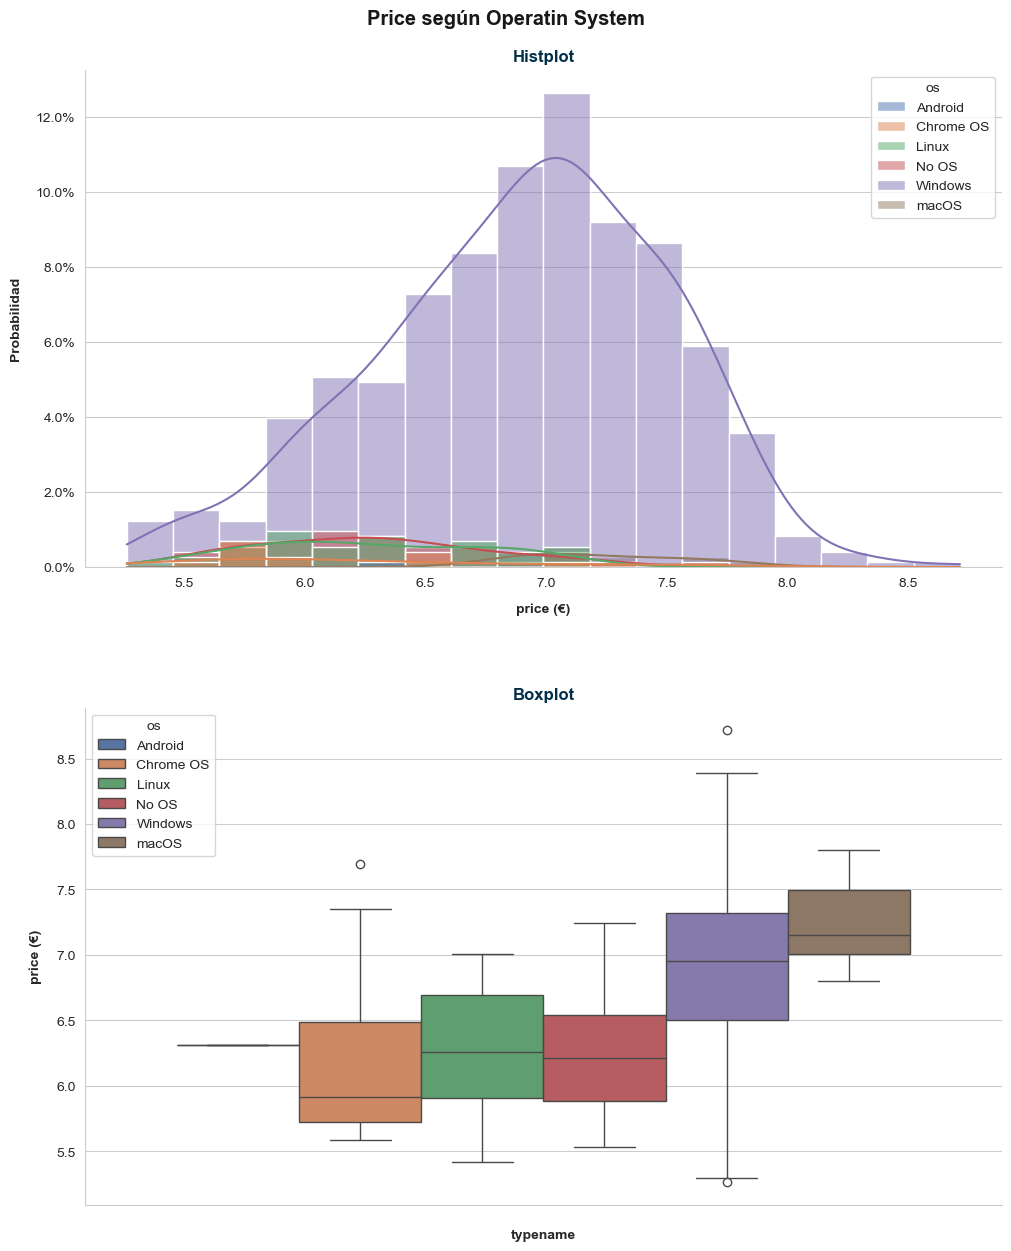

In [94]:
fig, axs = plt.subplots(nrows=2,
						ncols=1,
						figsize=(10, 12),
						layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Operatin System",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[0].set_title("Histplot", color="#003049", fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="os",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs[0])
sns.despine(ax=axs[0])
axs[0].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[0].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs[0].set_ylabel("Probabilidad", labelpad=10, fontdict=font_config)
axs[0].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs[1].set_title("Boxplot", color="#003049", fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="os",
			palette="deep",
			ax=axs[1])
sns.despine(ax=axs[1])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs[1].set_xlabel("typename", labelpad=10, fontdict=font_config)
axs[1].set_ylabel("price (€)", labelpad=10, fontdict=font_config)

fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [95]:
df_train.groupby("os")["price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="median")

count         mean     min      max   median         std  \
os                                                                    
Chrome OS     14   668.278571  265.00  2199.00   370.00  580.327953   
No OS         39   583.784359  252.36  1399.95   499.00  288.226338   
Linux         37   590.808378  224.00  1099.00   522.99  277.387573   
Android        1   549.000000  549.00   549.00   549.00         NaN   
Windows      625  1169.925408  191.90  6099.00  1049.00  680.194166   
macOS         13  1455.894615  898.94  2439.97  1279.00  493.007571   

                     var  
os                        
Chrome OS  336780.532582  
No OS       83074.421815  
Linux       76943.865520  
Android              NaN  
Windows    462664.103107  
macOS      243056.465294

Resulta interesante, aunque no es revelador, como el precio de dispositivos del ecosistema `Apple` tienen una mediana y media de precio más elevado, aunque la desviación estandar al igual que la varianza sea menor.

Esto nos indica claramente que son equipos más caro en relación a otros ecosistemas.


Otra cosa que podemos observar es que aquellos equipos que no poseen sistema operativo tienen unos estadísticos similares al ecosistema `Linux`. Son equipos bastante más económicos. Deberíamos analizar sí en prestaciones las pc poseen gran diferencia respecto a los otros ecosistemas, en caso de no ser así, tal vez, el hecho de tener un so instalado, libre y gratuito, o no pueda influir en el precio.

#### Distribución de `Price` según `Weight`

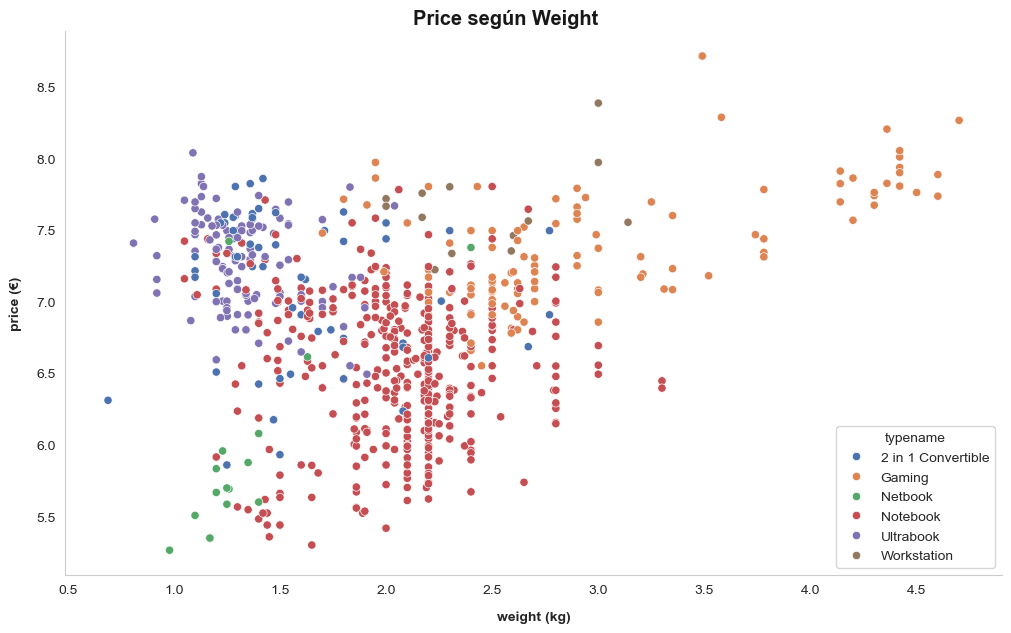

In [96]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("Price según Weight",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x="weight",
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)
ax.grid(axis="both", visible=False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("weight (kg)", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
plt.show()

Las notebooks del segmento `Gaminig` tienden a pesar más que las pertenecientes a otros segmentos. Lo mismo sucede con las `Ultrabook`, que son más ligeras en general. Las `netbooks` son las que menos pesan y las que menos cuestan.

#### Distribución de `Price` según `Screen`

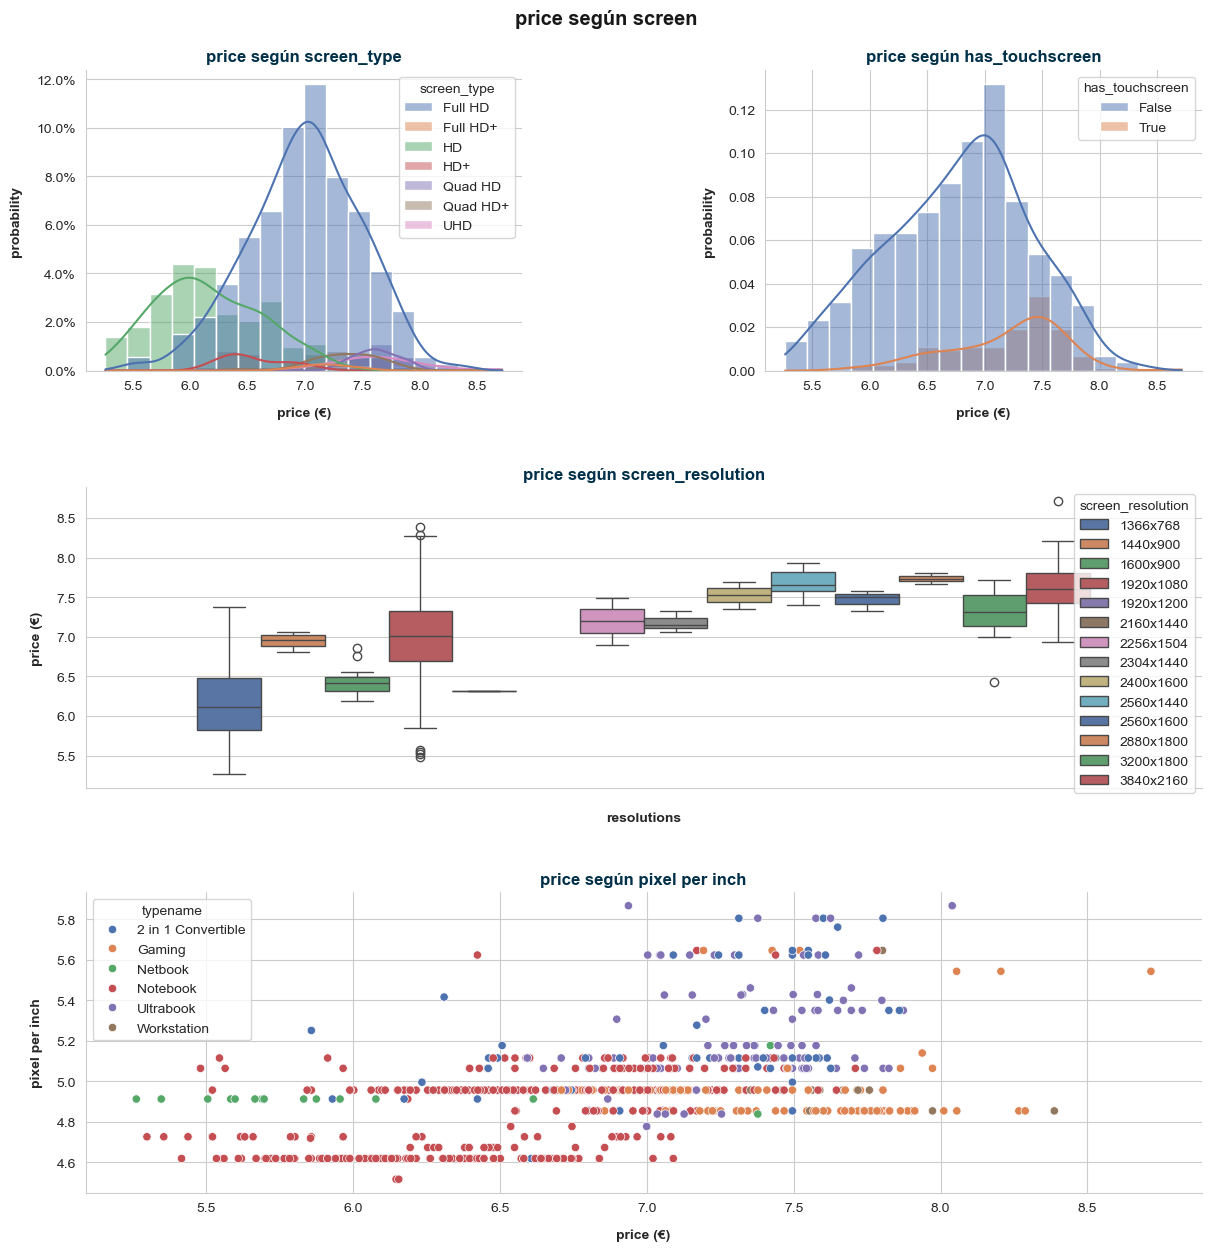

In [97]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["type", "has_touchscreen"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según screen",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["type"].set_title("price según screen_type",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="screen_type",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["type"])
sns.despine(ax=axs["type"])
axs["type"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["type"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["type"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["type"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_touchscreen"].set_title("price según has_touchscreen",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_touchscreen",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_touchscreen"])
sns.despine(ax=axs["has_touchscreen"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_touchscreen"].set_xlabel("price (€)",
								  labelpad=10,
								  fontdict=font_config)
axs["has_touchscreen"].set_ylabel("probability",
								  labelpad=10,
								  fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según screen_resolution",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="screen_resolution",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("resolutions",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según pixel per inch",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y=np.log1p(df["screen_ppi"]),
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("pixel per inch", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

In [98]:
df_train.groupby("screen_ppi")["log_price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="screen_ppi")

count      mean       min       max    median       std       var
screen_ppi                                                                   
90.58           2  6.150954  6.146329  6.155580  6.150954  0.006541  0.000043
100.45        121  6.175765  5.416100  7.090077  6.131226  0.358134  0.128260
106.11         14  6.443637  6.194405  6.856462  6.420491  0.184779  0.034143
111.14          1  5.855072  5.855072  5.855072  5.855072       NaN       NaN
111.94         28  6.062256  5.298317  7.081709  5.830026  0.622908  0.388015
117.83          3  6.760450  6.536692  6.999422  6.745236  0.231740  0.053704
125.37          5  7.171464  7.035401  7.377759  7.126891  0.142890  0.020418
127.34         75  7.387235  6.551080  8.387085  7.343840  0.432355  0.186931
127.68          4  6.942016  6.802328  7.055917  6.954910  0.111738  0.012485
135.09         19  5.875295  5.262172  6.866933  5.831882  0.435169  0.189372
141.21        232  6.810056  5.521061  7.803843  6.802950  0.433025  0.187510
146.86          2  6.864976  6.234411  7.495542  6.864976  0.891754  0.795226
157.35         76  7.078614  5.480639  7.972466  7.060393  0.471239  0.222066
158.48          1  7.377759  7.377759  7.377759  7.377759       NaN       NaN
165.63         62  7.071510  5.545177  7.708411  7.156954  0.419227  0.175751
169.78          1  7.937375  7.937375  7.937375  7.937375       NaN       NaN
176.23         14  7.308157  6.507278  7.576097  7.366760  0.267387  0.071496
189.91          1  5.857933  5.857933  5.857933  5.857933       NaN       NaN
194.95          1  7.170120  7.170120  7.170120  7.170120       NaN       NaN
200.84          3  7.198139  6.897705  7.495542  7.201171  0.298930  0.089359
209.80         11  7.650108  7.401231  7.873217  7.649693  0.163841  0.026844
220.53          2  7.734583  7.669014  7.800151  7.734583  0.092728  0.008598
220.84          1  7.621685  7.621685  7.621685  7.621685       NaN       NaN
224.17          1  6.309918  6.309918  6.309918  6.309918       NaN       NaN
226.42          3  7.178253  7.059618  7.320527  7.154615  0.132051  0.017437
226.98          3  7.468304  7.326170  7.580649  7.498094  0.129829  0.016856
234.51          2  7.524327  7.352441  7.696213  7.524327  0.243083  0.059089
254.67          3  8.325337  8.054640  8.716044  8.205328  0.346649  0.120166
276.05         20  7.296480  6.423247  7.720905  7.313220  0.294122  0.086508
282.42          9  7.524817  7.170120  7.802209  7.520776  0.239052  0.057146
316.97          1  7.649693  7.649693  7.649693  7.649693       NaN       NaN
331.26          6  7.549484  7.313220  7.803843  7.588244  0.178397  0.031825
352.47          2  7.488397  6.937314  8.039480  7.488397  0.779349  0.607385

Podemos ver que existe correlación entre los `pixel per inch` y el `price` del dispositivo. También se puede observar como aquellos equipos que tiene pantalla táctil tienen un precio más eleveda por lo general.

#### Distribución de `Price` según `CPU`

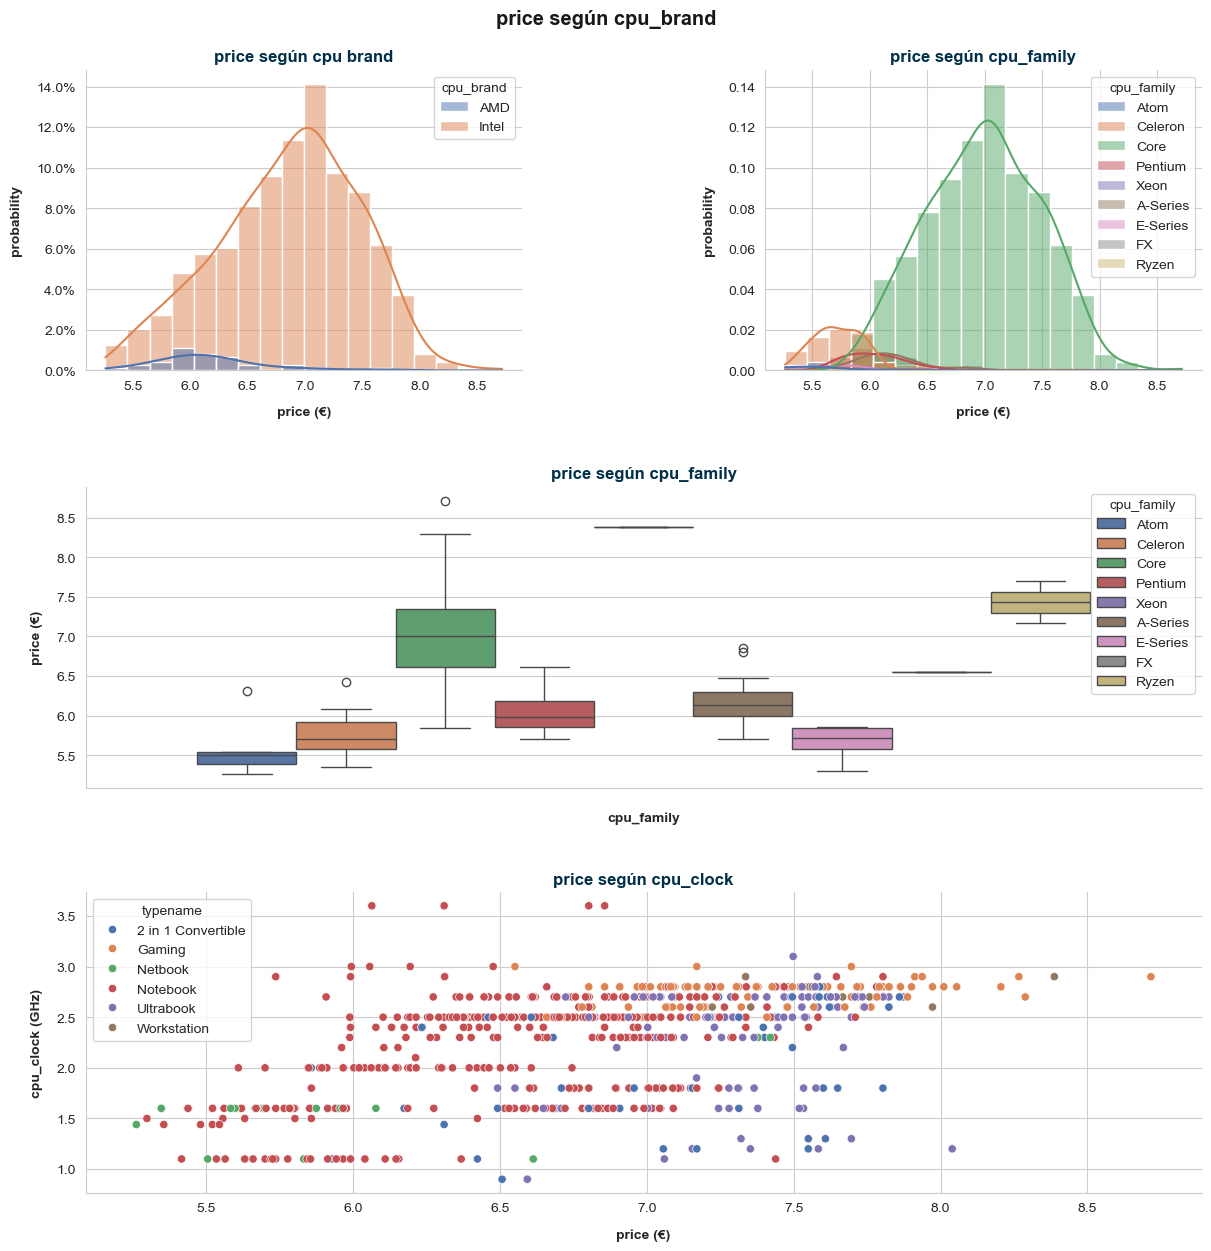

In [99]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "family"],
	["resolution", "resolution"],
	["ppi", "ppi"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_brand",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según cpu brand",
					color="#003049",
					fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)



font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según cpu_family",
								 color="#003049",
								 fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="cpu_family",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["family"])
sns.despine(ax=axs["family"])
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["resolution"].set_title("price según cpu_family",
							color="#003049",
							fontdict=font_config)
sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_family",
			palette="deep",
			ax=axs["resolution"])
sns.despine(ax=axs["resolution"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["resolution"].set_xlabel("cpu_family",
							 labelpad=10,
							 fontdict=font_config)
axs["resolution"].set_ylabel("price (€)",
							 labelpad=10,
							 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["ppi"].set_title("price según cpu_clock",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				y="cpu_clock",
				x="log_price",
				hue="typename",
				palette="deep",
				ax=axs["ppi"])
sns.despine(ax=axs["ppi"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["ppi"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["ppi"].set_ylabel("cpu_clock (GHz)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.12, wspace=0.1)
plt.show()

Aquí podemos observar que existe una correlación entre el `price` del dispositivo y la velocidad del procesador `cpu_clock`. También podemos notar como el fabricante del cpu al igual que la familia del mismo tiene una influencia en el precio.

In [100]:
df_train.groupby("screen_ppi")["log_price"].agg([
	"count", "mean", "min", "max", "median", "std", "var"
]).sort_values(by="screen_ppi")

count      mean       min       max    median       std       var
screen_ppi                                                                   
90.58           2  6.150954  6.146329  6.155580  6.150954  0.006541  0.000043
100.45        121  6.175765  5.416100  7.090077  6.131226  0.358134  0.128260
106.11         14  6.443637  6.194405  6.856462  6.420491  0.184779  0.034143
111.14          1  5.855072  5.855072  5.855072  5.855072       NaN       NaN
111.94         28  6.062256  5.298317  7.081709  5.830026  0.622908  0.388015
117.83          3  6.760450  6.536692  6.999422  6.745236  0.231740  0.053704
125.37          5  7.171464  7.035401  7.377759  7.126891  0.142890  0.020418
127.34         75  7.387235  6.551080  8.387085  7.343840  0.432355  0.186931
127.68          4  6.942016  6.802328  7.055917  6.954910  0.111738  0.012485
135.09         19  5.875295  5.262172  6.866933  5.831882  0.435169  0.189372
141.21        232  6.810056  5.521061  7.803843  6.802950  0.433025  0.187510
146.86          2  6.864976  6.234411  7.495542  6.864976  0.891754  0.795226
157.35         76  7.078614  5.480639  7.972466  7.060393  0.471239  0.222066
158.48          1  7.377759  7.377759  7.377759  7.377759       NaN       NaN
165.63         62  7.071510  5.545177  7.708411  7.156954  0.419227  0.175751
169.78          1  7.937375  7.937375  7.937375  7.937375       NaN       NaN
176.23         14  7.308157  6.507278  7.576097  7.366760  0.267387  0.071496
189.91          1  5.857933  5.857933  5.857933  5.857933       NaN       NaN
194.95          1  7.170120  7.170120  7.170120  7.170120       NaN       NaN
200.84          3  7.198139  6.897705  7.495542  7.201171  0.298930  0.089359
209.80         11  7.650108  7.401231  7.873217  7.649693  0.163841  0.026844
220.53          2  7.734583  7.669014  7.800151  7.734583  0.092728  0.008598
220.84          1  7.621685  7.621685  7.621685  7.621685       NaN       NaN
224.17          1  6.309918  6.309918  6.309918  6.309918       NaN       NaN
226.42          3  7.178253  7.059618  7.320527  7.154615  0.132051  0.017437
226.98          3  7.468304  7.326170  7.580649  7.498094  0.129829  0.016856
234.51          2  7.524327  7.352441  7.696213  7.524327  0.243083  0.059089
254.67          3  8.325337  8.054640  8.716044  8.205328  0.346649  0.120166
276.05         20  7.296480  6.423247  7.720905  7.313220  0.294122  0.086508
282.42          9  7.524817  7.170120  7.802209  7.520776  0.239052  0.057146
316.97          1  7.649693  7.649693  7.649693  7.649693       NaN       NaN
331.26          6  7.549484  7.313220  7.803843  7.588244  0.178397  0.031825
352.47          2  7.488397  6.937314  8.039480  7.488397  0.779349  0.607385

> No le hemos podido sacar demasiado partido a la generación del `cpu`. Como una posible línea de trabajo futura, es algo a lo que se le debería hacer foco para conseguir un mejor rendimiento del modelo.

In [101]:
df_train["cpu_gen"].isna().value_counts()

cpu_gen
False    702
True      27
Name: count, dtype: int64

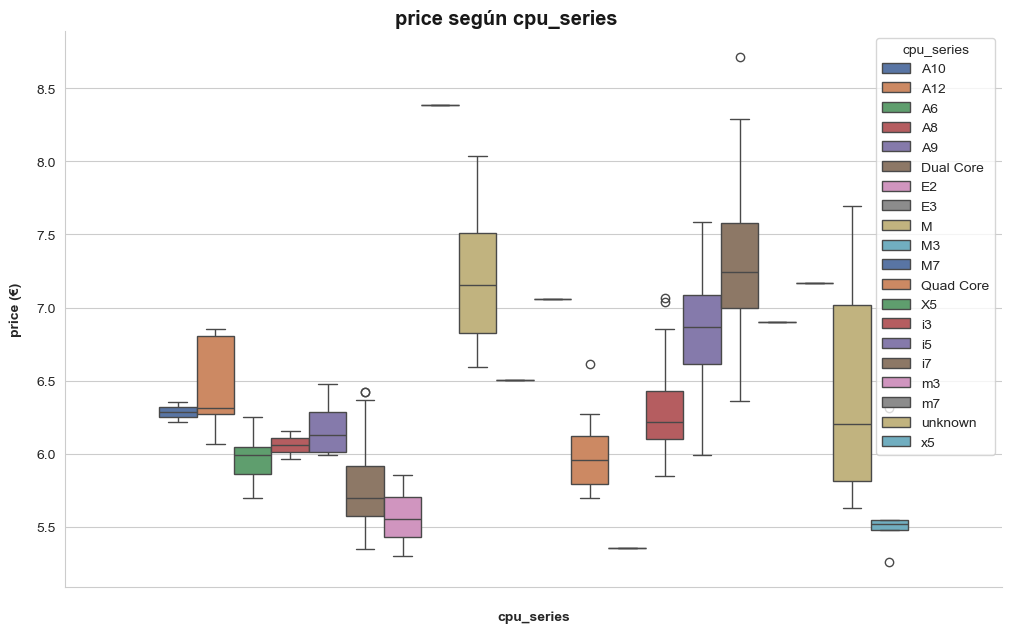

In [102]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según cpu_series",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


sns.boxplot(data=df_train,
			y="log_price",
			hue="cpu_series",
			palette="deep",
			ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("cpu_series", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

#### Distribución de `Price` según `RAM`

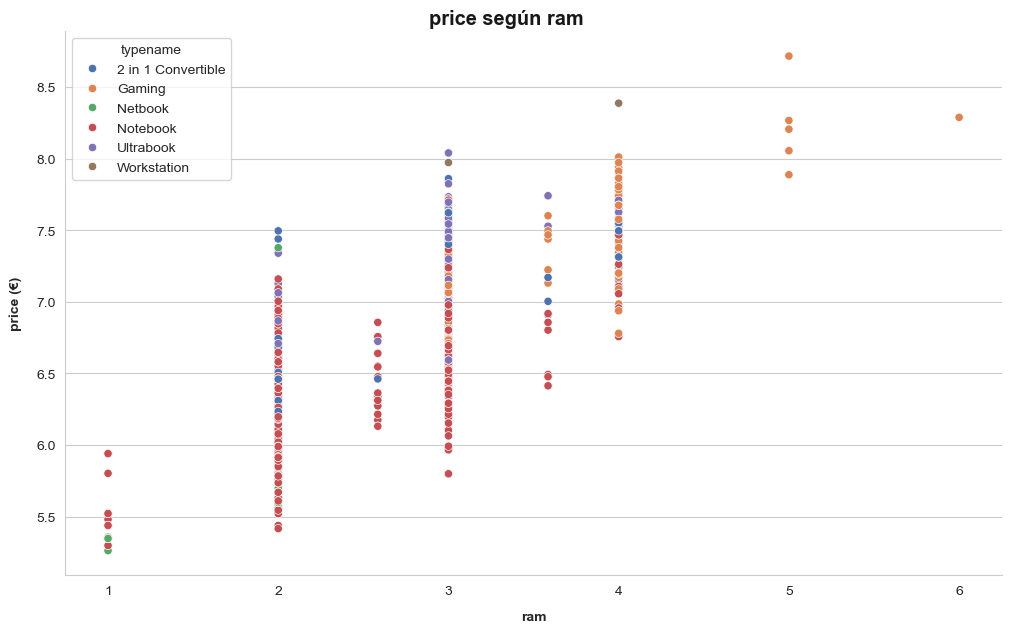

In [103]:
fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según ram",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)

sns.scatterplot(data=df_train,
				x=np.log2(df["ram_size"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=ax)
sns.despine(ax=ax)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
ax.set_xlabel("ram", labelpad=10, fontdict=font_config)
ax.set_ylabel("price (€)", labelpad=10, fontdict=font_config)
ax.grid(axis="x", visible=False)
plt.show()

Podemos observar que hay una correlación muy fuerte entre la cantidad de memoria del dispositivo y su precio.

#### Distribución de `Price` según `HDD`

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


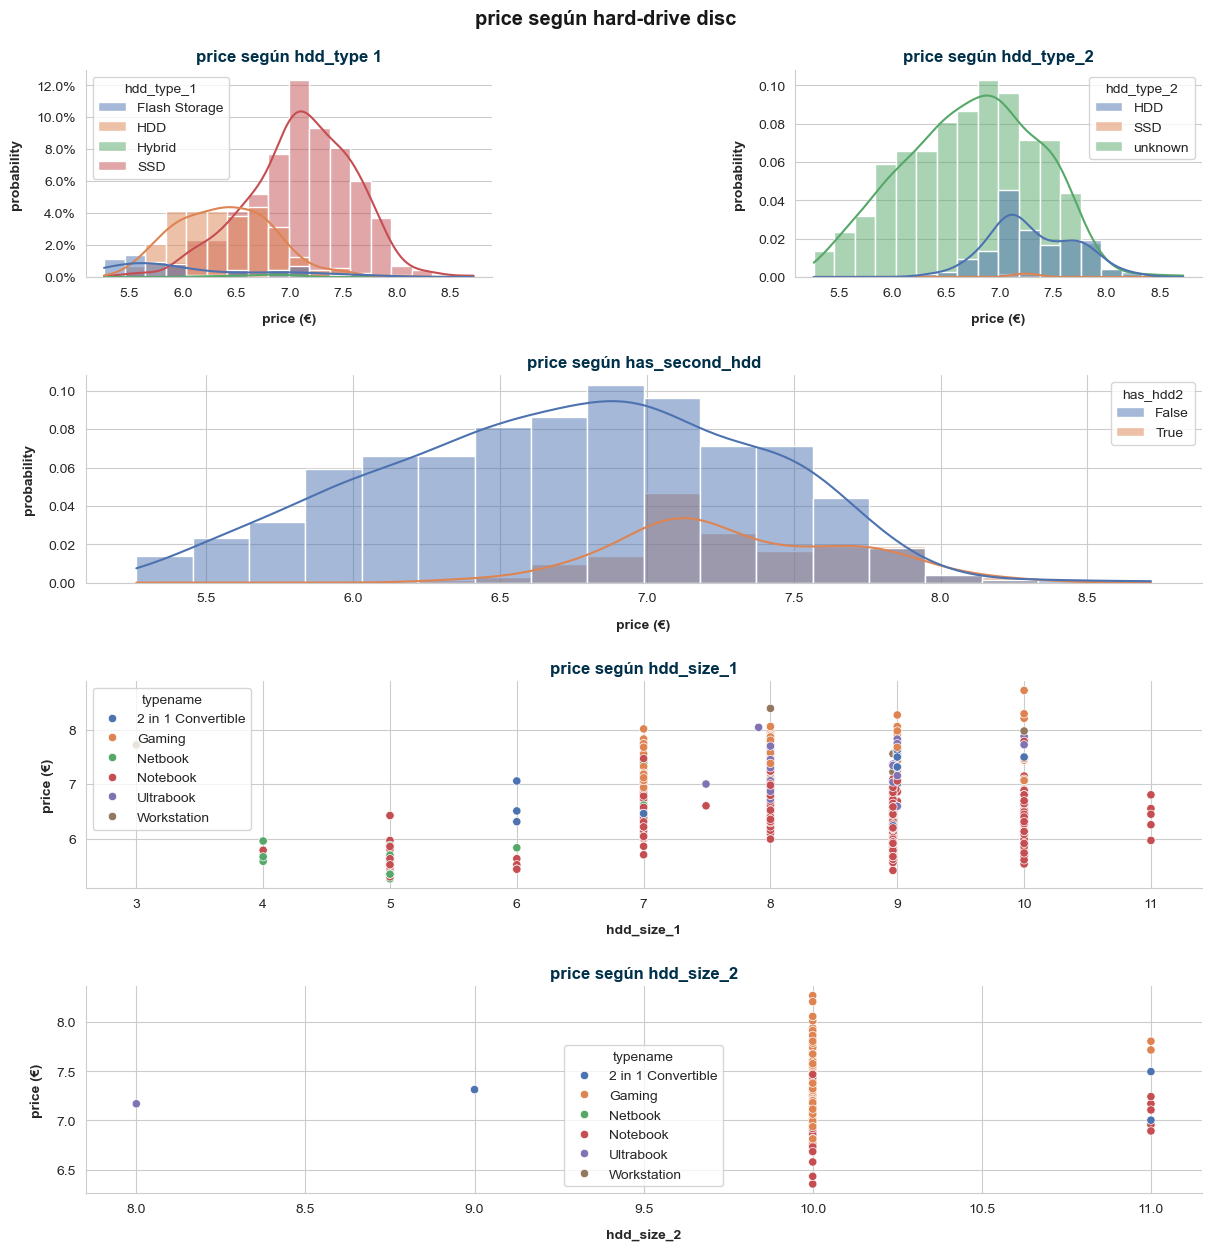

In [104]:
fig = plt.figure(figsize=(12, 12), layout="constrained")
axs = fig.subplot_mosaic([
	["hdd_type_1", "hdd_type_2"],
	["has_second_hdd", "has_second_hdd"],
	["hdd_capacity_1", "hdd_capacity_1"],
	["hdd_capacity_2", "hdd_capacity_2"]
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según hard-drive disc",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_1"].set_title("price según hdd_type 1",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_1",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_1"])
sns.despine(ax=axs["hdd_type_1"])
axs["hdd_type_1"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_1"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["hdd_type_1"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_type_2"].set_title("price según hdd_type_2",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="hdd_type_2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["hdd_type_2"])
sns.despine(ax=axs["hdd_type_2"])
axs["hdd_type_2"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_type_2"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["hdd_type_2"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["has_second_hdd"].set_title("price según has_second_hdd",
								color="#003049",
								fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="has_hdd2",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["has_second_hdd"])
sns.despine(ax=axs["has_second_hdd"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["has_second_hdd"].set_xlabel("price (€)",
								 labelpad=10,
								 fontdict=font_config)
axs["has_second_hdd"].set_ylabel("probability",
								 labelpad=10,
								 fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_1"].set_title("price según hdd_size_1",
					 color="#003049",
					 fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_1"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_1"])
sns.despine(ax=axs["hdd_capacity_1"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_1"].set_xlabel("hdd_size_1",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_1"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["hdd_capacity_2"].set_title("price según hdd_size_2",
								color="#003049",
								fontdict=font_config)
sns.scatterplot(data=df_train,
				x=np.log2(df["hdd_size_2"]),
				y="log_price",
				hue="typename",
				palette="deep",
				ax=axs["hdd_capacity_2"])
sns.despine(ax=axs["hdd_capacity_2"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["hdd_capacity_2"].set_xlabel("hdd_size_2",
								 labelpad=10,
								 fontdict=font_config)
axs["hdd_capacity_2"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

Luego de haber realizado el análisis de la información en el `hard-drive disc` podemos ver que el tipo de hdd puede influir en el precio. Lo mismo sucede en caso de que contemos con notebooks con dos `hdd`.

Diferente es lo que pasa al tamaño del hdd. Antes, habiamos visto una fuerte correlación entre el tamaño de la memoria `RAM` y el precio del dispositivo, en este caso, la capacidad del disco no tiene tanta relevancia.

In [105]:
np.corrcoef(df_train["log_price"], np.log2(df_train["hdd_size_1"]))

array([[1.        , 0.07800824],
       [0.07800824, 1.        ]])

#### Distribución de `Price` según `GPU`

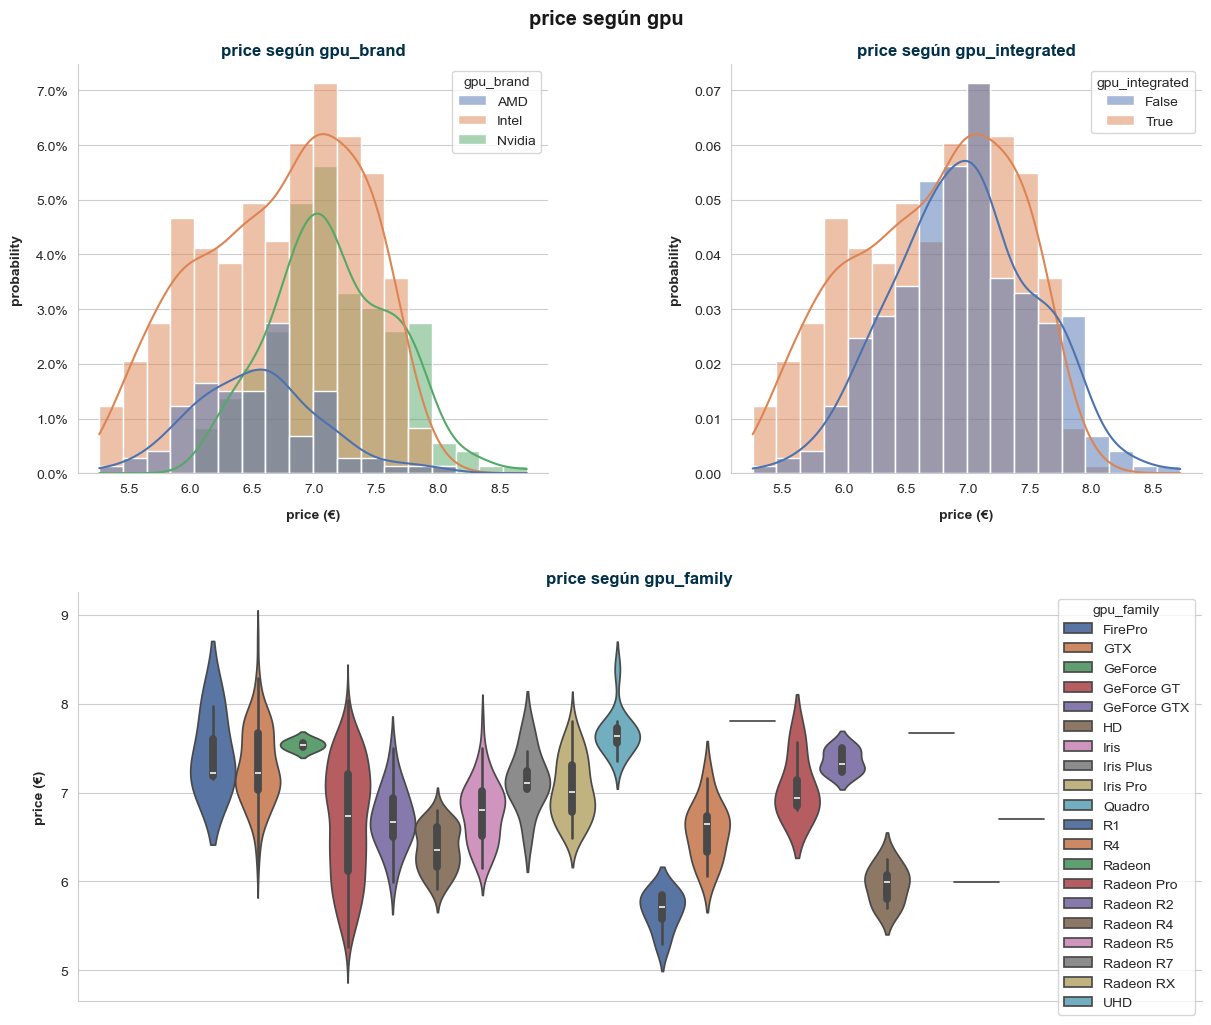

In [106]:
fig = plt.figure(figsize=(12, 10), layout="constrained")
axs = fig.subplot_mosaic([
	["brand", "integrated"],
	["family", "family"],
])

font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle("price según gpu",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.03)


font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["brand"].set_title("price según gpu_brand",
					   color="#003049",
					   fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_brand",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["brand"])
sns.despine(ax=axs["brand"])
axs["brand"].yaxis.set_major_formatter(ticker.PercentFormatter(1))

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["brand"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["brand"].set_ylabel("probability", labelpad=10, fontdict=font_config)
axs["brand"].grid(axis="x", visible=False)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["integrated"].set_title("price según gpu_integrated",
							color="#003049",
							fontdict=font_config)
sns.histplot(data=df_train,
			 x="log_price",
			 hue="gpu_integrated",
			 bins="fd",
			 kde=True,
			 stat="probability",
			 alpha=.5,
			 palette="deep",
			 ax=axs["integrated"])
sns.despine(ax=axs["integrated"])
axs["integrated"].grid(axis="x", visible=False)
font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["integrated"].set_xlabel("price (€)", labelpad=10, fontdict=font_config)
axs["integrated"].set_ylabel("probability", labelpad=10, fontdict=font_config)




font_config = {
	"family": "sans-serif",
	"size": "large",
	"weight": "heavy"
}
axs["family"].set_title("price según gpu_family",
						color="#003049",
						fontdict=font_config)
sns.violinplot(data=df_train,
			y="log_price",
			hue="gpu_family",
			palette="deep",
			ax=axs["family"])
sns.despine(ax=axs["family"])

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
axs["family"].set_ylabel("gpu_family", labelpad=10, fontdict=font_config)
axs["family"].set_ylabel("price (€)", labelpad=10, fontdict=font_config)


fig.get_layout_engine().set(hspace=0.1, wspace=0.1)
plt.show()

In [107]:
df_train.groupby(by=["gpu_brand", "gpu_family"])["log_price"].agg(
	["count", "mean", "min", "max", "median", "std", "var"]
).sort_values(by="median")

count      mean       min       max    median  \
gpu_brand gpu_family                                                   
AMD       Radeon R2        6  5.667384  5.298317  5.857933  5.716647   
          Radeon R4        6  5.962055  5.700444  6.253829  5.989575   
          R4               1  5.991465  5.991465  5.991465  5.991465   
          Radeon R5       30  6.367992  5.910797  6.797940  6.350872   
          Radeon R7       10  6.565822  6.063785  7.168572  6.642878   
          Radeon          26  6.706586  5.991465  7.495542  6.669031   
          R1               1  6.701960  6.701960  6.701960  6.701960   
Intel     HD             366  6.667853  5.262172  8.039480  6.738141   
Nvidia    GeForce         73  6.783609  6.146329  7.802209  6.803505   
          GeForce GT       4  7.060634  6.797952  7.572503  6.936040   
Intel     UHD             43  7.045411  6.492240  7.803843  7.003065   
AMD       Radeon RX        8  7.145707  6.551080  7.696213  7.109430   
          FirePro          3  7.447268  7.146772  7.972466  7.222566   
Nvidia    GeForce GTX    131  7.305671  6.152733  8.716044  7.223223   
Intel     Iris Plus        5  7.355897  7.229839  7.498094  7.326170   
          Iris             2  7.538095  7.495542  7.580649  7.538095   
Nvidia    Quadro          12  7.677229  7.353722  8.387085  7.635833   
Intel     Iris Pro         1  7.669014  7.669014  7.669014  7.669014   
AMD       Radeon Pro       1  7.800151  7.800151  7.800151  7.800151   

                            std       var  
gpu_brand gpu_family                       
AMD       Radeon R2    0.219324  0.048103  
          Radeon R4    0.212419  0.045122  
          R4                NaN       NaN  
          Radeon R5    0.254068  0.064551  
          Radeon R7    0.325198  0.105754  
          Radeon       0.345955  0.119685  
          R1                NaN       NaN  
Intel     HD           0.651602  0.424586  
Nvidia    GeForce      0.353023  0.124625  
          GeForce GT   0.351684  0.123681  
Intel     UHD          0.351838  0.123790  
AMD       Radeon RX    0.335948  0.112861  
          FirePro      0.456411  0.208311  
Nvidia    GeForce GTX  0.444382  0.197475  
Intel     Iris Plus    0.134523  0.018096  
          Iris         0.060180  0.003622  
Nvidia    Quadro       0.255671  0.065368  
Intel     Iris Pro          NaN       NaN  
AMD       Radeon Pro        NaN       NaN

#### Correlaciones

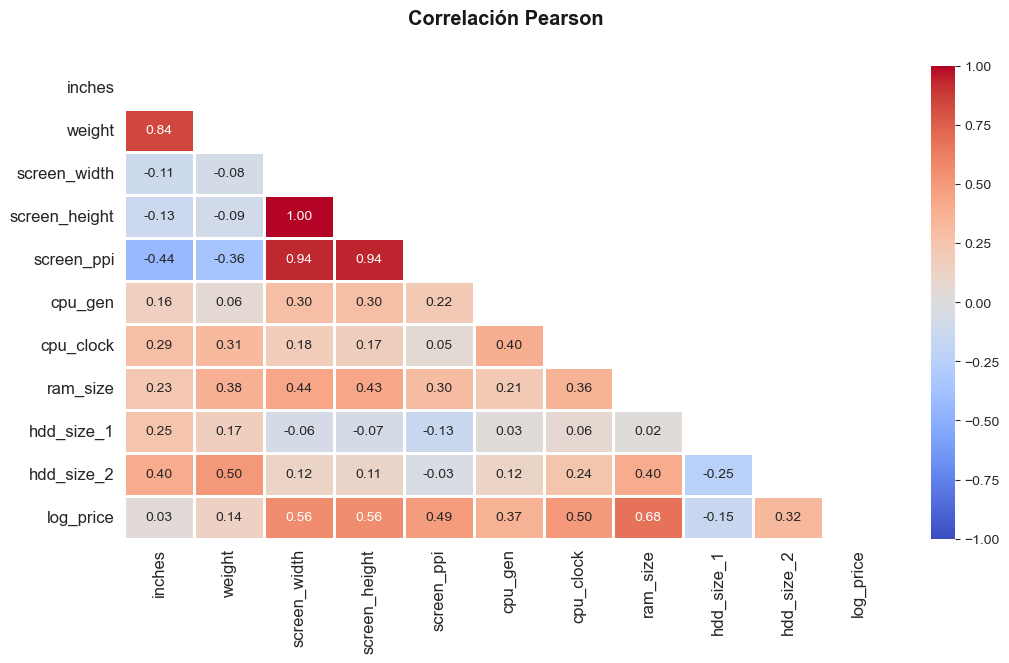

In [108]:
columns = df_train.select_dtypes("number").columns
correlations = df_train[columns.drop(["price"])].corr()
mask = np.triu(np.ones_like(correlations, dtype=bool))

fig, ax = plt.subplots(figsize=(10, 6), layout="constrained")
font_config = {
	"family": "sans-serif",
	"size": "x-large",
	"weight": "black"
}
fig.suptitle(f"Correlación Pearson",
			 color="#181818",
			 fontproperties=font_config,
			 y=1.08)
sns.heatmap(data=correlations,
			mask=mask,
			annot=True,
			cmap="coolwarm",
			fmt=".2f",
			center=0,
			linewidths=1,
			vmax=1,
			vmin=-1,
			ax=ax)
ax.set_xticks(ax.get_xticks(),
			  labels=correlations.columns,
			  fontsize=12,
			  rotation=90)
ax.set_yticks(ax.get_yticks(), labels=correlations.columns, fontsize=12)
ax.grid(False)

font_config = {
	"family": "sans-serif",
	"size": "medium",
	"weight": "bold"
}
sns.despine(left=True, bottom=True, ax=ax)
plt.show()

Tomando en cuenta las correlaciones, hay algunas variables que debemos eliminar. Estas son:
- `inches`: tiene poca o nula correlación con `price` y una correlación de 0.84 con `weight`.
- `screen_width`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_hegiht`: la información de esta variable se encuentra en `screen_ppi`.
- `screen_ppi`: tiene mucha colinealidad con `screen_height` y `screen_width`. Dependiendo el rendimiento del modelo eligiremos una u otras.

---

## Procesado de datos

In [109]:
from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, \
								  OrdinalEncoder, FunctionTransformer

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import cross_validate, KFold, GridSearchCV, \
									RandomizedSearchCV, RepeatedKFold

### OneHotEncoder

Estas transformaciones se encuentra en los pipelines creados luego.

In [ ]:
df_scaled = df_train.copy()
df_scaled["weight"] = np.log1p(df_scaled["weight"])
df_scaled["screen_ppi"] = np.log1p(df_scaled["screen_ppi"])
df_scaled["ram_size"] = np.log2(df_scaled["ram_size"])
df_scaled["hdd_size_1"] = np.log2(df_scaled["hdd_size_1"])
df_scaled["hdd_size_2"] = np.where(
	df_scaled["hdd_size_2"] > 0,
	np.log2(df_scaled["hdd_size_2"]),
	0
)

In [ ]:
df_scaled.iloc[:, 20:30]

In [ ]:
to_encode = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	"hdd_type_1",
	"gpu_brand",
	"gpu_integrated",
	"has_hdd2"
]
preprocessing = OneHotEncoder(sparse_output=False, dtype=np.int16)
preprocessing.set_output(transform="pandas")
encoding = preprocessing.fit_transform(df_scaled.loc[:, to_encode])
categories = preprocessing.get_feature_names_out()

df_scaled = pd.concat([df_scaled, encoding], axis=1)
df_scaled.drop(columns=to_encode, inplace=True)

### StandardScaler

Estas transformaciones se encuentra en los pipelines creados luego.

In [ ]:
features = [
	"weight",
	"screen_ppi",
	"cpu_clock",
	"ram_size",
	"hdd_size_1",
	"hdd_size_2",
	"log_price"
]
preprocessing = StandardScaler()
preprocessing.set_output(transform="pandas")
scaled = preprocessing.fit_transform(df_scaled.loc[:, features])
numerics = preprocessing.get_feature_names_out()

df_scaled = df_scaled.drop(columns=features).join(scaled)

In [ ]:
features = list(categories) + list(numerics)
target = features[-1]
features = features[:-1]

df_scaled.loc[:, features]

-----------------------------------------------------------------------------------------------------------------

In [110]:
df_train.iloc[:, 10:20]

screen_resolution  screen_width  screen_height  screen_ppi  \
laptop_ID                                                              
1118              1920x1080          1920           1080      127.34   
153               1920x1080          1920           1080      141.21   
275               2560x1600          2560           1600      226.98   
1100              1920x1080          1920           1080      157.35   
131               1920x1080          1920           1080      127.34   
...                     ...           ...            ...         ...   
578                1366x768          1366            768      111.94   
996               1920x1080          1920           1080      141.21   
770               1920x1080          1920           1080      176.23   
407                1366x768          1366            768      100.45   
418               2560x1440          2560           1440      209.80   

          cpu_brand cpu_family cpu_series  cpu_gen  cpu_clock  ram_size  
laptop_ID                                                                
1118          Intel       Core         i7      6.0        2.6         8  
153           Intel       Core         i7      7.0        2.8        16  
275           Intel       Core         i5      NaN        2.9         8  
1100          Intel       Core         i5      6.0        2.3         4  
131           Intel       Core         i7      8.0        1.8        16  
...             ...        ...        ...      ...        ...       ...  
578           Intel    Pentium  Quad Core      3.0        1.6         8  
996             AMD   A-Series        A12      9.0        3.6         6  
770           Intel       Core         i7      7.0        2.8        16  
407           Intel    Celeron  Dual Core      3.0        1.1         4  
418           Intel       Core         i7      7.0        2.8         8  

[729 rows x 10 columns]

---

## **Machine Learning**

### **Baseline de modelos**

In [154]:
def plot_feature_importance(serie: pd.Series):
	fig, ax = plt.subplots(figsize=(16, 8), layout="constrained")

	font_config = {
		"family": "sans-serif",
		"size": "xx-large",
		"weight": "black"
	}
	fig.suptitle(f"{serie.name}".upper(),
				 color="#262626",
				 fontproperties=font_config,
				 y=1.02)

	
	rect = ax.barh(y=serie.index,
				   width=serie.values,
				   data=serie,
				   color="#60A5FA",
				   zorder=2)


	font_config = {
		"family": "sans-serif",
		"size": "small",
		"weight": "medium",
	}
	ax.bar_label(rect, fmt="%.4f", padding=2, fontproperties=font_config)
	
	font_config = {
		"color": "#172554",
		"family": "sans-serif",
		"horizontalalignment": "center",
		"verticalalignment": "center",
		"size": "large",
		"weight": "bold",
	}
	ax.set_ylabel("features", labelpad=10, fontdict=font_config)
	ax.set_xlabel("importance", labelpad=10, fontdict=font_config)
	ax.grid(axis="y", visible=False)
	ax.grid(axis="x",
			alpha=1,
			color="#D4D4D4",
			linestyle="dashed",
			linewidth=1)
	ax.spines[["left", "bottom", "top", "right"]].set_visible(False)
	ax.spines["left"].set_linewidth(1)
	plt.show()

#### `LinearRegression`, `Ridge` y `Lasso`

In [191]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]
log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	"hdd_type_1",
	"gpu_brand",
	"gpu_integrated"
]

columns_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			 OneHotEncoder(drop="first", handle_unknown="ignore"),
			 columns_to_ohe
		)
	],
	n_jobs=-1
)

In [192]:
#linear_regression = LinearRegression(n_jobs=-1)
linear_regression = Ridge(alpha=14)
pipeline = Pipeline(
	steps=[
		("preprocessing", columns_transformer),
		("regressor", linear_regression)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [193]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lambda> at 0x7d4b056c05e0>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      Ridge(alpha=14))]))

#### Features Importances

Ordenada al origen: 6.431623671358488


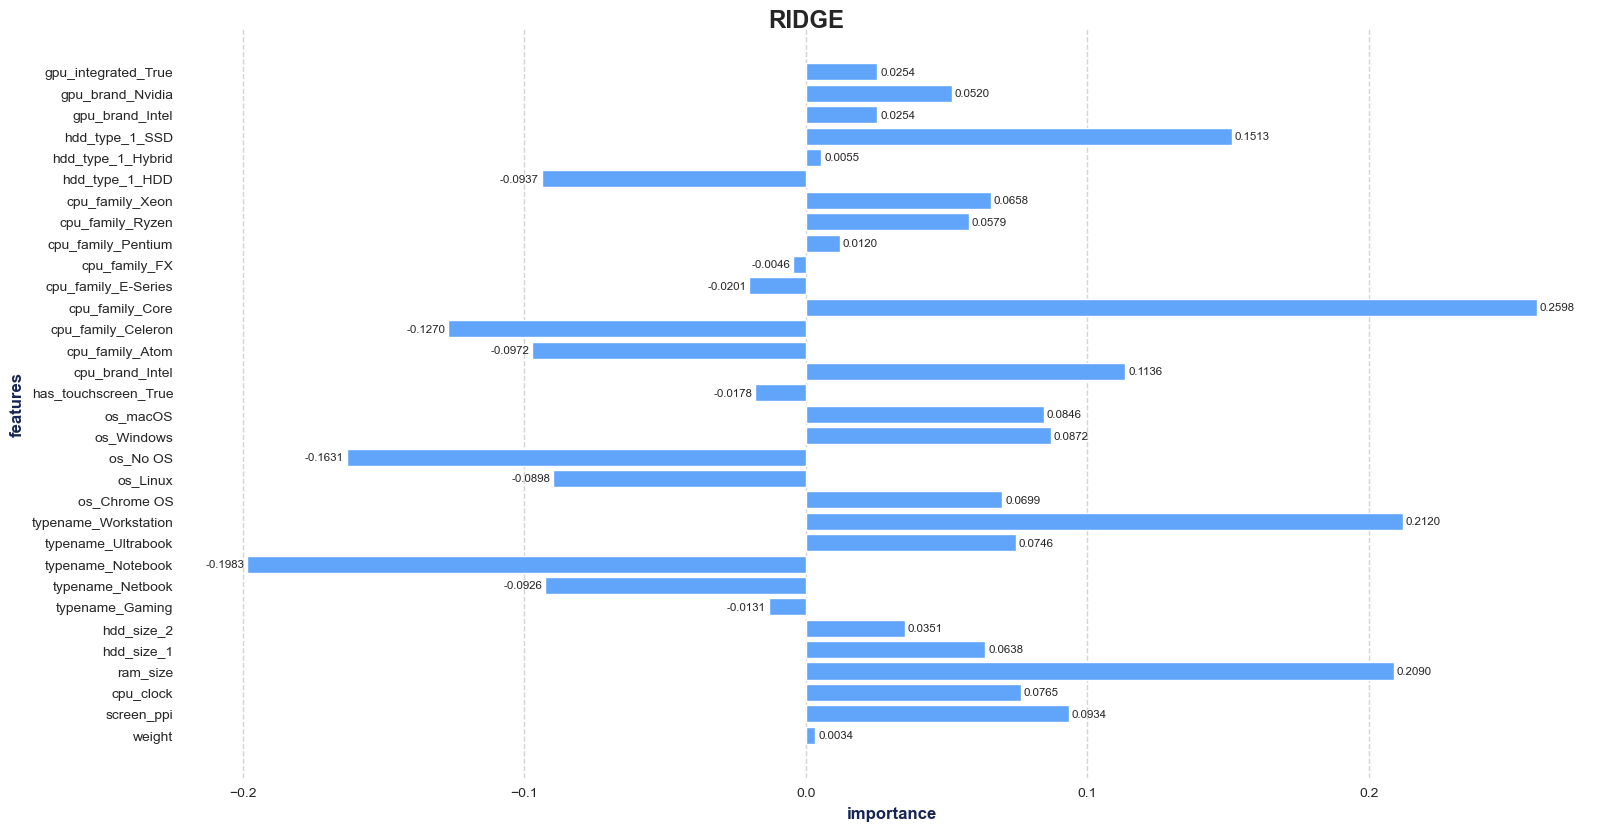

In [194]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded = preprocess["to_encode_ohe"].get_feature_names_out()

index = np.hstack([columns_to_logn, columns_to_log2, columns_encoded])
data = model.regressor_.named_steps["regressor"].coef_.ravel()

data = pd.Series(data, index=index, name="ridge")
plot_feature_importance(data)

In [195]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=5,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


--------------------
Train RMSE: 353.128
Train R2: 72.388
--------------------
Test RMSE: 359.324
Test R2: 71.124
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [1, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


### **Trees**

#### `RandomForestRegressor`

In [121]:
from sklearn.ensemble import RandomForestRegressor

In [196]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]

log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	"hdd_type_1",
	"gpu_brand",
	"gpu_integrated"
]

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			 OneHotEncoder(handle_unknown="ignore"),
			 columns_to_ohe
		),
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

In [197]:
random_forest = RandomForestRegressor(n_estimators=200,
									  max_depth=15,
									  min_samples_leaf=5,
									  min_samples_split=12,
									  criterion="squared_error",
									  n_jobs=-1,
									  random_state=42)
pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [198]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...988f40>))]),
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=15,
                                                                            min_samples_leaf=5,
                                                                            min_samples_split=12,
                                                                            n_estimators=200,
                                                                            n_jobs=-1,
                                                                            random_state=42))]))

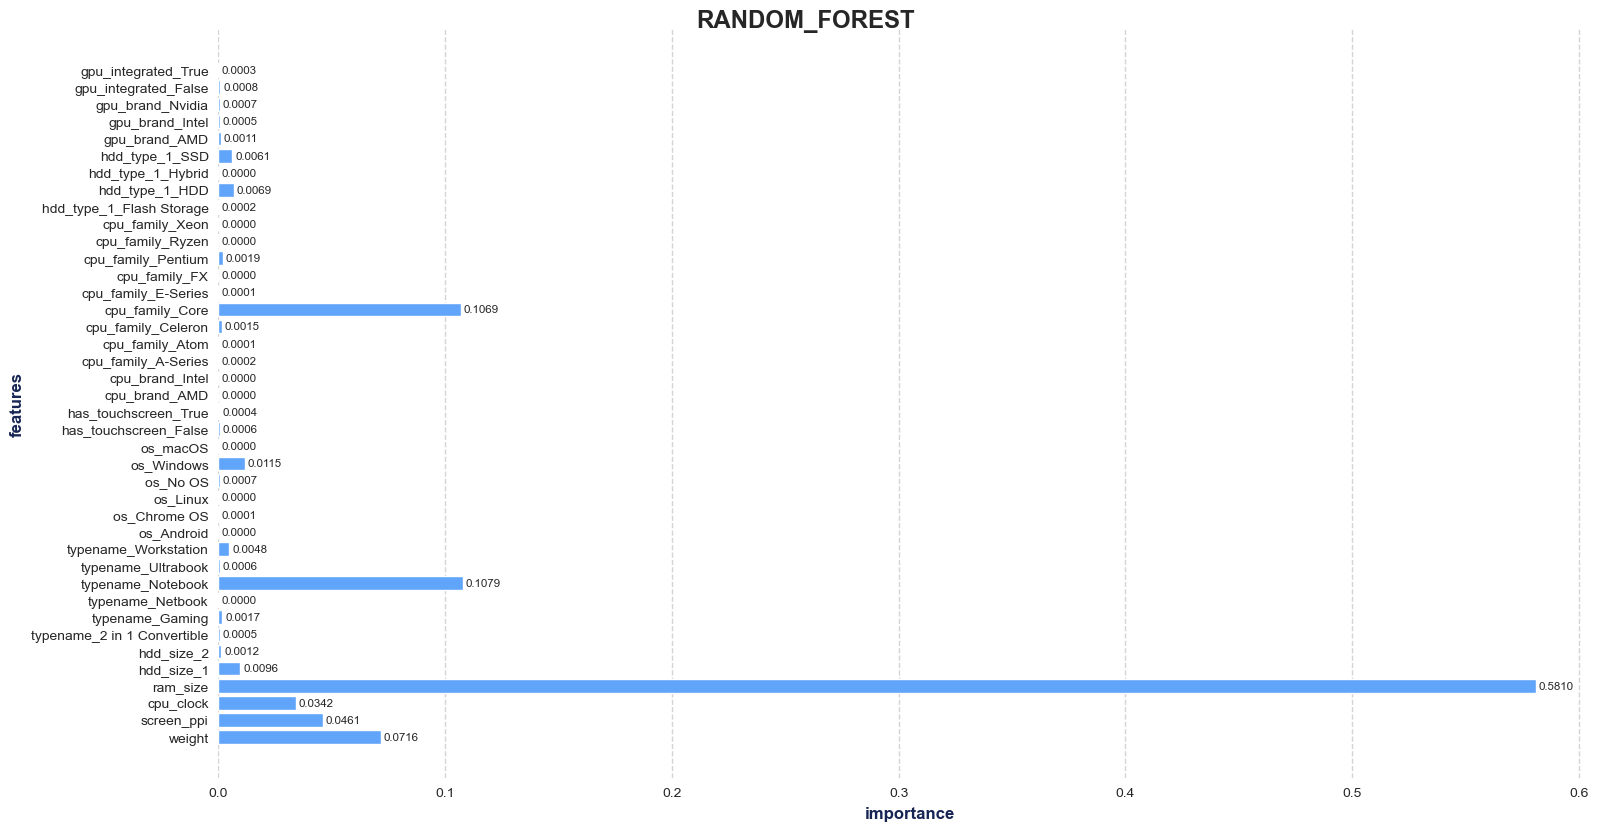

In [199]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_

data = pd.Series(data, index=columns, name="random_forest")
plot_feature_importance(data)

In [200]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=5,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

--------------------
Train RMSE: 281.106
Train R2: 82.478
--------------------
Test RMSE: 338.611
Test R2: 74.146
--------------------


El modelo se encuentra sobreajustado a los datos de entrenamiento. La diferencia de error es muy grande, por lo que podemos concluire que el modelo no logra generalizar correctamente.

In [138]:
repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

##### RandomizedSearchCV

In [ ]:
random_forest = RandomForestRegressor(
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [ ]:
params = {
	"regressor__regressor__n_estimators": [100, 300, 600],
	"regressor__regressor__max_depth": [2, 5, 8, 14],
	"regressor__regressor__max_features": ["sqrt", "log2"],
	"regressor__regressor__max_samples": [0.6, 0.8, None],
	"regressor__regressor__min_samples_leaf": [4, 8, 14],
	"regressor__regressor__min_samples_split": [4, 8, 14],
}

randomized_search = RandomizedSearchCV(
	estimator=model,
	param_distributions=params,
	n_iter=50,
	cv=repeated_kfold,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2
)
randomized_search.fit(df_train, df_train["price"])

In [ ]:
randomized_search.best_params_

In [127]:
random_forest = RandomForestRegressor(
	n_estimators=300,
	max_depth=15,
	max_features="log2",
	max_samples=None,
	min_samples_leaf=4,
	min_samples_split=4,
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [128]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                       ['ram_size',
                                                                                        'hdd_size_1',
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=15,
                                                                            max_features='log2',
                                                                            min_samples_leaf=4,
                                                                            min_samples_split=4,
                                                                            n_estimators=300,
                                                                            n_jobs=-1,
                                                                            random_state=42))]))

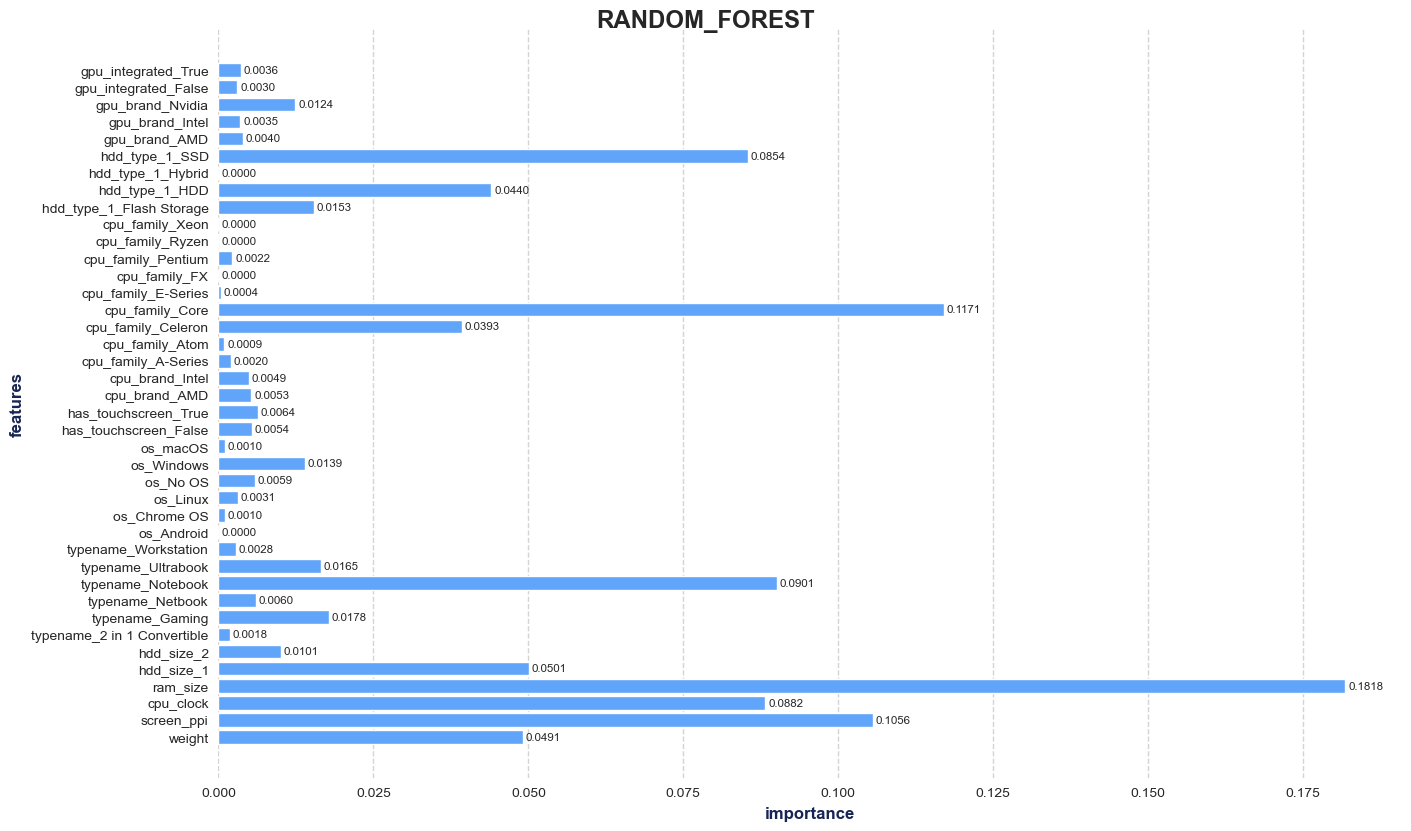

In [ ]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()

columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_


data = pd.Series(data, index=columns, name="random_forest")
plot_feature_importance(data)

In [140]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=repeated_kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

--------------------
Train RMSE: 326.442
Train R2: 76.395
--------------------
Test RMSE: 360.595
Test R2: 70.689
--------------------


##### GridSearchCV

Buscamos ajustar los hiperparámetros del **RandomForest** para mejorar el rendimiento.

In [ ]:
random_forest = RandomForestRegressor(
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	oob_score=True,
	random_state=42
)


pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [ ]:
params = {
	"regressor__regressor__n_estimators": [250, 300, 350],
	"regressor__regressor__max_depth": [12, 15, 20],
	"regressor__regressor__max_features": ["sqrt", "log2", None],
	"regressor__regressor__max_samples": [0.6, 0.7],
	"regressor__regressor__min_samples_leaf": [4, 6, 8],
	"regressor__regressor__min_samples_split": [5, 8, 10, 12],
}

grid_search = GridSearchCV(
	estimator=model,
	param_grid=params,
	cv=repeated_kfold,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2
)
grid_search.fit(df_train, df_train["price"])

In [ ]:
grid_search.best_params_

In [141]:
random_forest = RandomForestRegressor(
	n_estimators=350,
	max_depth=10,
	max_features=None,
	max_samples=.7,
	min_samples_leaf=8,
	min_samples_split=18,
	oob_score=True,
	bootstrap=True,
	criterion="squared_error",
	n_jobs=-1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", random_forest)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [142]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=10,
                                                                            max_features=None,
                                                                            max_samples=0.7,
                                                                            min_samples_leaf=8,
                                                                            min_samples_split=18,
                                                                            n_estimators=350,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
                                                                            random_state=42))]))

oob_score: 0.8337869092967648


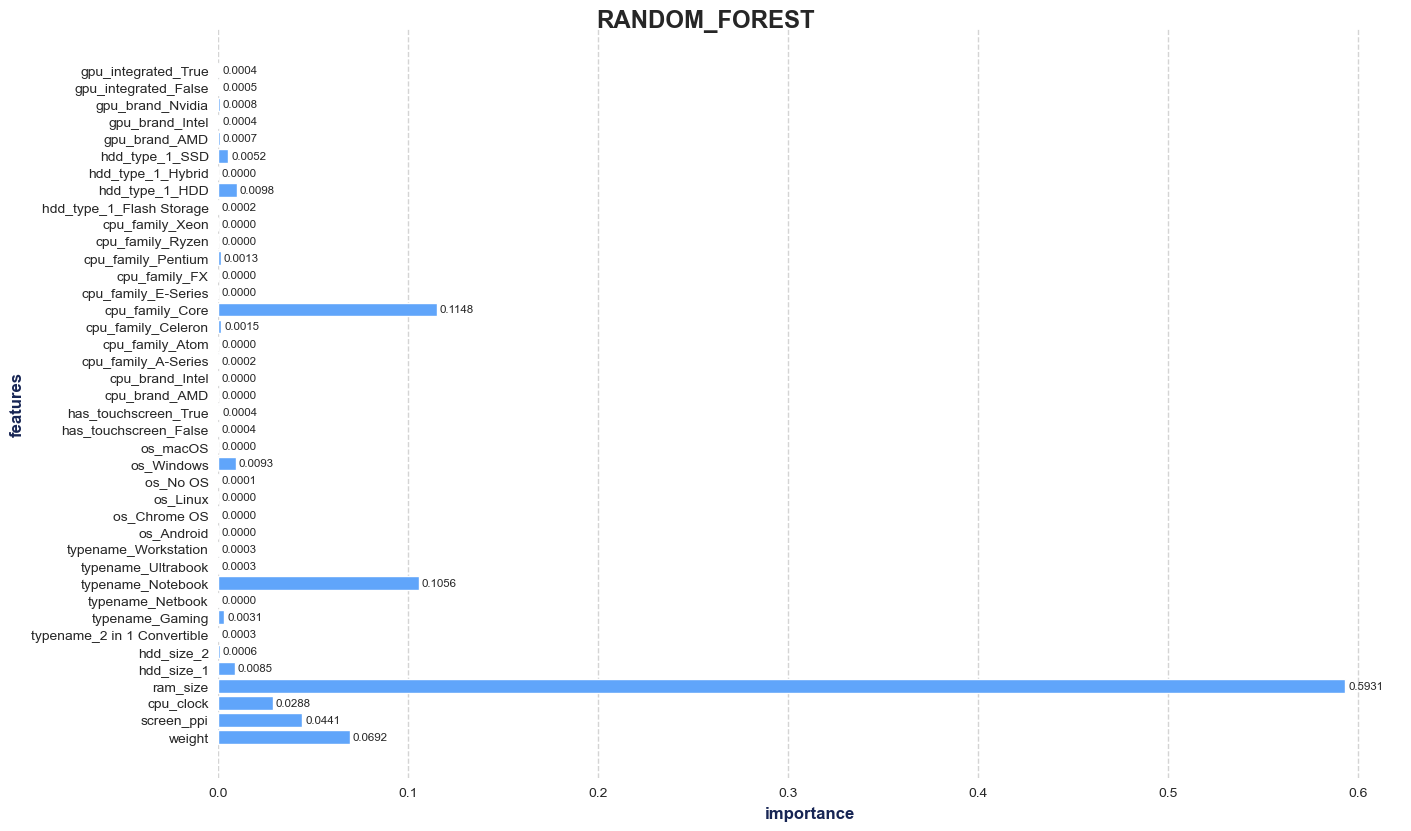

In [143]:
oob_score = model.regressor_.named_steps["regressor"].oob_score_
print("oob_score:", oob_score)

features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="random_forest")

plot_feature_importance(data)

In [144]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=repeated_kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

--------------------
Train RMSE: 326.442
Train R2: 76.395
--------------------
Test RMSE: 360.595
Test R2: 70.689
--------------------


#### `XGBoost`

In [145]:
from xgboost import XGBRegressor

In [146]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]

log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size_1", "hdd_size_2"]

columns_to_ohe = [
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"hdd_type_1",
	"gpu_brand",
	"gpu_integrated"
]

# to_encode_oe = ["ram_size", "hdd_size_1", "hdd_size_2"]
# ordinal_categories = [
#     [2, 4, 6, 8, 12, 16, 32, 64],
#     [8, 16, 32, 64, 128, 180, 240, 256, 500, 508, 512, 1024, 2048],
#     [0, 256, 512, 1024, 2048],
# ]

trees_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					#("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			 OneHotEncoder(handle_unknown="ignore"),
			 columns_to_ohe
		),
		# (
		#     "categorical_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     to_encode_oe
		# )
	],
	n_jobs=-1
)

In [ ]:
xgboost = XGBRegressor(
	n_estimators=1500,
	learning_rate=0.08,
	max_depth=10,
	min_child_weight=4,
	gamma=1,
	subsample=0.7,
	colsample_bytree=0.8,
	reg_alpha=0.4,
	reg_lambda=1,
	objective="reg:squarederror",
	n_jobs=-1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [147]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                                        'hdd_size_2']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(handle_unknown='ignore'),
                                                                                       ['typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_brand',
                                                                                        'gpu_integrated'])])),
                                                     ('regressor',
                                                      RandomForestRegressor(max_depth=10,
                                                                            max_features=None,
                                                                            max_samples=0.7,
                                                                            min_samples_leaf=8,
                                                                            min_samples_split=18,
                                                                            n_estimators=350,
                                                                            n_jobs=-1,
                                                                            oob_score=True,
                                                                            random_state=42))]))

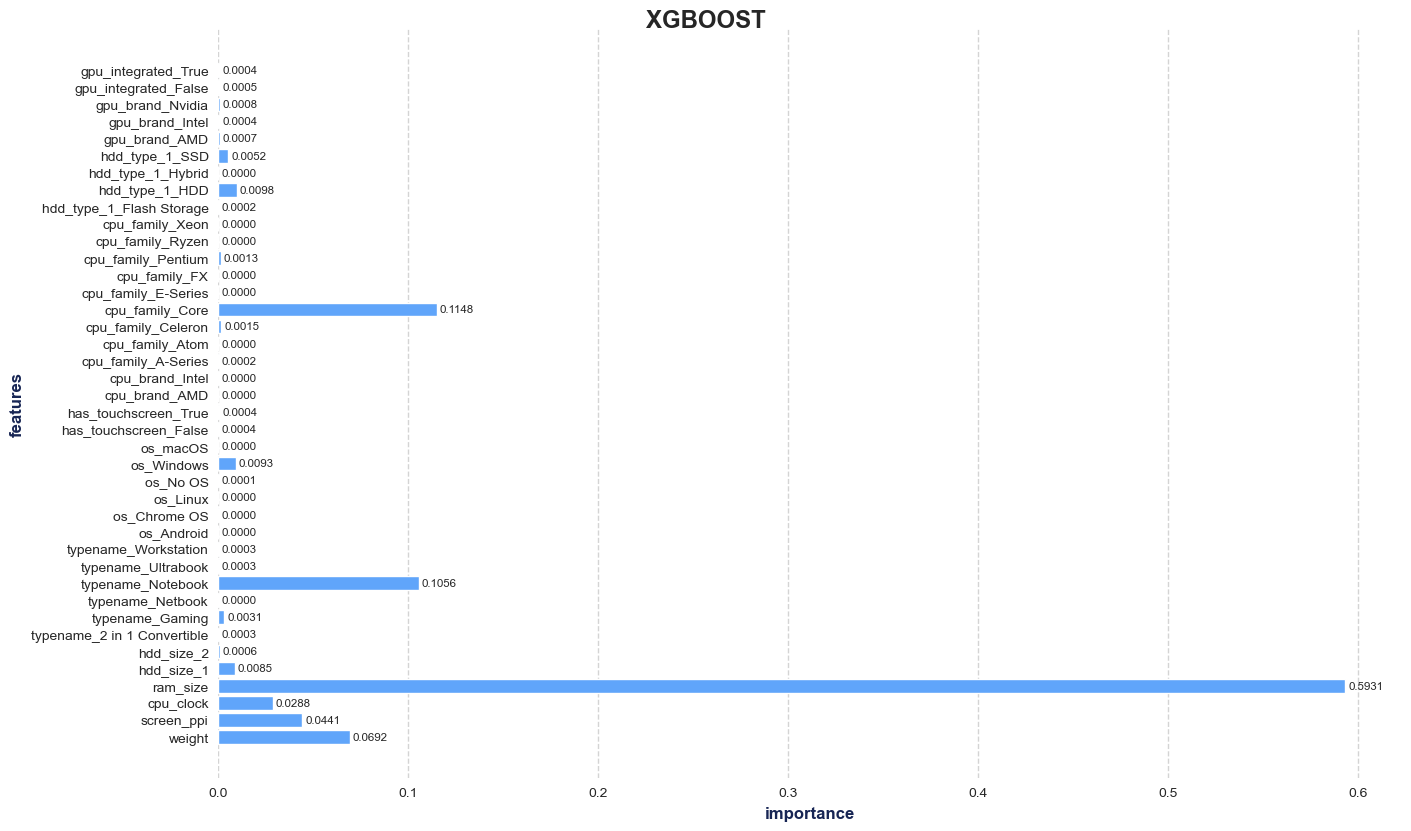

In [148]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="xgboost")

plot_feature_importance(data)

In [149]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=repeated_kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

--------------------
Train RMSE: 326.442
Train R2: 76.395
--------------------
Test RMSE: 360.595
Test R2: 70.689
--------------------


##### GridSearchCV

In [ ]:
xgboost = XGBRegressor(
	n_estimators=1500,
	objective="reg:squarederror",
	n_jobs=-1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [ ]:
params = {
	"regressor__regressor__max_depth": [3, 4],
	"regressor__regressor__min_child_weight": [3, 5, 7],
	"regressor__regressor__subsample": [0.6, 0.7, 0.8],
	"regressor__regressor__colsample_bytree": [0.7, 0.8],
	"regressor__regressor__gamma": [0, 1],
	"regressor__regressor__learning_rate": [0.03, 0.05, 0.07],
	"regressor__regressor__reg_alpha": [0, 0.5, 1, 1.5],
	"regressor__regressor__reg_lambda": [3, 5, 7]
}

#repeated_kfold = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)
k_fold = KFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(
	estimator=model,
	param_grid=params,
	cv=k_fold,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2
)
grid_search.fit(df_train, df_train["price"])

In [ ]:
grid_search.best_params_

In [150]:
xgboost = XGBRegressor(
	n_estimators=1000,
	colsample_bytree=0.7,
	gamma=0,
	learning_rate=0.05,
	max_depth=3,
	min_child_weight=3,
	reg_alpha=0,
	reg_lambda=3,
	subsample=0.6,
	objective="reg:squarederror",
	n_jobs=-1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [151]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   feature_weights=None,
                                                                   gamma=0,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.05,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=None,
                                                                   min_child_weight=3,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=1000,
                                                                   n_jobs=-1,
                                                                   num_parallel_tree=None, ...))]))

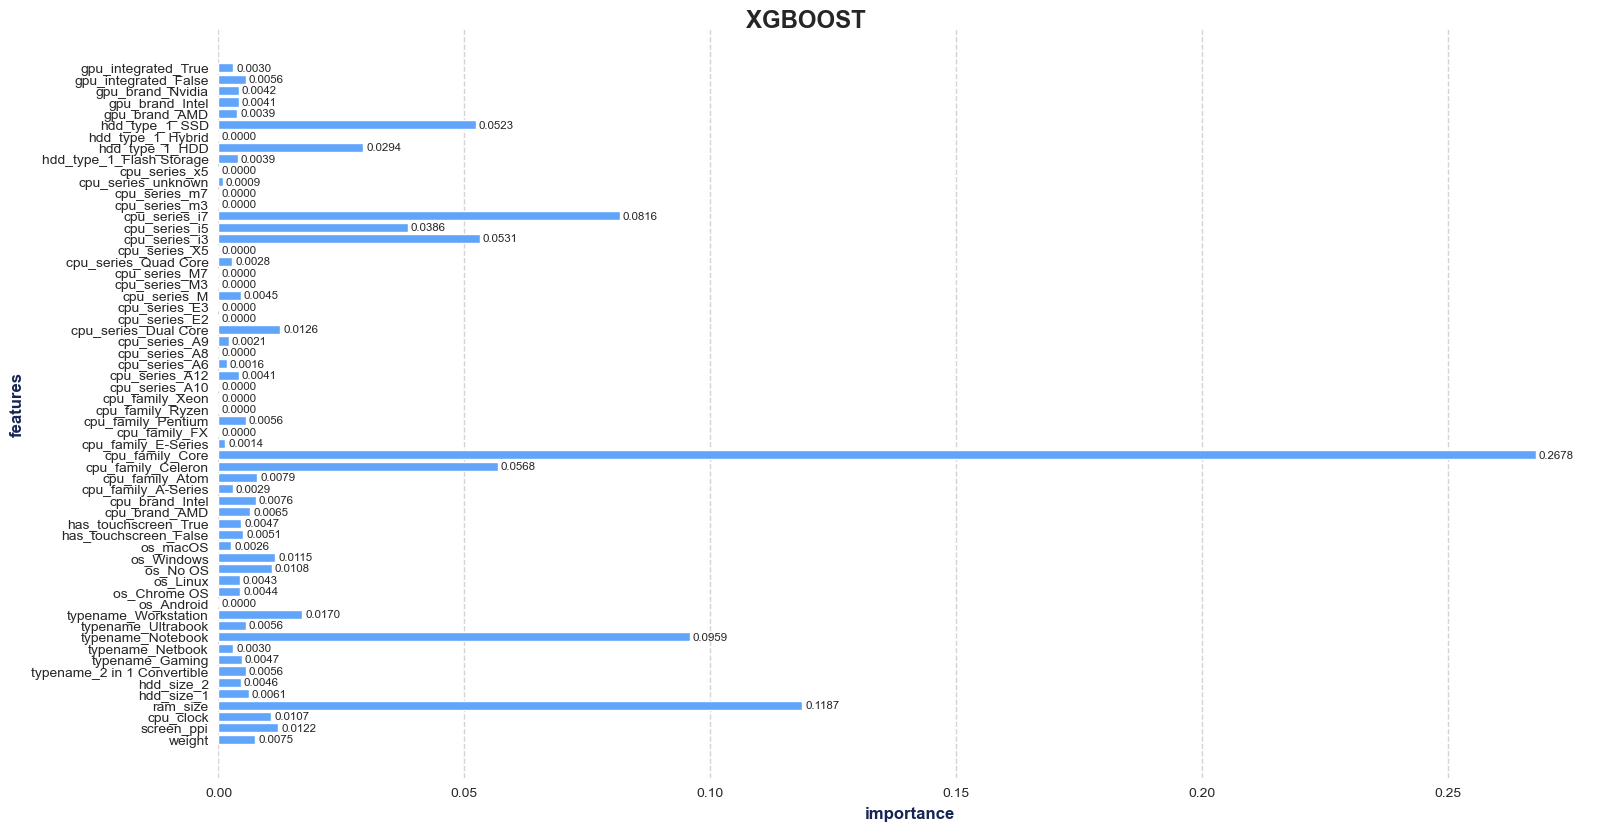

In [155]:
features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="xgboost")

plot_feature_importance(data)

In [156]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=repeated_kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.3f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.3f}")
print("-"*20)

--------------------
Train RMSE: 143.796
Train R2: 95.411
--------------------
Test RMSE: 286.493
Test R2: 81.405
--------------------


### Conclusión

Luego de entrenar varios modelos, me he percatado que es necesario una optimización y un mejor manejo del dataset. De todas maneras, nos encontramos con un modelo muy potente para un dataset muy pequeño, por lo que es común el sobreentrenamiento que se genera en los modelos.



### Mejoras en preprocesamiento

Agrupamos toda la memoria del `hard-disc drive` en una única variable.

In [201]:
df_train["hdd_size"] = (
	df_train["hdd_size_1"] + df_train["hdd_size_2"]
).astype(int)

df_train[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)

hdd_size  hdd_size_1  hdd_size_2
laptop_ID                                  
1189            512         512           0
57              128         128           0
956             500         500           0
945             500         500           0
1109            128         128           0
195              32          32           0
1035            256         256           0
621             500         500           0
1275            500         500           0
1210            500         500           0

Reducimos las variables de `os`.

In [202]:
df_train["os"].unique()

<StringArray>
['Windows', 'macOS', 'Linux', 'Chrome OS', 'No OS', 'Android']
Length: 6, dtype: str

In [ ]:
df_train["os"] = df_train["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
df_train.replace(maps, inplace=True).sample(5)

company         product  typename  inches       os  weight   price  \
laptop_ID                                                                      
446          Asus    VivoBook Max  Notebook    15.6  Free OS    2.00   559.0   
946            HP          250 G6  Notebook    15.6  Free OS    1.86   288.9   
843        Lenovo  ThinkPad T470s  Notebook    14.0  Windows    1.32  1650.0   
951           MSI   GP62M Leopard    Gaming    15.6  Windows    2.20  1199.0   
1125           HP  EliteBook 1030  Notebook    13.3  Windows    1.16  1699.0   

           has_touchscreen screen_panel screen_type  ... hdd_type_1  \
laptop_ID                                            ...              
446                  False          NaN     Full HD  ...        SSD   
946                  False          NaN          HD  ...        HDD   
843                  False    IPS Panel     Full HD  ...        SSD   
951                  False          NaN     Full HD  ...        SSD   
1125                  True          NaN    Quad HD+  ...        SSD   

           hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_ID                                                             
446                 0     unknown      Intel           HD       620   
946                 0     unknown      Intel           HD       400   
843                 0     unknown      Intel           HD       620   
951              1024         HDD     Nvidia  GeForce GTX      1050   
1125                0     unknown      Intel           HD       515   

          gpu_integrated  has_hdd2  log_price  hdd_size  
laptop_ID                                                
446                 True     False   6.327937       256  
946                 True     False   5.669536      1024  
843                 True     False   7.409136       256  
951                False      True   7.090077      1152  
1125                True     False   7.438384       256  

[5 rows x 31 columns]

Completamos los valores de `gpu_model` que tenemos y tratamos de agrupar para evitar la alta dimensionalidad en el dataset.

In [205]:
df_train["gpu_model"].unique()

<StringArray>
[ 'W6150M',    '1050',     '550',     '520',     '530',    'M315',   '930MX',
     '620',    '1070',     '580', '1050 Ti',   '920MX',    '960M',   '940MX',
     '430',     '400',       nan,    'M430',     '615',   'M1200',    '1060',
   '1050M',     '515',   'MX150', 'unknown',   'M420X',    'M445',     '500',
    '6000',  'W5130M',   'MX130',  '1050Ti',     '555',  'M1000M',     '405',
   'M500M',    'M620',     '640',   'M365X',    '930M',     '540',     '510',
    '1080',     '505',    '950M',    '980M',    'M420',    '970M',     '560',
    '920M',     '650',    'M460',   '150MX',     '980',     '630',    'M330',
     '960',  'M2200M',    'M440',  'W4190M',    '940M',    '5300',  'M2000M',
      '7M']
Length: 64, dtype: str

In [289]:
df_train.fillna({"gpu_gen": "0"}, inplace=True).sample(5)

company             product            typename  inches       os  \
laptop_ID                                                                    
930            HP         Probook 430            Notebook    13.3  Windows   
509        Lenovo      Yoga 920-13IKB  2 in 1 Convertible    13.9  Windows   
197        Lenovo  IdeaPad 320-17IKBR            Notebook    17.3  Free OS   
1207         Acer     Predator G9-793              Gaming    17.3  Windows   
1275         Dell         Vostro 3568            Notebook    15.6  Windows   

           weight   price  has_touchscreen screen_panel screen_type  ...  \
laptop_ID                                                            ...   
930          1.49   960.0            False          NaN     Full HD  ...   
509          1.40  1599.0             True    IPS Panel     Full HD  ...   
197          2.80   698.0            False          NaN         HD+  ...   
1207         4.20  2599.0            False    IPS Panel     Full HD  ...   
1275         2.29   490.0            False          NaN          HD  ...   

          hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_ID                                                            
930                0     unknown      Intel           HD       620   
509                0     unknown      Intel          UHD       620   
197                0     unknown     Nvidia      GeForce     MX150   
1207            1024         HDD     Nvidia  GeForce GTX      1070   
1275               0     unknown      Intel           HD       520   

          gpu_integrated has_hdd2  log_price  hdd_size  \
laptop_ID                                                
930                 True    False   6.867974       256   
509                 True    False   7.377759       256   
197                False    False   6.549651       256   
1207               False     True   7.863267      1280   
1275                True    False   6.196444       500   

           gpu_model_recategorization  
laptop_ID                              
930                               NaN  
509                               NaN  
197                             other  
1207                             1070  
1275                              NaN  

[5 rows x 32 columns]

In [206]:
df_train.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)

company             product   typename  inches       os  weight  \
laptop_ID                                                                   
629          Dell       Inspiron 5570   Notebook    15.6  Windows    2.20   
511        Lenovo      Chromebook N23    Netbook    11.6    Other    1.25   
1199       Lenovo   IdeaPad 310-15IKB  Ultrabook    15.6  Windows    1.54   
1196          MSI          GS60 Ghost     Gaming    15.6  Windows    1.91   
439        Lenovo  IdeaPad 320s-14IKB   Notebook    14.0  Windows    1.70   

             price  has_touchscreen screen_panel screen_type  ... hdd_type_1  \
laptop_ID                                                     ...              
629         776.00            False          NaN     Full HD  ...        HDD   
511         265.00            False          NaN          HD  ...        SSD   
1199        831.00            False          NaN     Full HD  ...        SSD   
1196       2153.37            False          NaN     Full HD  ...        SSD   
439         599.00            False    IPS Panel     Full HD  ...        SSD   

           hdd_size_2  hdd_type_2  gpu_brand   gpu_family gpu_model  \
laptop_ID                                                             
629                 0     unknown        AMD       Radeon       530   
511                 0     unknown      Intel           HD       400   
1199                0     unknown     Nvidia      GeForce      920M   
1196             1024         HDD     Nvidia  GeForce GTX      970M   
439                 0     unknown      Intel           HD       620   

          gpu_integrated  has_hdd2  log_price  hdd_size  
laptop_ID                                                
629                False     False   6.655440      1024  
511                 True     False   5.583496        16  
1199               False     False   6.723832       256  
1196               False      True   7.675254      1152  
439                 True     False   6.396930       128  

[5 rows x 31 columns]

In [207]:
df_train["gpu_model"].unique()

<StringArray>
[ 'W6150M',    '1050',     '550',     '520',     '530',    'M315',   '930MX',
     '620',    '1070',     '580', '1050 Ti',   '920MX',    '960M',   '940MX',
     '430',     '400', 'unknown',    'M430',     '615',   'M1200',    '1060',
   '1050M',     '515',   'MX150',   'M420X',    'M445',     '500',    '6000',
  'W5130M',   'MX130',  '1050Ti',     '555',  'M1000M',     '405',   'M500M',
    'M620',     '640',   'M365X',    '930M',     '540',     '510',    '1080',
     '505',    '950M',    '980M',    'M420',    '970M',     '560',    '920M',
     '650',    'M460',   '150MX',     '980',     '630',    'M330',     '960',
  'M2200M',    'M440',  'W4190M',    '940M',    '5300',  'M2000M',      '7M']
Length: 63, dtype: str

Filtramos aquellas `gpu_model` con pocas muestras de nuestro dataset.

In [ ]:
counts = df_train["gpu_model"].value_counts()
mask = df_train["gpu_model"].map(counts) < 10
low_freq_gpu_model = df_train.loc[mask, "gpu_model"].unique()

Nos quedamos con nuestro TOP10 de `gpu_model` según mediana.

In [ ]:
top10_gpu_model = df_train.groupby("gpu_model")["price"].median().sort_values(ascending=False).head(10).index
top10_gpu_model

Index(['1080', 'M2000M', '980', 'W6150M', '1070', '555', '980M', 'M2200M',
       'M620', 'M500M'],
      dtype='str', name='gpu_model')

In [ ]:
def recategorization(value):
	if value in top10_gpu_model:
		return value.strip()
	elif value in low_freq_gpu_model:
		return "other"
	else:
		return "unknown"

df_train["gpu_model_recategorization"] = df_train[
	"gpu_model"
].apply(recategorization)

Agrupamos las `company` con pocas frequencias en una variable que las agrupe.

In [ ]:
maps = {
	"company": {
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}
df_train.replace(maps, inplace=True).sample(5)

company                                      product   typename  \
laptop_ID                                                                   
1165         Dell                                  Vostro 5568   Notebook   
1291           HP          15-AC110nv (i7-6500U/6GB/1TB/Radeon   Notebook   
616          Acer                          Swift SF114-31-P5HY   Notebook   
64           Asus  UX410UA-GV350T (i5-8250U/8GB/256GB/FHD/W10)   Notebook   
148          Asus                              ZenBook UX430UA  Ultrabook   

           inches       os  weight   price  has_touchscreen screen_panel  \
laptop_ID                                                                  
1165         15.6  Windows    2.18  1009.9            False          NaN   
1291         15.6  Windows    2.19   764.0            False          NaN   
616          14.0  Windows    1.60   349.0            False          NaN   
64           14.0  Windows    1.40   941.0            False          NaN   
148          14.0  Windows    1.25  1099.0            False          NaN   

          screen_type  ... hdd_size_2  hdd_type_2  gpu_brand  gpu_family  \
laptop_ID              ...                                                 
1165          Full HD  ...          0     unknown     Nvidia     GeForce   
1291               HD  ...          0     unknown        AMD   Radeon R5   
616                HD  ...          0     unknown      Intel          HD   
64            Full HD  ...          0     unknown      Intel         UHD   
148           Full HD  ...          0     unknown      Intel         UHD   

          gpu_model gpu_integrated has_hdd2  log_price  hdd_size  \
laptop_ID                                                          
1165          940MX          False    False   6.918596       256   
1291           M330          False    False   6.639876      1024   
616             405           True    False   5.857933       128   
64              620           True    False   6.848005       256   
148             620           True    False   7.003065       256   

           gpu_model_recategorization  
laptop_ID                              
1165                              NaN  
1291                            other  
616                             other  
64                                NaN  
148                               NaN  

[5 rows x 32 columns]

### Reentrenamiento
#### `LinearRegression`

In [432]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]

log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size"]

columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	#"cpu_gen",
	"hdd_type_1",
	#"gpu_brand",
	#"gpu_family",
	"gpu_model_recategorization",
	#"gpu_integrated"
]

# columns_to_oe = ["cpu_gen"]
# ordinal_categories = [
#     [0, 1, 3, 4, 6, 7, 8, 9]
# ]

linear_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(drop="first", handle_unknown="ignore"),
			columns_to_ohe
		)
		# (
		#     "to_encode_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     columns_to_oe
		# )
	],
	n_jobs=-1
)

In [308]:
linear_regression = LinearRegression(n_jobs=-1)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", linear_regression)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [319]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...ambda> at 0x7d4aa57f4cc0>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_model_recategorization'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.001,
                                                                 l1_ratio=0.01,
                                                                 max_iter=5000,
                                                                 random_state=42))]))

Ordenada al origen: 6.528248356347351


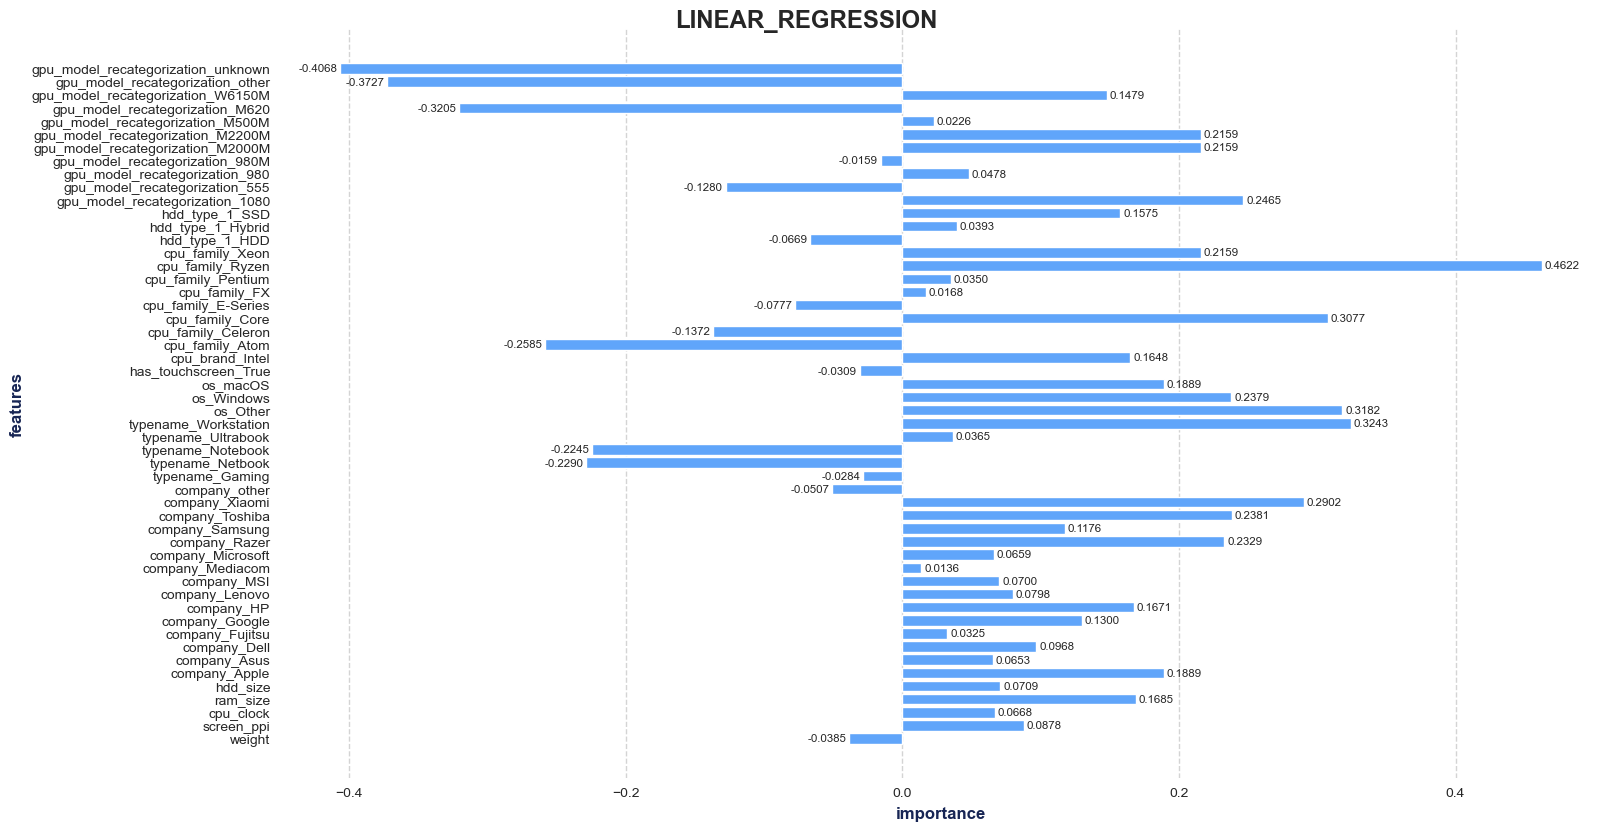

In [320]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
#print(columns_encoded_ohe)

#preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
#columns_encoded_oe = preprocess["to_encode_oe"].get_feature_names_out()
#print(columns_encoded_oe)

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
#    columns_encoded_oe
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="linear_regression")

plot_feature_importance(data)

In [321]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.2f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)

--------------------
Train RMSE: 277.764
Train R2: 82.87
--------------------
Test RMSE: 323.484
Test R2: 75.46
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. T

In [ ]:
--------------------
Train RMSE: 274.473
Train R2: 83.28
--------------------
Test RMSE: 325.598
Test R2: 75.04
--------------------

#### `ElasticNET`

Entrenamos un modelo `ElasticNET` para lograr un mejor rendimiento. Ya hemos visualizado anteriormente que los cambios realizados han mejorado nuestro modelo `LinearRegression`.

In [220]:
from sklearn.linear_model import ElasticNet

In [312]:
elastic_net = ElasticNet(
	alpha=0.1,
	l1_ratio=0.3,
	max_iter=5000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [226]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...n <lambda> at 0x7d4aa9cf6fc0>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_model_recategorization'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.1,
                                                                 l1_ratio=0.3,
                                                                 max_iter=5000,
                                                                 random_state=42))]))

Ordenada al origen: 6.71406327860524


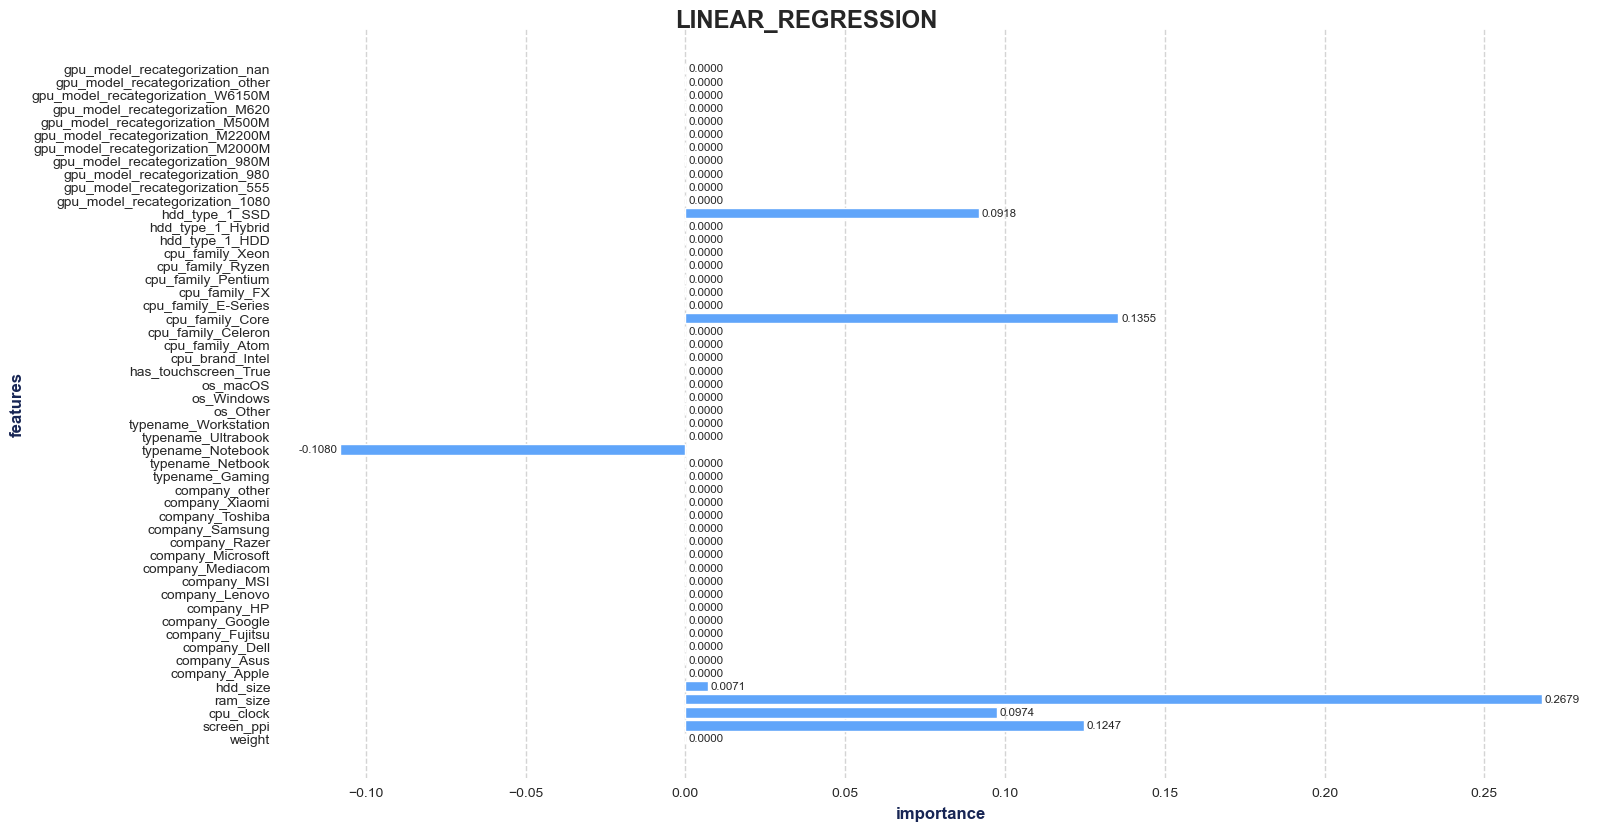

In [227]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
#print(columns_encoded_ohe)

#preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
#columns_encoded_oe = preprocess["to_encode_oe"].get_feature_names_out()
#print(columns_encoded_oe)

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
#    columns_encoded_oe
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="linear_regression")

plot_feature_importance(data)

In [228]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.2f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. T

--------------------
Train RMSE: 390.420
Train R2: 66.18
--------------------
Test RMSE: 391.683
Test R2: 64.39
--------------------


##### GridSearchCV

In [322]:
elastic_net = ElasticNet(
	max_iter=5000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [323]:
params = {
	"regressor__regressor__alpha": np.logspace(-3, 1, 12),
	"regressor__regressor__l1_ratio": np.logspace(-2, 1, 10)
}

grid_search = GridSearchCV(
	estimator=model,
	param_grid=params,
	cv=repeated_kfold,
	refit=True,
	scoring="neg_root_mean_squared_error",
	n_jobs=-1,
	verbose=2,
)
grid_search.fit(df_train, df_train["price"])

Fitting 25 folds for each of 120 candidates, totalling 3000 fits


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. T

[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.046415888336127774; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.046415888336127774; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] 

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.021544346900318832; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.046415888336127774; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.046415888336127774; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.001, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__reg

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. Thes


[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.046415888336127774; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_rati

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform


[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=2.154434690031882; total time=   0.0s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=2.154434690031882; total time=   

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. T


[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.1; total time=   0.2s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.012328467394420659, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__reg

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.1; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.46415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=2.154434690031882; total time=   0.0s
[CV] END regressor__regres

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 7] during tra


[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=0.21544346900318834; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.0s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ra

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform


[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=1.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=4.6415888336127775; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.1519911082952933, regressor__regressor__l1_ratio=10.0; total time=   0.1s
[CV] END regressor__regressor__alpha=0.3511191734215131, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.3511191734215131, regressor__regressor__l1_ratio=0.01; total time=   0.1s
[CV] END regressor__regressor__alpha=0.3511191734215131, regressor__regressor__l1_r

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform

GridSearchCV(cv=RepeatedKFold(n_repeats=5, n_splits=5, random_state=42),
             estimator=TransformedTargetRegressor(func=<ufunc 'log1p'>,
                                                  inverse_func=<ufunc 'expm1'>,
                                                  regressor=Pipeline(steps=[('preprocessing',
                                                                             ColumnTransformer(n_jobs=-1,
                                                                                               transformers=[('to_logn',
                                                                                                              Pipeline(steps=[('logn',
                                                                                                                               FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                                              ('scale',
                                                                                                                               StandardScaler())]),
                                                                                                              ['we...
             param_grid={'regressor__regressor__alpha': array([1.00000000e-03, 2.31012970e-03, 5.33669923e-03, 1.23284674e-02,
       2.84803587e-02, 6.57933225e-02, 1.51991108e-01, 3.51119173e-01,
       8.11130831e-01, 1.87381742e+00, 4.32876128e+00, 1.00000000e+01]),
                         'regressor__regressor__l1_ratio': array([ 0.01      ,  0.02154435,  0.04641589,  0.1       ,  0.21544347,
        0.46415888,  1.        ,  2.15443469,  4.64158883, 10.        ])},
             scoring='neg_root_mean_squared_error', verbose=2)

In [324]:
print("BEST PARAMS:\n", grid_search.best_params_)
print()
print("BEST SCORE:\n", -grid_search.best_score_)

BEST PARAMS:
 {'regressor__regressor__alpha': np.float64(0.001), 'regressor__regressor__l1_ratio': np.float64(0.01)}

BEST SCORE:
 322.294987380691


Ordenada al origen: 6.528248356347351
weight                               -0.038477
screen_ppi                            0.087771
cpu_clock                             0.066780
ram_size                              0.168532
hdd_size                              0.070864
company_Apple                         0.188935
company_Asus                          0.065299
company_Dell                          0.096823
company_Fujitsu                       0.032462
company_Google                        0.129965
company_HP                            0.167111
company_Lenovo                        0.079817
company_MSI                           0.069962
company_Mediacom                      0.013610
company_Microsoft                     0.065895
company_Razer                         0.232880
company_Samsung                       0.117605
company_Toshiba                       0.238130
company_Xiaomi                        0.290224
company_other                        -0.050717
typename_Gaming       

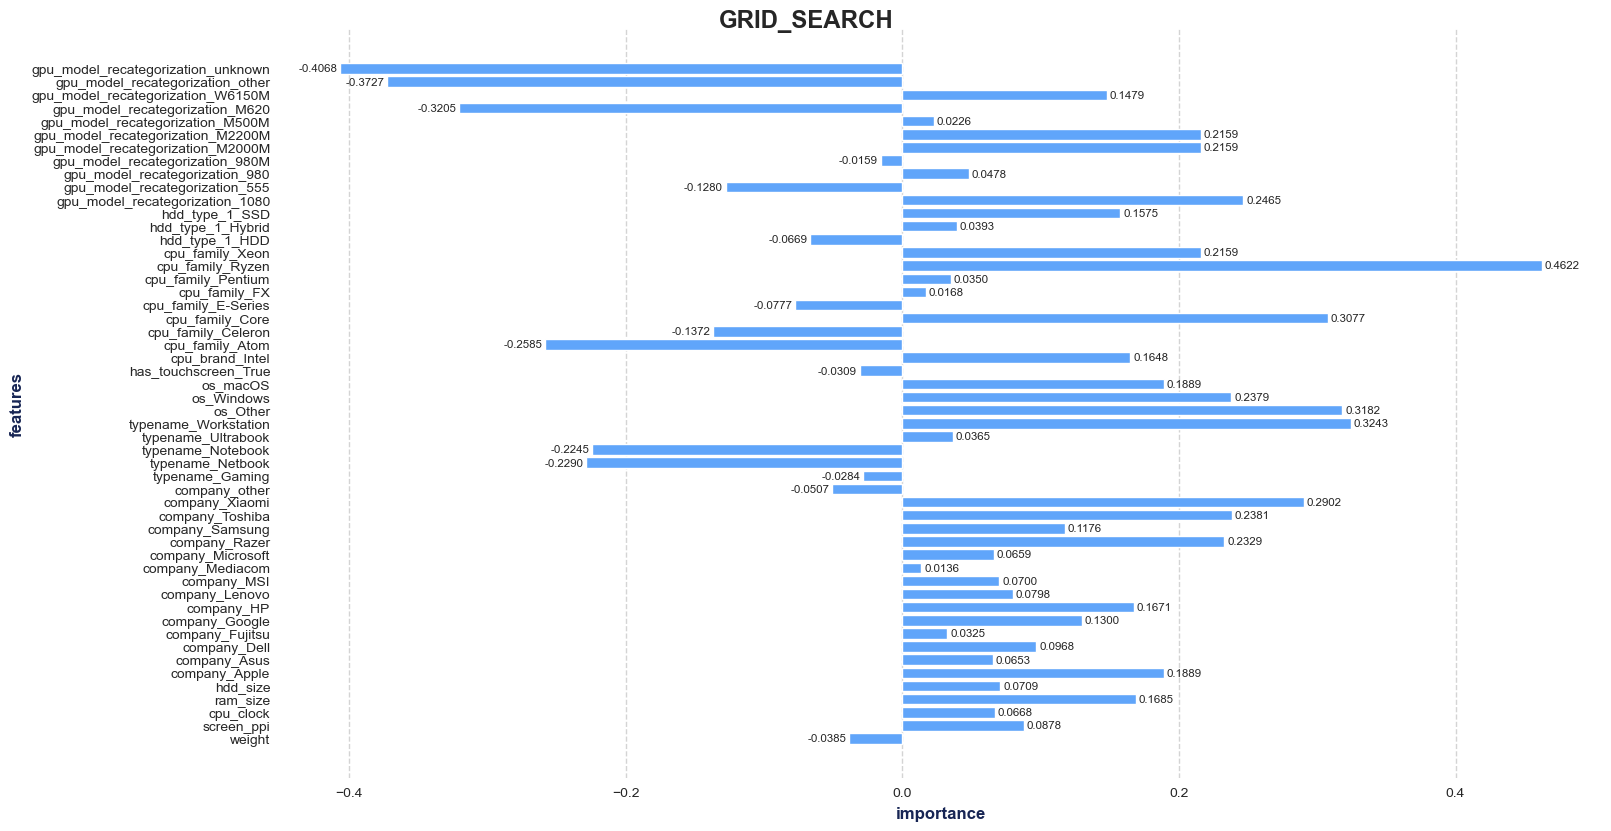

In [325]:
gs = grid_search.best_estimator_
intercept = gs.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = gs.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
#print(columns_encoded_ohe)

#preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
#columns_encoded_oe = preprocess["to_encode_oe"].get_feature_names_out()
#print(columns_encoded_oe)

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
#    columns_encoded_oe
])

data = gs.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="grid_search")

print(data)
plot_feature_importance(data)

In [433]:
elastic_net = ElasticNet(
	alpha=.001,
	l1_ratio=.01,
	max_iter=5000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [434]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTran...ambda> at 0x7d4a8617c0e0>)),
                                                                                                       ('scale',
                                                                                                        StandardScaler())]),
                                                                                       ['ram_size',
                                                                                        'hdd_size']),
                                                                                      ('to_encode_ohe',
                                                                                       OneHotEncoder(drop='first',
                                                                                                     handle_unknown='ignore'),
                                                                                       ['company',
                                                                                        'typename',
                                                                                        'os',
                                                                                        'has_touchscreen',
                                                                                        'cpu_brand',
                                                                                        'cpu_family',
                                                                                        'hdd_type_1',
                                                                                        'gpu_model_recategorization'])])),
                                                     ('regressor',
                                                      ElasticNet(alpha=0.001,
                                                                 l1_ratio=0.01,
                                                                 max_iter=5000,
                                                                 random_state=42))]))

Ordenada al origen: 6.528248356347351


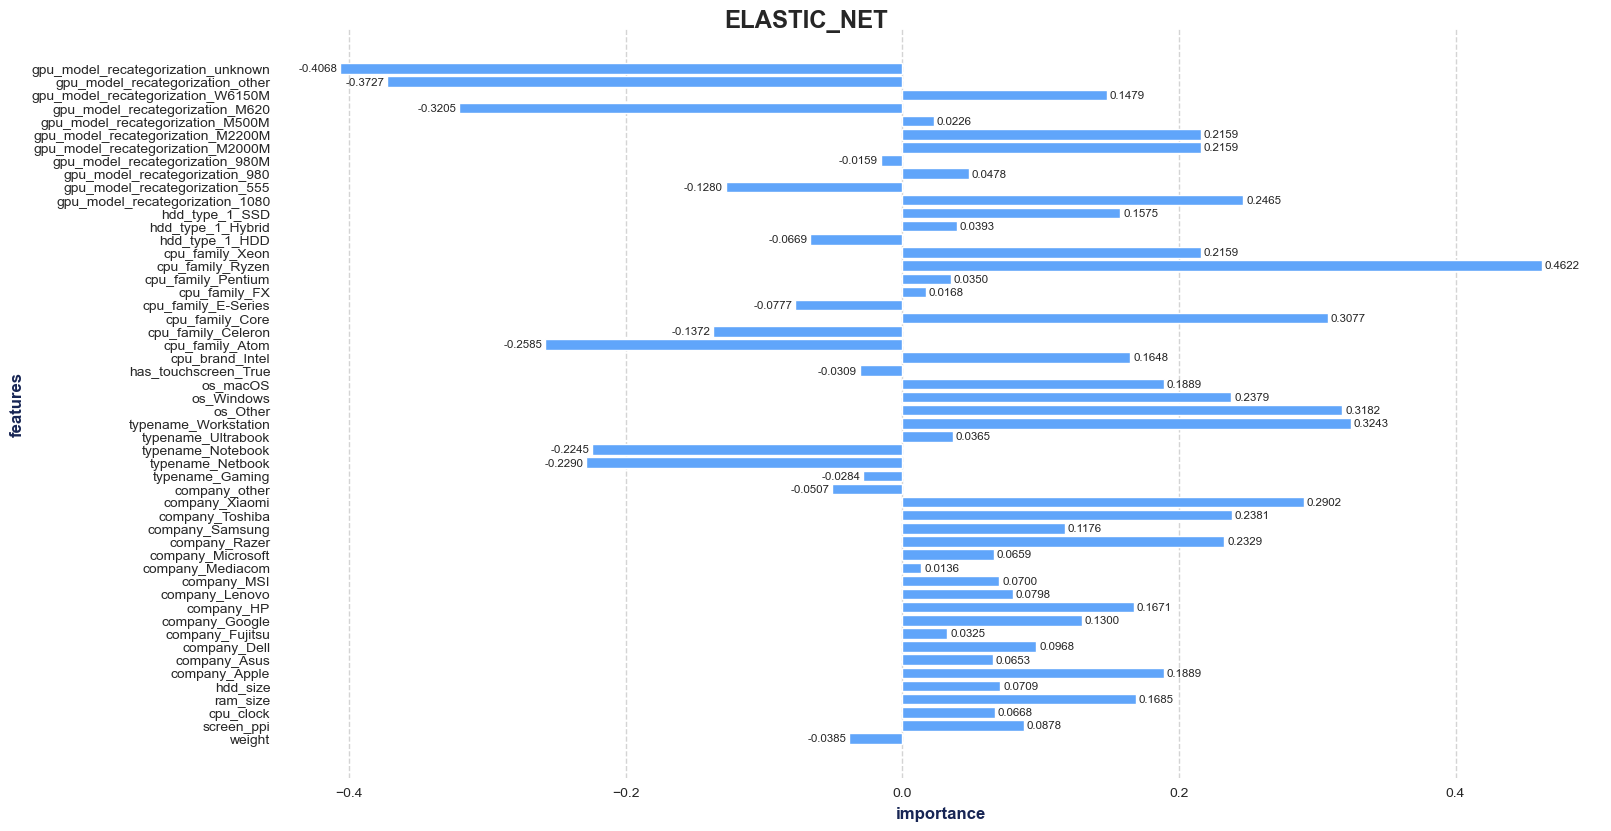

In [328]:
intercept = model.regressor_.named_steps["regressor"].intercept_
print("Ordenada al origen:", intercept)

preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_encoded_ohe = preprocess["to_encode_ohe"].get_feature_names_out()
#print(columns_encoded_ohe)

#preprocess = model.regressor_.named_steps["preprocessing"].named_transformers_
#columns_encoded_oe = preprocess["to_encode_oe"].get_feature_names_out()
#print(columns_encoded_oe)

index = np.hstack([
	columns_to_logn,
	columns_to_log2,
	columns_encoded_ohe,
#    columns_encoded_oe
])

data = model.regressor_.named_steps["regressor"].coef_.ravel()
data = pd.Series(data, index=index, name="elastic_net")

plot_feature_importance(data)

In [435]:
results = cross_validate(model,
						 df_train,
						 df_train["price"],
						 cv=repeated_kfold,
						 return_train_score=True,
						 scoring=["neg_root_mean_squared_error", "r2"],
						 n_jobs=-1)

print("-"*20)
rmse = np.mean(-results["train_neg_root_mean_squared_error"])
print(f"Train RMSE: {rmse:.3f}")
print(f"Train R2: {np.mean(results["train_r2"] * 100):.2f}")
print("-"*20)
rmse = np.mean(-results["test_neg_root_mean_squared_error"])
print(f"Test RMSE: {rmse:.3f}")
print(f"Test R2: {np.mean(results["test_r2"] * 100):.2f}")
print("-"*20)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [5] during transform

--------------------
Train RMSE: 278.216
Train R2: 82.83
--------------------
Test RMSE: 322.295
Test R2: 76.15
--------------------


/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [0, 5, 7] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


#### `XGBRegressor`

In [344]:
xgboost = XGBRegressor(
	n_estimators=200,
	learning_rate=0.03,
	max_depth=3,          # CLAVE
	min_child_weight=20,  # CLAVE
	subsample=0.7,
	colsample_bytree=0.7,
	reg_alpha=1.0,        # L1
	reg_lambda=5.0,       # L2
	gamma=0.1,
	random_state=42
)

pipeline = Pipeline(
	steps=[
		("preprocessing", trees_transformer),
		("regressor", xgboost)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [345]:
model.fit(df_train, df_train["price"])

TransformedTargetRegressor(func=<ufunc 'log1p'>, inverse_func=<ufunc 'expm1'>,
                           regressor=Pipeline(steps=[('preprocessing',
                                                      ColumnTransformer(n_jobs=-1,
                                                                        transformers=[('to_logn',
                                                                                       Pipeline(steps=[('logn',
                                                                                                        FunctionTransformer(func=<ufunc 'log1p'>))]),
                                                                                       ['weight',
                                                                                        'screen_ppi',
                                                                                        'cpu_clock']),
                                                                                      ('to_log2',
                                                                                       Pipeline(steps=[('log2',
                                                                                                        FunctionTransformer(func=<function <lamb...
                                                                   feature_weights=None,
                                                                   gamma=0.1,
                                                                   grow_policy=None,
                                                                   importance_type=None,
                                                                   interaction_constraints=None,
                                                                   learning_rate=0.03,
                                                                   max_bin=None,
                                                                   max_cat_threshold=None,
                                                                   max_cat_to_onehot=None,
                                                                   max_delta_step=None,
                                                                   max_depth=3,
                                                                   max_leaves=None,
                                                                   min_child_weight=20,
                                                                   missing=nan,
                                                                   monotone_constraints=None,
                                                                   multi_strategy=None,
                                                                   n_estimators=200,
                                                                   n_jobs=None,
                                                                   num_parallel_tree=None, ...))]))

In [346]:
oob_score = model.regressor_.named_steps["regressor"].oob_score_
print("oob_score:", oob_score)

features = model.regressor_.named_steps["preprocessing"].named_transformers_
columns_ohe = features["to_encode_ohe"].get_feature_names_out()


columns = np.hstack([columns_to_logn, columns_to_log2, columns_ohe])
data = model.regressor_["regressor"].feature_importances_
data = pd.Series(data, index=columns, name="random_forest")

plot_feature_importance(data)

AttributeError: 'XGBRegressor' object has no attribute 'oob_score_'

{'f0': 0.9802900552749634,
 'f1': 1.4878790378570557,
 'f2': 1.498015284538269,
 'f3': 15.465253829956055,
 'f4': 0.6468023657798767,
 'f5': 0.22387398779392242,
 'f7': 0.22873546183109283,
 'f8': 0.20059970021247864,
 'f11': 0.5510939359664917,
 'f12': 0.14865955710411072,
 'f18': 0.19894838333129883,
 'f22': 0.19970180094242096,
 'f24': 8.567891120910645,
 'f27': 0.824040949344635,
 'f29': 0.8584016561508179,
 'f31': 0.6243056654930115,
 'f32': 0.3909045457839966,
 'f37': 2.2118897438049316,
 'f38': 5.2276225090026855,
 'f45': 2.9241738319396973,
 'f47': 10.863309860229492,
 'f58': 0.4629000127315521,
 'f59': 0.4489291310310364}

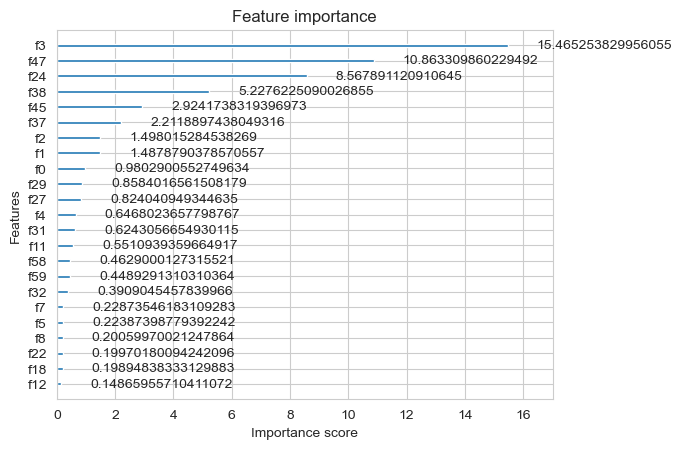

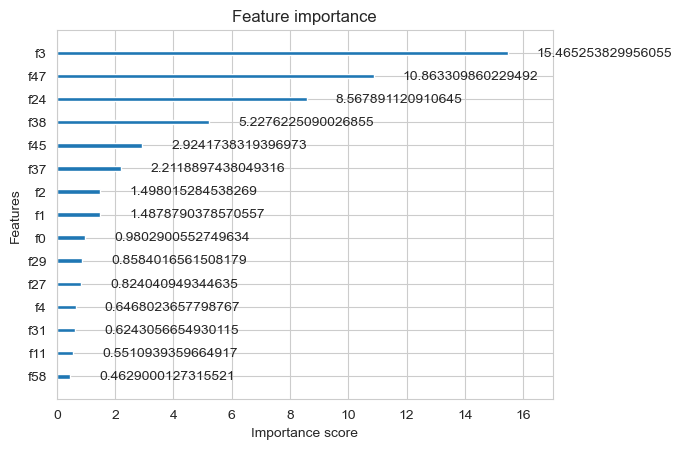

In [355]:
import xgboost as xgb

#model = model.regressor_["regressor"]
xgb.plot_importance(model, importance_type="gain")

booster = model.get_booster()
xgb.plot_importance(
    booster,
    importance_type="gain",
    max_num_features=15
)
booster.get_score(importance_type="gain")

-----------------------------------------------------------------

## Una vez listo el modelo, toca predecir ``test.csv``

**RECUERDA: APLICAR LAS TRANSFORMACIONES QUE HAYAS REALIZADO EN `train.csv` a `test.csv`.**


Véase:
- Estandarización/Normalización
- Eliminación de Outliers
- Eliminación de columnas
- Creación de columnas nuevas
- Gestión de valores nulos
- Y un largo etcétera de técnicas que como Data Scientist hayas considerado las mejores para tu dataset.

## 1. Carga los datos de `test.csv` para predecir.


In [364]:
X_pred = pd.read_csv("./data/test.csv")
X_pred.head()

laptop_ID Company                          Product            TypeName  \
0        209  Lenovo               Legion Y520-15IKBN              Gaming   
1       1281    Acer                   Aspire ES1-531            Notebook   
2       1168  Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3       1231    Dell                    Inspiron 7579  2 in 1 Convertible   
4       1020      HP                      ProBook 640            Notebook   

   Inches                           ScreenResolution  \
0    15.6                          Full HD 1920x1080   
1    15.6                                   1366x768   
2    15.6                                   1366x768   
3    15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4    14.0                          Full HD 1920x1080   

                                    Cpu   Ram     Memory  \
0           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD   
1  Intel Celeron Dual Core N3060 1.6GHz   4GB  500GB HDD   
2            Intel Core i3 6006U 2.0GHz   4GB    1TB HDD   
3            Intel Core i5 7200U 2.5GHz   8GB  256GB SSD   
4            Intel Core i5 7200U 2.5GHz   4GB  256GB SSD   

                       Gpu       OpSys   Weight  
0  Nvidia GeForce GTX 1060       No OS    2.4kg  
1    Intel HD Graphics 400       Linux    2.4kg  
2    Intel HD Graphics 520       No OS    1.9kg  
3    Intel HD Graphics 620  Windows 10  2.191kg  
4    Intel HD Graphics 620  Windows 10   1.95kg

In [358]:
X_pred.tail()

laptop_ID  Company          Product            TypeName  Inches  \
386        820      MSI      GE72MVR 7RG              Gaming    17.3   
387        948  Toshiba  Tecra Z40-C-12X            Notebook    14.0   
388        483     Dell  Precision M5520         Workstation    15.6   
389       1017       HP      Probook 440            Notebook    14.0   
390        421     Asus     ZenBook Flip  2 in 1 Convertible    13.3   

                              ScreenResolution                          Cpu  \
386                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
387                IPS Panel Full HD 1920x1080   Intel Core i5 6200U 2.3GHz   
388                          Full HD 1920x1080  Intel Core i7 7700HQ 2.8GHz   
389                                   1366x768   Intel Core i5 7200U 2.5GHz   
390  IPS Panel Full HD / Touchscreen 1920x1080   Intel Core i5 7200U 2.5GHz   

      Ram                Memory                      Gpu       OpSys  Weight  
386  16GB  512GB SSD +  1TB HDD  Nvidia GeForce GTX 1070  Windows 10   2.9kg  
387   4GB             128GB SSD    Intel HD Graphics 520  Windows 10  1.47kg  
388   8GB             256GB SSD      Nvidia Quadro M1200  Windows 10  1.78kg  
389   4GB             500GB HDD    Intel HD Graphics 620  Windows 10  1.64kg  
390   8GB             256GB SSD    Intel HD Graphics 620  Windows 10  1.27kg

In [359]:
X_pred.info()

<class 'pandas.DataFrame'>
RangeIndex: 391 entries, 0 to 390
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   laptop_ID         391 non-null    int64  
 1   Company           391 non-null    str    
 2   Product           391 non-null    str    
 3   TypeName          391 non-null    str    
 4   Inches            391 non-null    float64
 5   ScreenResolution  391 non-null    str    
 6   Cpu               391 non-null    str    
 7   Ram               391 non-null    str    
 8   Memory            391 non-null    str    
 9   Gpu               391 non-null    str    
 10  OpSys             391 non-null    str    
 11  Weight            391 non-null    str    
dtypes: float64(1), int64(1), str(10)
memory usage: 36.8 KB


 ## 2. Replicar el procesado para ``test.csv``

In [360]:
X_pred

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu       OpSys   Weight  
0    Nvidia GeForce GTX 1060       No OS    2.4kg  
1      Intel HD Graphics 400       Linux    2.4kg  
2      Intel HD Graphics 520       No OS    1.9kg  
3      Intel HD Graphics 620  Windows 10  2.191kg  
4      Intel HD Graphics 620  Windows 10   1.95kg  
..                       ...         ...      ...  
386  Nvidia GeForce GTX 1070  Windows 10    2.9kg  
387    Intel HD Graphics 520  Windows 10   1.47kg  
388      Nvidia Quadro M1200  Windows 10   1.78kg  
389    Intel HD Graphics 620  Windows 10   1.64kg  
390    Intel HD Graphics 620  Windows 10   1.27kg  

[391 rows x 12 columns]

### `ScreenResolution`

In [ ]:
screen_data = X_pred["ScreenResolution"].apply(extract_screen_data)
X_pred = pd.concat([X_pred, pd.DataFrame(screen_data.tolist())], axis=1)
columns = [
	"ScreenResolution",
	"has_touchscreen",
	"screen_panel",
	"screen_type",
	"screen_resolution"
]
X_pred.sample(5).loc[:, columns]

ScreenResolution  has_touchscreen screen_panel  \
106  4K Ultra HD / Touchscreen 3840x2160             True          NaN   
9                      Full HD 1920x1080            False          NaN   
107                             1366x768            False          NaN   
142   IPS Panel Retina Display 2304x1440            False    IPS Panel   
109                    Full HD 1920x1080            False          NaN   

    screen_type screen_resolution  
106    Ultra HD         3840x2160  
9       Full HD         1920x1080  
107         NaN          1366x768  
142         NaN         2304x1440  
109     Full HD         1920x1080

In [366]:
X_pred["screen_type"] = X_pred["screen_resolution"].apply(screen_tier)

In [367]:
data = X_pred["screen_resolution"].str.split("x", expand=True).astype(int)
X_pred = pd.concat(
	[
		X_pred,
		data.rename(columns={
			0: "screen_width",
			1: "screen_height"
		})
	],
	axis=1
)

X_pred["screen_ppi"] = round(
	((X_pred["screen_width"]**2 + X_pred["screen_height"]**2)**0.5)/X_pred["Inches"],
	2
)

In [368]:
columns = df.iloc[:, -4:].columns
for column in columns:
	df[column] = df[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(df[column].value_counts())
	print("-"*30)

gpu_family
HD             445
GeForce GTX    170
GeForce         90
UHD             52
Radeon R5       39
Radeon          34
Quadro          19
Radeon R7       14
Radeon RX       10
Iris Plus        8
Radeon R4        7
Radeon R2        7
FirePro          4
GeForce GT       4
Iris             3
Radeon Pro       2
Iris Pro         1
GTX              1
R1               1
R4               1
Name: count, dtype: int64
------------------------------
gpu_model
620       238
520       137
1050       48
940MX      38
1060       31
         ... 
M620M       1
555         1
M2000M      1
940M        1
1070M       1
Name: count, Length: 69, dtype: int64
------------------------------
gpu_integrated
True     509
False    403
Name: count, dtype: int64
------------------------------
has_hdd2
False    768
True     144
Name: count, dtype: int64
------------------------------


In [369]:
X_pred["screen_resolution"] = X_pred["screen_resolution"].astype("category")
X_pred["screen_type"] = X_pred["screen_type"].astype("category")
X_pred["screen_panel"] = X_pred["screen_panel"].astype("category")

### `CPU`

In [406]:
cpu_data = pd.DataFrame(X_pred.loc[:, "Cpu"].apply(extract_cpu_data).tolist())
X_pred = pd.concat([X_pred, cpu_data], axis=1)

columns = [
	"Cpu",
	"cpu_brand",
	"cpu_family",
	"cpu_series",
	"cpu_gen",
	"cpu_clock",
]
X_pred.sample(5).loc[:, columns]

Samsung Cortex A72&A53 2.0GHz


Cpu cpu_brand cpu_family cpu_series cpu_gen  \
219   Intel Core i3 7100U 2.4GHz     Intel       Core         i3       7   
278  Intel Core i5 7300HQ 2.5GHz     Intel       Core         i5       7   
380      AMD A9-Series 9420 3GHz       AMD   A-Series         A9       9   
373    Intel Core i5 7Y54 1.2GHz     Intel       Core         i5     NaN   
72    Intel Core i5 7200U 2.5GHz     Intel       Core         i5       7   

    cpu_clock  
219       2.4  
278       2.5  
380         3  
373       1.2  
72        2.5

In [407]:
X_pred.fillna({"cpu_series": "unknown"}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... screen_type screen_resolution  screen_width  \
0    Nvidia GeForce GTX 1060  ...     Full HD         1920x1080          1920   
1      Intel HD Graphics 400  ...          HD          1366x768          1366   
2      Intel HD Graphics 520  ...          HD          1366x768          1366   
3      Intel HD Graphics 620  ...     Full HD         1920x1080          1920   
4      Intel HD Graphics 620  ...     Full HD         1920x1080          1920   
..                       ...  ...         ...               ...           ...   
386  Nvidia GeForce GTX 1070  ...     Full HD         1920x1080          1920   
387    Intel HD Graphics 520  ...     Full HD         1920x1080          1920   
388      Nvidia Quadro M1200  ...     Full HD         1920x1080          1920   
389    Intel HD Graphics 620  ...          HD          1366x768          1366   
390    Intel HD Graphics 620  ...     Full HD         1920x1080          1920   

    screen_height screen_ppi cpu_brand  cpu_family  cpu_series  cpu_gen  \
0            1080     141.21     Intel        Core          i7        7   
1             768     100.45     Intel     Celeron   Dual Core        3   
2             768     100.45     Intel        Core          i3        6   
3            1080     141.21     Intel        Core          i5        7   
4            1080     157.35     Intel        Core          i5        7   
..            ...        ...       ...         

In [408]:
X_pred["cpu_brand"] = X_pred["cpu_brand"].astype("category")
X_pred["cpu_clock"] = X_pred["cpu_clock"].astype(float)
X_pred["cpu_family"] = X_pred["cpu_family"].astype("category")
X_pred["cpu_series"] = X_pred["cpu_series"].astype("category")
X_pred["cpu_gen"] = X_pred["cpu_gen"].astype(float)

### `RAM`

In [409]:
ram_data = X_pred.loc[:, "Ram"].apply(extract_ram_data)
X_pred = pd.concat([X_pred, ram_data], axis=1)

columns = ["Ram", "ram_size", "ram_capacity"]
X_pred.sample(5).loc[:, columns]

Ram ram_size ram_capacity
223  8GB        8           GB
331  8GB        8           GB
180  4GB        4           GB
31   4GB        4           GB
134  4GB        4           GB

### `HDD`

In [410]:
memory_data = X_pred.loc[:, "Memory"].apply(extract_memory_data)
X_pred = pd.concat([X_pred, memory_data], axis=1)

columns = [
	"Memory",
	"hdd_size_1",
	"hdd_capacity_1",
	"hdd_type_1",
	"hdd_size_2",
	"hdd_capacity_2",
	"hdd_type_2"
]
X_pred.sample(5).loc[:, columns]

Memory hdd_size_1 hdd_capacity_1 hdd_type_1 hdd_size_2 hdd_capacity_2  \
194  500GB HDD        500             GB        HDD        NaN            NaN   
331  256GB SSD        256             GB        SSD        NaN            NaN   
11   256GB SSD        256             GB        SSD        NaN            NaN   
89   500GB HDD        500             GB        HDD        NaN            NaN   
74   256GB SSD        256             GB        SSD        NaN            NaN   

    hdd_type_2  
194        NaN  
331        NaN  
11         NaN  
89         NaN  
74         NaN

In [412]:
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].str.replace("1.0", "1")
X_pred["hdd_size_1"] = X_pred["hdd_size_1"].astype(int)

X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(float)

X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].astype("category")
X_pred["hdd_type_1"] = X_pred["hdd_type_1"].astype("category")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].astype("category")

#X_pred["hdd_type_2"] = X_pred["hdd_type_2"].astype("category")
columns = X_pred.iloc[:, -6:].columns
for column in columns:
	X_pred[column] = X_pred[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(X_pred[column].value_counts())
	print("-"*30)

hdd_size_1
256    159
1       77
128     50
512     44
500     40
2        8
32       6
64       4
180      2
16       1
Name: count, dtype: int64
------------------------------
hdd_capacity_1
GB    306
TB     85
Name: count, dtype: int64
------------------------------
hdd_type_1
SSD              256
HDD              119
Flash Storage     12
Hybrid             4
Name: count, dtype: int64
------------------------------
hdd_size_2
1.0      56
2.0       6
256.0     1
500.0     1
Name: count, dtype: int64
------------------------------
hdd_capacity_2
TB    62
GB     2
Name: count, dtype: int64
------------------------------
hdd_type_2
HDD       61
Hybrid     2
SSD        1
Name: count, dtype: int64
------------------------------


### `GPU`

In [413]:
columns = ["gpu_brand", "gpu_family", "gpu_model"]
data = X_pred["Gpu"].apply(extract_gpu_data)
data = pd.DataFrame(data, columns=columns)
X_pred = pd.concat([X_pred, data], axis=1)

columns.insert(0, "Gpu")
X_pred.sample(5).loc[:, columns]

Gpu gpu_brand    gpu_family gpu_model
210      AMD Radeon R7 M360       AMD     Radeon R7      M360
86    Intel HD Graphics 500     Intel   HD Graphics       500
156   Intel HD Graphics 620     Intel   HD Graphics       620
237  Intel UHD Graphics 620     Intel  UHD Graphics       620
51     Nvidia GeForce MX150    Nvidia       GeForce     MX150

In [ ]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand   gpu_family gpu_model
27        ARM Mali T860 MP4       NaN          NaN       NaN
108       Intel HD Graphics     Intel  HD Graphics       NaN
133  Nvidia GeForce GTX1080       NaN          NaN       NaN
136  Nvidia GeForce GTX1060       NaN          NaN       NaN
139       Intel HD Graphics     Intel  HD Graphics       NaN
195       Intel HD Graphics     Intel  HD Graphics       NaN
346       Intel HD Graphics     Intel  HD Graphics       NaN

In [417]:
X_pred.loc[133, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"
X_pred.loc[136, "Gpu"] = "Nvidia GeForce GTX 1050 Ti"

pattern = r"(?P<brand>nvidia) (?P<family>(geforce(\sgtx?)?)|quadro|gtx) (?P<model>([a-z])?([a-z]?\d{1,4}([a-z]{1,2})?(\sti|\ssli)?))"
is_match = re.search(pattern, X_pred.loc[133, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[133, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[133, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[133, "gpu_model"] = is_match.group("model").strip()

is_match = re.search(pattern, X_pred.loc[136, "Gpu"], re.IGNORECASE)
if is_match:
	X_pred.loc[136, "gpu_brand"] = is_match.group("brand").strip() if is_match.group("brand") else None
	X_pred.loc[136, "gpu_family"] = is_match.group("family").strip() if is_match.group("family") else None
	X_pred.loc[136, "gpu_model"] = is_match.group("model").strip()


X_pred["gpu_family"] = X_pred["gpu_family"].str.replace("Graphics", "")

In [418]:
mask = X_pred[columns].isna().any(axis=1)
X_pred.loc[mask, columns]

Gpu gpu_brand gpu_family gpu_model
27   ARM Mali T860 MP4       NaN        NaN       NaN
108  Intel HD Graphics     Intel        HD        NaN
139  Intel HD Graphics     Intel        HD        NaN
195  Intel HD Graphics     Intel        HD        NaN
346  Intel HD Graphics     Intel        HD        NaN

In [419]:
X_pred.fillna({
	"gpu_brand": "Intel",
	"gpu_family": "HD",
	"gpu_model": "unknown",
}, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches                           ScreenResolution  \
0      15.6                          Full HD 1920x1080   
1      15.6                                   1366x768   
2      15.6                                   1366x768   
3      15.6  IPS Panel Full HD / Touchscreen 1920x1080   
4      14.0                          Full HD 1920x1080   
..      ...                                        ...   
386    17.3                          Full HD 1920x1080   
387    14.0                IPS Panel Full HD 1920x1080   
388    15.6                          Full HD 1920x1080   
389    14.0                                   1366x768   
390    13.3  IPS Panel Full HD / Touchscreen 1920x1080   

                                      Cpu   Ram                Memory  \
0             Intel Core i7 7700HQ 2.8GHz  16GB             512GB SSD   
1    Intel Celeron Dual Core N3060 1.6GHz   4GB             500GB HDD   
2              Intel Core i3 6006U 2.0GHz   4GB               1TB HDD   
3              Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   
4              Intel Core i5 7200U 2.5GHz   4GB             256GB SSD   
..                                    ...   ...                   ...   
386           Intel Core i7 7700HQ 2.8GHz  16GB  512GB SSD +  1TB HDD   
387            Intel Core i5 6200U 2.3GHz   4GB             128GB SSD   
388           Intel Core i7 7700HQ 2.8GHz   8GB             256GB SSD   
389            Intel Core i5 7200U 2.5GHz   4GB             500GB HDD   
390            Intel Core i5 7200U 2.5GHz   8GB             256GB SSD   

                         Gpu  ... ram_capacity hdd_size_1  hdd_capacity_1  \
0    Nvidia GeForce GTX 1060  ...           GB        512              GB   
1      Intel HD Graphics 400  ...           GB        500              GB   
2      Intel HD Graphics 520  ...           GB          1              TB   
3      Intel HD Graphics 620  ...           GB        256              GB   
4      Intel HD Graphics 620  ...           GB        256              GB   
..                       ...  ...          ...        ...             ...   
386  Nvidia GeForce GTX 1070  ...           GB        512              GB   
387    Intel HD Graphics 520  ...           GB        128              GB   
388      Nvidia Quadro M1200  ...           GB        256              GB   
389    Intel HD Graphics 620  ...           GB        500              GB   
390    Intel HD Graphics 620  ...           GB        256              GB   

    hdd_type_1 hdd_size_2 hdd_capacity_2  hdd_type_2  gpu_brand   gpu_family  \
0          SSD        NaN            NaN         NaN     Nvidia  GeForce GTX   
1          HDD        NaN            NaN         NaN      Intel          HD    
2          HDD        NaN            NaN         NaN      Intel          HD    
3          SSD        NaN            NaN         NaN      Intel          HD    
4          SSD        NaN            NaN         NaN      Intel          HD    
..         ...        ...            ...         ...        ...  

In [420]:
X_pred["gpu_brand"] = X_pred["gpu_brand"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")
X_pred["gpu_model"] = X_pred["gpu_model"].astype("category")

columns = X_pred.iloc[:, -3:].columns
for column in columns:
	X_pred[column] = X_pred[column].apply(lambda x: x.strip() if isinstance(x, str) else x)
	print(X_pred[column].value_counts())
	print("-"*30)

gpu_brand
Intel     214
Nvidia    116
AMD        61
Name: count, dtype: int64
------------------------------
gpu_family
HD             196
GeForce GTX     68
GeForce         35
Radeon          25
UHD             16
Radeon R5       15
Radeon R7       12
Quadro          12
Iris Plus        2
Radeon RX        2
Radeon R2        2
Radeon R9        1
Radeon Pro       1
GeForce GT       1
FirePro          1
Radeon R4        1
Radeon R3        1
Name: count, dtype: int64
------------------------------
gpu_model
620        112
520         66
530         20
1050        18
1060        17
940MX       14
500         12
            11
1050 Ti      9
1070         8
400          7
M445         7
930MX        6
MX150        5
unknown      5
1080         4
505          4
615          4
920MX        4
980M         4
M1200        4
M430         4
515          3
960M         3
M330         3
MX130        3
630          2
640          2
M2200        2
M440         2
M520M        2
1050Ti       1
150MX     

### `Limpieza`

In [421]:
to_delete = ["ScreenResolution", "Cpu", "Gpu", "Memory", "Ram"]
X_pred.drop(columns=to_delete, inplace=True)

X_pred["Company"] = X_pred["Company"].astype("category")
X_pred["TypeName"] = X_pred["TypeName"].astype("category")
# X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["Inches"] = X_pred["Inches"].astype(float)
X_pred["Weight"] = X_pred["Weight"].apply(lambda x: x.replace("kg", ""))
X_pred["Weight"] = X_pred["Weight"].astype(float)

In [422]:
maps = {
	"OpSys": {
		"Windows 7": "Windows",
		"Windows 10 S": "Windows",
		"Windows 10": "Windows",
		"Mac OS X": "macOS",
	}
}

X_pred.replace(maps, inplace=True)

laptop_ID  Company                          Product            TypeName  \
0          209   Lenovo               Legion Y520-15IKBN              Gaming   
1         1281     Acer                   Aspire ES1-531            Notebook   
2         1168   Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
3         1231     Dell                    Inspiron 7579  2 in 1 Convertible   
4         1020       HP                      ProBook 640            Notebook   
..         ...      ...                              ...                 ...   
386        820      MSI                      GE72MVR 7RG              Gaming   
387        948  Toshiba                  Tecra Z40-C-12X            Notebook   
388        483     Dell                  Precision M5520         Workstation   
389       1017       HP                      Probook 440            Notebook   
390        421     Asus                     ZenBook Flip  2 in 1 Convertible   

     Inches    OpSys  Weight  has_touchscreen screen_panel screen_type  ...  \
0      15.6    No OS   2.400            False          NaN     Full HD  ...   
1      15.6    Linux   2.400            False          NaN          HD  ...   
2      15.6    No OS   1.900            False          NaN          HD  ...   
3      15.6  Windows   2.191             True    IPS Panel     Full HD  ...   
4      14.0  Windows   1.950            False          NaN     Full HD  ...   
..      ...      ...     ...              ...          ...         ...  ...   
386    17.3  Windows   2.900            False          NaN     Full HD  ...   
387    14.0  Windows   1.470            False    IPS Panel     Full HD  ...   
388    15.6  Windows   1.780            False          NaN     Full HD  ...   
389    14.0  Windows   1.640            False          NaN          HD  ...   
390    13.3  Windows   1.270             True    IPS Panel     Full HD  ...   

    ram_capacity  hdd_size_1  hdd_capacity_1  hdd_type_1 hdd_size_2  \
0             GB         512              GB         SSD        NaN   
1             GB         500              GB         HDD        NaN   
2             GB           1              TB         HDD        NaN   
3             GB         256              GB         SSD        NaN   
4             GB         256              GB         SSD        NaN   
..           ...         ...             ...         ...        ...   
386           GB         512              GB         SSD        1.0   
387           GB         128              GB         SSD        NaN   
388           GB         256              GB         SSD        NaN   
389           GB         500              GB         HDD        NaN   
390           GB         256              GB         SSD        NaN   

    hdd_capacity_2 hdd_type_2  gpu_brand   gpu_family gpu_model  
0              NaN        NaN     Nvidia  GeForce GTX      1060  
1              NaN        NaN      Intel           HD       400  
2              NaN        NaN      Intel           HD       520  
3              NaN        NaN      Intel           HD       620  
4              NaN        NaN      Intel           HD       620  
..             ...        ...        ...          ...       ...  
386             TB        HDD     Nvidia  GeForce GTX      1070  
387            NaN        NaN      Intel           HD       520  
388            NaN        NaN     Nvidia       Quadro     M1200  
389            NaN        NaN      Intel           HD       620  
390            NaN        NaN      Intel           HD       620  

[391 rows x 30 columns]

In [423]:
factor = {"GB": 1, "TB": 1024}
X_pred["hdd_size_1"] = X_pred["hdd_size_1"] * X_pred["hdd_capacity_1"].map(factor).astype(int)
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(float)

conditions = [
	X_pred["hdd_capacity_2"].str.lower() == "gb",
	X_pred["hdd_capacity_2"].str.lower() == "tb",
	X_pred["hdd_capacity_2"].isna()
]

choices = [
	X_pred["hdd_size_2"] * 1,
	X_pred["hdd_size_2"] * 1024,
	np.nan
]

X_pred["hdd_size_2"] = np.select(conditions,
							 choices,
							 default=X_pred["hdd_size_2"])

In [424]:
X_pred["hdd_capacity_1"] = X_pred["hdd_capacity_1"].str.replace("TB", "GB")
X_pred["hdd_capacity_2"] = X_pred["hdd_capacity_2"].str.replace("TB", "GB")

X_pred.fillna({"hdd_size_2": 0, "hdd_type_2": "unknown"},
		  inplace=True)

X_pred["hdd_type_2"] = X_pred["hdd_type_2"].astype("category")
X_pred["hdd_size_2"] = X_pred["hdd_size_2"].astype(int)

In [ ]:
X_pred.drop(columns=[
	"ram_capacity",
	"hdd_capacity_1",
	"hdd_capacity_2",
], inplace=True)


X_pred["gpu_integrated"] = X_pred["gpu_brand"].str.contains("intel", case=False)
X_pred["has_hdd2"] = X_pred["hdd_size_2"] != 0

X_pred["OpSys"] = X_pred["OpSys"].astype("category")
X_pred["gpu_family"] = X_pred["gpu_family"].astype("category")

In [427]:
X_pred.rename(str.lower, axis="columns", inplace=True)
X_pred.rename(columns={"opsys": "os", "price_in_euros": "price"}, inplace=True)

In [428]:
X_pred["hdd_size"] = (
	X_pred["hdd_size_1"] + X_pred["hdd_size_2"]
).astype(int)

X_pred[["hdd_size", "hdd_size_1", "hdd_size_2"]].sample(10)
X_pred["os"] = X_pred["os"].astype(str)

maps = {
	"os": {
		"Linux": "Free OS",
		"No OS": "Free OS",
		"Chrome OS": "Other",
		"Android": "Other",
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company                         product            typename  \
201       1274    Asus               Rog G752VT-GC073T              Gaming   
98         989      HP                     Probook 450            Notebook   
284        150    Asus  X541NA (N3350/4GB/1TB/FHD/W10)            Notebook   
88         159  Lenovo                  Yoga 520-14IKB  2 in 1 Convertible   
296       1259    Asus            ZenBook UX310UA-WB71           Ultrabook   

     inches       os  weight  has_touchscreen screen_panel screen_type  ...  \
201    17.3  Windows    4.00            False    IPS Panel     Full HD  ...   
98     15.6  Windows    2.04            False    IPS Panel     Full HD  ...   
284    15.6  Windows    2.00            False          NaN     Full HD  ...   
88     14.0  Windows    1.74             True    IPS Panel     Full HD  ...   
296    13.3  Windows    1.45            False          NaN     Full HD  ...   

    hdd_size_1  hdd_type_1  hdd_size_2  hdd_type_2 gpu_brand   gpu_family  \
201        128         SSD        1024         HDD    Nvidia  GeForce GTX   
98         128         SSD        1024         HDD    Nvidia      GeForce   
284       1024         HDD           0     unknown     Intel           HD   
88         256         SSD           0     unknown     Intel           HD   
296        256         SSD           0     unknown     Intel           HD   

    gpu_model  gpu_integrated  has_hdd2 hdd_size  
201      970M           False      True     1152  
98      930MX           False      True     1152  
284       500            True     False     1024  
88        620            True     False      256  
296       520            True     False      256  

[5 rows x 30 columns]

In [429]:
X_pred.fillna({"gpu_model": "unknown"}, inplace=True).sample(5)
X_pred["gpu_model_recategorization"] = X_pred[
	"gpu_model"
].apply(recategorization)

In [431]:
X_pred["company"] = X_pred["company"].astype(str)
maps = {
	"company": {
		"Chuwi": "other",
		"Huawei": "other",
		"LG": "other",
		"Vero": "other"
	}
}
X_pred.replace(maps, inplace=True).sample(5)

laptop_id company              product            typename  inches  \
350        122    Asus         VivoBook S15            Notebook    15.6   
357        392  Lenovo   Ideapad 510S-13IKB            Notebook    13.3   
42        1284      HP  Pavilion 15-AW003nv            Notebook    15.6   
39         858      HP       EliteBook x360  2 in 1 Convertible    13.3   
115        533  Lenovo    IdeaPad 320-15IKB            Notebook    15.6   

          os  weight  has_touchscreen screen_panel screen_type  ...  \
350  Windows    1.70            False          NaN     Full HD  ...   
357  Windows    1.50            False    IPS Panel     Full HD  ...   
42   Windows    2.04            False          NaN     Full HD  ...   
39   Windows    1.28             True          NaN     Full HD  ...   
115  Windows    2.20            False          NaN     Full HD  ...   

    hdd_type_1  hdd_size_2  hdd_type_2  gpu_brand gpu_family gpu_model  \
350        SSD           0     unknown     Nvidia    GeForce     940MX   
357        SSD           0     unknown      Intel         HD       620   
42      Hybrid           0     unknown        AMD  Radeon R7      M440   
39         SSD           0     unknown      Intel         HD       620   
115        HDD           0     unknown     Nvidia    GeForce     920MX   

    gpu_integrated  has_hdd2  hdd_size gpu_model_recategorization  
350          False     False       256                    unknown  
357           True     False       128                    unknown  
42           False     False      1024                      other  
39            True     False       256                    unknown  
115          False     False      1024                      other  

[5 rows x 31 columns]

### PREDICT

In [ ]:
X_pred.set_index("laptop_id", inplace=True)
X_pred.head()

company                          product            typename  \
laptop_id                                                                
209        Lenovo               Legion Y520-15IKBN              Gaming   
1281         Acer                   Aspire ES1-531            Notebook   
1168       Lenovo  V110-15ISK (i3-6006U/4GB/1TB/No            Notebook   
1231         Dell                    Inspiron 7579  2 in 1 Convertible   
1020           HP                      ProBook 640            Notebook   

           inches       os  weight  has_touchscreen screen_panel screen_type  \
laptop_id                                                                      
209          15.6  Free OS   2.400            False          NaN     Full HD   
1281         15.6  Free OS   2.400            False          NaN          HD   
1168         15.6  Free OS   1.900            False          NaN          HD   
1231         15.6  Windows   2.191             True    IPS Panel     Full HD   
1020         14.0  Windows   1.950            False          NaN     Full HD   

          screen_resolution  ...  hdd_type_1  hdd_size_2  hdd_type_2  \
laptop_id                    ...                                       
209               1920x1080  ...         SSD           0     unknown   
1281               1366x768  ...         HDD           0     unknown   
1168               1366x768  ...         HDD           0     unknown   
1231              1920x1080  ...         SSD           0     unknown   
1020              1920x1080  ...         SSD           0     unknown   

          gpu_brand   gpu_family gpu_model  gpu_integrated  has_hdd2 hdd_size  \
laptop_id                                                                       
209          Nvidia  GeForce GTX      1060           False     False      512   
1281          Intel           HD       400            True     False      500   
1168          Intel           HD       520            True     False     1024   
1231          Intel           HD       620            True     False      256   
1020          Intel           HD       620            True     False      256   

           gpu_model_recategorization  
laptop_id                              
209                           unknown  
1281                          unknown  
1168                          unknown  
1231                          unknown  
1020                          unknown  

[5 rows x 30 columns]

In [447]:
X_pred["ram_size"] = X_pred["ram_size"].astype(int)

In [448]:
log_natural_transformer = FunctionTransformer(func=np.log1p, validate=False)
columns_to_logn = ["weight", "screen_ppi", "cpu_clock"]

log2_transformer = FunctionTransformer(
	func=lambda X: np.log2(X + 1),
	validate=False
)
columns_to_log2 = ["ram_size", "hdd_size"]

columns_to_ohe = [
	"company",
	"typename",
	"os",
	"has_touchscreen",
	"cpu_brand",
	"cpu_family",
	#"cpu_gen",
	"hdd_type_1",
	#"gpu_brand",
	#"gpu_family",
	"gpu_model_recategorization",
	#"gpu_integrated"
]

# columns_to_oe = ["cpu_gen"]
# ordinal_categories = [
#     [0, 1, 3, 4, 6, 7, 8, 9]
# ]

linear_transformer = ColumnTransformer(
	transformers=[
		(
			"to_logn", Pipeline(
				steps = [
					("logn", log_natural_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_logn
		),
		(
			"to_log2", Pipeline(
				steps = [
					("log2", log2_transformer),
					("scale", StandardScaler())
				]
			),
			columns_to_log2
		),
		(
			"to_encode_ohe",
			OneHotEncoder(drop="first", handle_unknown="ignore"),
			columns_to_ohe
		)
		# (
		#     "to_encode_oe",
		#     OrdinalEncoder(categories=ordinal_categories,
		#                    handle_unknown="use_encoded_value",
		#                    unknown_value=-1),
		#     columns_to_oe
		# )
	],
	n_jobs=-1
)

In [ ]:
elastic_net = ElasticNet(
	alpha=.001,
	l1_ratio=.01,
	max_iter=5000,
	random_state=42
)
pipeline = Pipeline(
	steps=[
		("preprocessing", linear_transformer),
		("regressor", elastic_net)
	]
)

model = TransformedTargetRegressor(
	regressor=pipeline,
	func=np.log1p,
	inverse_func=np.expm1
)

In [450]:
predictions = model.predict(X_pred)

/home/p0lybius/miniconda3/envs/dataScience/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:261: UserWarning: Found unknown categories in columns [4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)


**¡OJO! ¿Por qué me da error?**

IMPORTANTE:

- SI EL ARRAY CON EL QUE HICISTEIS `.fit()` ERA DE 4 COLUMNAS, PARA `.predict()` DEBEN SER LAS MISMAS
- SI AL ARRAY CON EL QUE HICISTEIS `.fit()` LO NORMALIZASTEIS, PARA `.predict()` DEBÉIS NORMALIZARLO
- TODO IGUAL SALVO **BORRAR FILAS**, EL NÚMERO DE ROWS SE DEBE MANTENER EN ESTE SET, PUES LA PREDICCIÓN DEBE TENER **391 FILAS**, SI O SI

**Entonces, si al cargar los datos de ``train.csv`` usaste `index_col=0`, ¿tendré que hacer lo también para el `test.csv`?**

In [ ]:
# ¿Qué opináis?
# ¿Sí, no?

![wow.jpeg](attachment:wow.jpeg)

## 3. **¿Qué es lo que subirás a Kaggle?**

**Para subir a Kaggle la predicción esta tendrá que tener una forma específica.**

En este caso, la **MISMA** forma que `sample_submission.csv`.

In [451]:
sample = pd.read_csv("data/sample_submission.csv")

In [452]:
sample.head()

laptop_ID  Price_in_euros
0        209          1949.1
1       1281           805.0
2       1168          1101.0
3       1231          1293.8
4       1020          1832.6

In [453]:
sample.shape

(391, 2)

## 4. Mete tus predicciones en un dataframe llamado ``submission``.

In [456]:
#¿Cómo creamos la submission?
submission = pd.DataFrame(predictions, columns=["Price_in_euros"], index=X_pred.index)

In [461]:
submission = submission.reset_index().rename(columns={"laptop_id": "laptop_ID"})

In [462]:
submission.head()

laptop_ID  Price_in_euros
0        209      909.311350
1       1281      267.625385
2       1168      333.015296
3       1231      860.992992
4       1020      644.488858

In [463]:
submission.shape

(391, 2)

## 5. Pásale el CHEQUEADOR para comprobar que efectivamente está listo para subir a Kaggle.

In [464]:
def chequeador(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.

    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.

    Si no, LEE EL MENSAJE Y HAZLE CASO.

    Si aún no:
    - apaga tu ordenador,
    - date una vuelta,
    - enciendelo otra vez,
    - abre este notebook y
    - leelo todo de nuevo.
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.laptop_ID.all() == sample.laptop_ID.all():
                print("You're ready to submit!")
                df_to_submit.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://www.mihaileric.com/static/evaluation-meme-e0a350f278a36346e6d46b139b1d0da0-ed51e.jpg", "gfg.png")
                img = Image.open("gfg.png")
                img.show()
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto del TA: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `test.csv`. Lloro.")

In [465]:
chequeador(submission)

You're ready to submit!
